In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import random
import pdb
import plotly.express as px
import plotly.graph_objects as go
import pickle
import scipy.io
from matplotlib.font_manager import FontProperties
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
import matplotlib.animation as animation
import glob
from natsort import natsorted
from PIL import Image

def create_gif(pth, time_ind):
    #files = glob.glob(r"./imgs/*.png")
    files = glob.glob(os.path.join(pth,'*.png'))
    files = natsorted(files)
    image_array = []
    
    def update(i):
        im.set_array(image_array[i])
        return im, 
    
    for my_file in files:

        image = Image.open(my_file)
        image_array.append(image)
    
    # Create the figure and axes objects
    fig, ax = plt.subplots()

    # Set the initial image
    im = ax.imshow(image_array[0], animated=True)
    
    animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=100, blit=True,repeat_delay=10,)

    # Show the animation
    #plt.show()

    #animation_fig.save("./imgs/animated_{}.gif".format(time_ind))
    animation_fig.save(os.path.join(pth,'animated_{}.gif').format(time_ind))
    pass

### Adding gamma_0 value for SINR computation ####

$\gamma = \frac{|h|_s^2P_t}{|h|_i^2P_t + N_0B}$

Assuming power transmitted power is same from all BSs then we have 

$\gamma = \frac{|h|_s^2}{|h|_i^2 + \frac{1}{\gamma_0}}$


where $\gamma_0 = P_t/N_0B$, you can assume P_t = 10 dBm, and the below calculations for $N_0$

In [3]:
## transmit power ###
Pt_dBm = 10  # Transmit power in dBm

#### Noise power ####
k = 1.38e-23  # Boltzmann's constant
T = 290       # Temperature in Kelvin
B = 10e6       # Bandwidth in Hz

# Calculate noise spectral density in Watts/Hz
Noise_spectral_density = k * T

# Convert noise spectral density to dBm/Hz
# Convert to Watts first then to dBm (1 mW = 0.001 W)
Noise_spectral_density_W = Noise_spectral_density * 1000  # Convert to mW
Noise_spectral_density_dBm = 10 * np.log10(Noise_spectral_density_W)
print('Noise_spectral_density_dBm', Noise_spectral_density_dBm)

# Calculate total noise power in Watts then convert to dBm
N_thermal = Noise_spectral_density * B  # Total noise power in Watts
N_thermal_dBm = 10 * np.log10(N_thermal * 1000)  # Convert noise power to dBm
print('thermal_noise_power(dBm)', N_thermal_dBm)

##### gamma_0 in dB ############
gamma_0_dB = Pt_dBm - N_thermal_dBm  # Calculate SNR in dB
#print('gamma_0 (dB)', gamma_0_dB)

##### gamma_0 ######
gamma_0 = np.power(10, gamma_0_dB/10)
print('1/gamma_0', 1/gamma_0)

Noise_spectral_density_dBm -173.97722915699805
thermal_noise_power(dBm) -103.97722915699808
1/gamma_0 4.001999999999999e-12


### 
CDF of SINR computed for F($\gamma$), for different channel realizations,
below is when the the device is at a mean distance of 1m from the serving BS with a standard deviation of 0.1 m, and mean distance from the interfering BS at 4 meters with std of 0.1m 

In [4]:
def return_cdf(a):
    sorted_a = np.sort(a)
    cdf = np.arange(1, len(sorted_a) + 1) / len(sorted_a)
    return sorted_a, cdf

In [5]:
############## Creating distances intra and inter ########
M = 5 # number of sub-networks 
Ts = 10000 # number of time slots
J = 5 # number of devices
f_c = 1.3 #GHz
N = 30
TxRxds = np.zeros((Ts, M, M*J))
d_intra = np.abs(np.random.normal(0.5,0.1,M*J))
d_intra = np.reshape(d_intra, (M,J))

In [6]:
def generate_random_point(grid_size):
    return np.random.uniform(0, grid_size, 2)

def generate_random_velocity():
    angle = np.random.uniform(0, 2 * np.pi)
    velocity = 11.11  # 40 km/h in m/s
    return np.array([velocity * np.cos(angle), velocity * np.sin(angle)])

def is_within_grid(point, grid_size):
    return all(0 <= coord <= grid_size for coord in point)

def handle_boundary_collisions(point, grid_size):
    angle = np.random.uniform(0, 2 * np.pi)
    velocity = 11.11
    if point[0] <= 0 or point[0] >= grid_size:
        angle = np.pi - angle if point[0] <= 0 else -angle
    if point[1] <= 0 or point[1] >= grid_size:
        angle = -np.pi / 2 - angle if point[1] <= 0 else np.pi / 2 - angle
    return np.array([velocity * np.cos(angle), velocity * np.sin(angle)])

def handle_ap_collisions(points, velocities, min_distance):
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            if np.linalg.norm(points[i] - points[j]) < min_distance:
                # Adjust direction randomly for both APs
                velocities[i] = generate_random_velocity()
                velocities[j] = generate_random_velocity()
    return velocities

def update_positions(points, velocities, tau, grid_size, min_distance):
    new_points = points + velocities * tau
    for i, point in enumerate(new_points):
        if not is_within_grid(point, grid_size):
            velocities[i] = handle_boundary_collisions(point, grid_size)
        new_points[i] = points[i] + velocities[i] * tau  # Recalculate with new velocity
    velocities = handle_ap_collisions(new_points, velocities, min_distance)
    return new_points, velocities

# Initialize parameters
grid_size = 20
num_points = M
min_distance = 2
tau = 0.01  # time interval in seconds

# Initialize points and velocities
points = np.array([generate_random_point(grid_size) for _ in range(num_points)])
velocities = np.array([generate_random_velocity() for _ in range(num_points)])
init_cents = points
# Simulation loop for 20 time steps
pth = r'C:\Users\sriniva3\OneDrive - Aalto University\Simulations\RL framework URLLC\RL framework_V2.0_DDPG\imgs'
#Ts = 1000
sub_net_cents = np.zeros((Ts+1, num_points, 2))
sub_net_cents[0] = init_cents
for step in tqdm(range(Ts-1)):
    points, velocities = update_positions(points, velocities, tau, grid_size, min_distance)
    sub_net_cents[step+1] = points
    '''
    # Plotting for visualization
    plt.figure(figsize=(3, 3))
    plt.scatter(points[:, 0], points[:, 1], c='red', label=f'Time Step {step+1}')
    plt.xlim(0, grid_size)
    plt.ylim(0, grid_size)
    plt.grid(True)
    plt.title(f'Access Points at Step {step+1}')
    plt.xlabel('Meters')
    plt.ylabel('Meters')
    #plt.legend()
    plt.savefig(os.path.join(pth, '{}.png'.format(step)))
    plt.close()
    #plt.show()
    ''';
#create_gif(pth, step)

100%|███████████████████████████████████████████████████████████████████████████| 9999/9999 [00:00<00:00, 14849.60it/s]


In [7]:
d_relative_locs = {}
for i in range(M):
    d_angle = np.random.uniform(0,2*np.pi,J) 
    d_r = np.random.uniform(0, 1, J)
    d_relative_locs[i] = np.vstack([d_r*np.cos(d_angle), d_r*np.sin(d_angle)])

In [8]:
def return_euclid_dist(device_x_coord, device_y_coord, AP_x_coord, AP_y_coord):
    device_coords = np.array([device_x_coord, device_y_coord])
    AP_coords = np.array([AP_x_coord, AP_y_coord])
    return np.linalg.norm(device_coords - AP_coords)

x_coords_ts, y_coords_ts = {}, {}
for ts in range(Ts):
    coords = sub_net_cents[ts]
    point_xs, point_ys = [], []
    for k in d_relative_locs.keys():
        point_x = d_relative_locs[k][0] + coords[k][0]
        point_y = d_relative_locs[k][1] + coords[k][1]
        #print(point_x, point_y)
        point_xs.append(point_x)
        point_ys.append(point_y)
    #break    
    x_coords_ts[ts] = point_xs
    y_coords_ts[ts] = point_ys

In [9]:
TxRxds = np.zeros((Ts, M, M*J))
for ts in range(Ts):
    device_x_coords, device_y_coords = np.array(x_coords_ts[ts]), np.array(y_coords_ts[ts])
    device_x_coords, device_y_coords = device_x_coords.flatten(), device_y_coords.flatten()
    AP_x_coords, AP_y_coords = sub_net_cents[ts][:,0], sub_net_cents[ts][:,1]
    
    #for dx in device_x_coords 
    dists = np.zeros((M,M*J))
    for i in range(AP_x_coords.shape[0]):
        dist = []
        for j in range(len(device_x_coords.flatten())):
            #dist = []
            #print(i,j)
            dist.append(return_euclid_dist(device_x_coords[j], device_y_coords[j], AP_x_coords[i], AP_y_coords[i]))
            #print(dist)
        dists[i] = np.array(dist)
    TxRxds[ts] = dists
    #break

#dist = return_euclid_dist(x_coords_ts[0], y_coords_ts[0], AP_x_coord, AP_y_coord)

(array([293508., 123284., 151740., 179284., 172980., 145072.,  85414.,
         59402.,  31832.,   7484.]),
 array([5.04843017e-03, 3.14209328e+00, 6.27913814e+00, 9.41618299e+00,
        1.25532278e+01, 1.56902727e+01, 1.88273176e+01, 2.19643624e+01,
        2.51014073e+01, 2.82384521e+01, 3.13754970e+01]),
 <BarContainer object of 10 artists>)

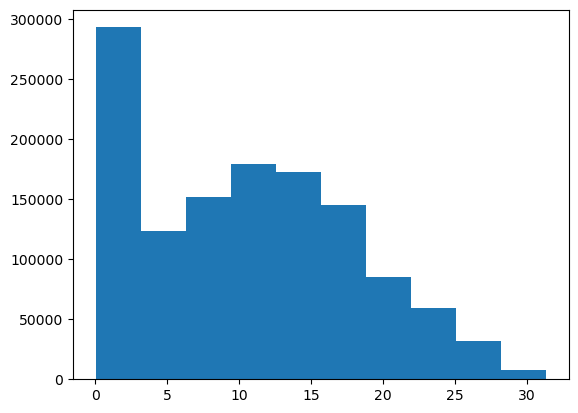

In [10]:
plt.hist(TxRxds.flatten())

In [11]:
TxRxds.shape

(10000, 5, 25)

### Using Jakes model 

In [12]:

def return_jakes_coeffcients(fd_max, TimeVaris, n_links = 5, plot = True):
    ff_gains, TimeSequences = [], []
    rays = 100
    for i in tqdm(range(n_links)):    
        #TimeVaris = np.arange(0,50,0.0005)
        #TimeVaris = np.arange(0,.2,0.005)
        frequs = np.sort(np.array([np.round(fd_max*np.cos(2*np.pi*np.random.uniform(0,1))) for _ in range(rays)]))
        phases = np.array([np.exp(1j*2*np.pi*np.random.uniform(0,1)) for _ in range(rays)])

        TimeSequence = []
        for t in TimeVaris:
            tab = np.exp(1j*2*np.pi*frequs*t)
            tabrot = tab*phases
            fun = np.sum(tabrot)
            TimeSequence.append(fun)
        TimeSequence = np.array(TimeSequence)

        #TimeSequence = TimeSequence/np.linalg.norm(TimeSequence)*np.sqrt(len(TimeSequence))
        PowerSequence1 =  np.abs(TimeSequence)**2;
        #plt.plot(TimeVaris[0:200], 10*np.log10(PowerSequence1)[0:200])
        ff_gains.append(PowerSequence1)
        TimeSequences.append(TimeSequence)
    ff_gains = np.array(ff_gains)/rays
    TimeSequences = np.array(TimeSequences)
    if plot:
        plt.plot(TimeVaris[0:200], 10*np.log10(ff_gains[0])[0:200])
        plt.show()
    return ff_gains, TimeSequences

v = 40 #kmph 
v_ms = v*5/18
c = 3*1e8
tau = .01
fd_max = v_ms*f_c*1e9/c
TimeVaris = np.arange(0,5,0.0005)

ff_gains, TimeSequences = return_jakes_coeffcients(fd_max, TimeVaris, n_links = M*(M-1)*J*N, plot = False)
#plt.plot(TimeVaris[0:Ts], 10*np.log10(ff_gains.flatten()[0:Ts]))
#plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [07:31<00:00,  6.65it/s]


In [13]:
#np.save( 'ff_gains_3000.npy',ff_gains)
#ff_gains = np.load('ff_gains_3000.npy')

In [14]:
############ fast fading coeffecients ########

FastFadingChannels = np.random.normal(0,1/np.sqrt(2), M*J*N) + 1j*np.random.normal(0,1/np.sqrt(2), M*J*N)
FastFadingChannels = np.reshape(FastFadingChannels,(M,J,N))
FadingGains = np.abs(FastFadingChannels)**2
#all_SINRsdB, all_MeansPerSubNW, all_DiffsFromMean = np.zeros((Ts, M*J)), np.zeros((Ts, M)), np.zeros((Ts, M*J))
all_SINRsdB = np.zeros((Ts, M,J,N))
alltime_WantedSigPerDev, alltime_InterfPowsPerDev = [], []
for ts in range(Ts):
    

    #FadingGains.shape

    all_fast_fading_gains = np.zeros((M,M*J,N))
    for m in range(M):
        jakes_coeffs = ff_gains[:,ts]
        jakes_coeffs = np.reshape(jakes_coeffs,(M,(M-1)*J,N))
        all_fast_fading_gains[m] = np.concatenate([FadingGains[m], jakes_coeffs[m]])
    all_fast_fading_gains = np.array(all_fast_fading_gains)
    
    PL_los = 31.84 +21.5*np.log10(TxRxds[ts]) + 19*np.log10(f_c)
    PL = 33+25.5*np.log10(TxRxds[ts])+20*np.log10(f_c)
    PL_nlos = np.max((PL_los, PL), axis = 0)
    PathGains = np.power(10, -PL_nlos/10)
    PathGains = np.repeat(PathGains[:, :, np.newaxis], N, axis=2)

    ##### Compute total path gains ########
    #pdb.set_trace()
    PathGainsTot = PathGains*all_fast_fading_gains

    #### Compute WantedSigPerDev ######
    WantedSigPerDev = np.zeros((M,J,N))
    for m in range(M):
        WantedSigPerDev[m] = PathGainsTot[m,m*J:(m+1)*J]
    alltime_WantedSigPerDev.append(WantedSigPerDev)
    InterfPowsPerDev = np.zeros((M,J,N))
    for m in range(M):
        Interferers = [i for i in range(M) if i!=m]
        Devs = np.arange(m*J,(m+1)*J)
        #print(Interferers, Devs)
        InterfPowGains = PathGainsTot[np.ix_(Interferers, Devs)]
        InterfPowsPerDev[m,] = np.sum(InterfPowGains, axis = 0)
    alltime_InterfPowsPerDev.append(InterfPowsPerDev)
    SINRs = WantedSigPerDev/(InterfPowsPerDev + 1/gamma_0);
    SINRsdB = 10*np.log10(SINRs)
    all_SINRsdB[ts,:] = SINRsdB
alltime_WantedSigPerDev = np.array(alltime_WantedSigPerDev)
alltime_InterfPowsPerDev = np.array(alltime_InterfPowsPerDev)

In [15]:
WantedSigPerDev.shape

(5, 5, 30)

27.342561560833843


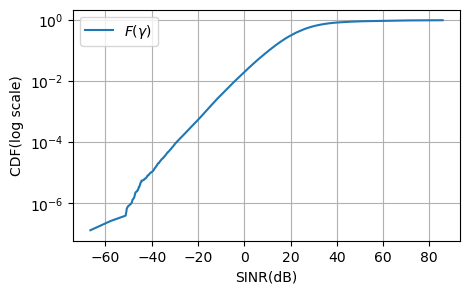

In [16]:
a1, cdf1 = return_cdf(all_SINRsdB.flatten())
plt.figure(figsize= [5,3])
#plt.ylim(np.min(cdf2))
plt.semilogy(a1, cdf1, label = r'$F(\gamma)$')
plt.grid()
plt.xlabel('SINR(dB)')
plt.ylabel('CDF(log scale)')
plt.legend()
print(np.mean(all_SINRsdB.flatten()))

In [17]:
PathGainsTot.shape

(5, 25, 30)

In [18]:
InterfPowGains.shape

(4, 5, 30)

11.932242208035754


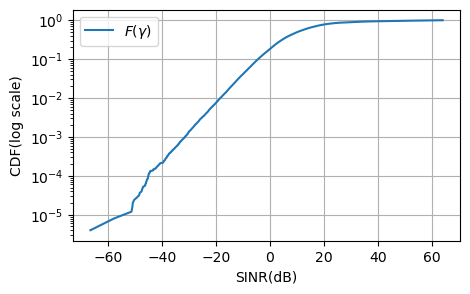

In [19]:
alltime_SINRsdB_combined = []
all_SINRslin = np.power(10, all_SINRsdB/10)
for ts in range(all_SINRsdB.shape[0]):
    vals = all_SINRslin[ts,:,:,:]
    SINRS_combined = np.min(vals, axis = 2)
    SINRsdB_combined = 10*np.log10(SINRS_combined)
    alltime_SINRsdB_combined.append(SINRsdB_combined)
alltime_SINRsdB_combined = np.array(alltime_SINRsdB_combined)

a1, cdf1 = return_cdf(alltime_SINRsdB_combined.flatten())
plt.figure(figsize= [5,3])
#plt.ylim(np.min(cdf2))
plt.semilogy(a1, cdf1, label = r'$F(\gamma)$')
plt.grid()
plt.xlabel('SINR(dB)')
plt.ylabel('CDF(log scale)')
plt.legend()
print(np.mean(alltime_SINRsdB_combined.flatten()))

In [20]:
all_SINRsdB.shape

(10000, 5, 5, 30)

### The below model needs to be integrated with DRL framework trained paralelly. 


##### prediction of SINR at t given 10 previous time slots #########
####### 10000 x 5x 5 x 30, 10000 is time slots, first 5 denotes the sub networks, 2nd 5 denotes the devices of a sub network, 
####### 30 denotes the channel resources. 


#### preparing data for a sub-network ########
######## each sub-network will have one LSTM layer getting trained in parallel with the main DRL agent ########
######### i.e., the LSTM layer is trained for a given example with a loss function and predicted SINR is given as the 
######### input to the DRL framework which is subsequently trained. This happens in an online fashion at every time-slot.

In [21]:
## data for a sub-network 
lag = 10
inp_data, out_data = [], []
for i in range(M):
    sinr_sub_nw = all_SINRsdB[:,0,:,:]
    data_per_device = sinr_sub_nw[:,0,:]
    for t in range(0, len(data_per_device)-lag):
        inp_data.append(data_per_device[t:t+lag])
        out_data.append(data_per_device[t+lag])

    
inp_data = np.array(inp_data)
out_data = np.array(out_data)

In [22]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Define the output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [23]:
samp_no =47000
inp_train_data = inp_data[0:samp_no]
out_train_data = out_data[0:samp_no]
inp_test_data = inp_data[samp_no:]
out_test_data = out_data[samp_no:]

# Convert numpy arrays to PyTorch tensors
inp_train_data = torch.tensor(inp_train_data, dtype=torch.float32)
out_train_data = torch.tensor(out_train_data, dtype=torch.float32)
inp_test_data = torch.tensor(inp_test_data, dtype=torch.float32)
out_test_data = torch.tensor(out_test_data, dtype=torch.float32)


inp_test_data 
# Create a dataset and dataloader
train_dataset = TensorDataset(inp_train_data, out_train_data)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)


In [24]:
# Set device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model parameters
input_dim = N
hidden_dim = 128
output_dim = N
num_layers = 1
num_epochs = 50
learning_rate = 1e-3

# Initialize the model, loss function and optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epoch_loss = []
# Training loop
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        #if (i+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/50], Step [1/735], Loss: 326.6364
Epoch [1/50], Step [2/735], Loss: 378.9938
Epoch [1/50], Step [3/735], Loss: 324.7120
Epoch [1/50], Step [4/735], Loss: 347.9648
Epoch [1/50], Step [5/735], Loss: 364.8281
Epoch [1/50], Step [6/735], Loss: 353.8886
Epoch [1/50], Step [7/735], Loss: 386.9536
Epoch [1/50], Step [8/735], Loss: 287.2282
Epoch [1/50], Step [9/735], Loss: 316.9350
Epoch [1/50], Step [10/735], Loss: 343.9369
Epoch [1/50], Step [11/735], Loss: 336.2985
Epoch [1/50], Step [12/735], Loss: 322.2376
Epoch [1/50], Step [13/735], Loss: 315.9123
Epoch [1/50], Step [14/735], Loss: 303.5144
Epoch [1/50], Step [15/735], Loss: 310.5087
Epoch [1/50], Step [16/735], Loss: 336.7853
Epoch [1/50], Step [17/735], Loss: 339.2222
Epoch [1/50], Step [18/735], Loss: 310.3443
Epoch [1/50], Step [19/735], Loss: 298.8839
Epoch [1/50], Step [20/735], Loss: 331.2439
Epoch [1/50], Step [21/735], Loss: 314.6675
Epoch [1/50], Step [22/735], Loss: 299.6485
Epoch [1/50], Step [23/735], Loss: 299.72

Epoch [1/50], Step [196/735], Loss: 22.7435
Epoch [1/50], Step [197/735], Loss: 26.8000
Epoch [1/50], Step [198/735], Loss: 23.2911
Epoch [1/50], Step [199/735], Loss: 19.7886
Epoch [1/50], Step [200/735], Loss: 23.7576
Epoch [1/50], Step [201/735], Loss: 23.2205
Epoch [1/50], Step [202/735], Loss: 18.8190
Epoch [1/50], Step [203/735], Loss: 22.0590
Epoch [1/50], Step [204/735], Loss: 21.3020
Epoch [1/50], Step [205/735], Loss: 23.6653
Epoch [1/50], Step [206/735], Loss: 21.3625
Epoch [1/50], Step [207/735], Loss: 20.0246
Epoch [1/50], Step [208/735], Loss: 19.9233
Epoch [1/50], Step [209/735], Loss: 17.2262
Epoch [1/50], Step [210/735], Loss: 19.4523
Epoch [1/50], Step [211/735], Loss: 25.4883
Epoch [1/50], Step [212/735], Loss: 23.3298
Epoch [1/50], Step [213/735], Loss: 20.7251
Epoch [1/50], Step [214/735], Loss: 18.4301
Epoch [1/50], Step [215/735], Loss: 21.4694
Epoch [1/50], Step [216/735], Loss: 20.6047
Epoch [1/50], Step [217/735], Loss: 20.1227
Epoch [1/50], Step [218/735], Lo

Epoch [1/50], Step [389/735], Loss: 5.6677
Epoch [1/50], Step [390/735], Loss: 6.1797
Epoch [1/50], Step [391/735], Loss: 9.6281
Epoch [1/50], Step [392/735], Loss: 5.4587
Epoch [1/50], Step [393/735], Loss: 6.8294
Epoch [1/50], Step [394/735], Loss: 5.3233
Epoch [1/50], Step [395/735], Loss: 6.6903
Epoch [1/50], Step [396/735], Loss: 6.3955
Epoch [1/50], Step [397/735], Loss: 5.8919
Epoch [1/50], Step [398/735], Loss: 5.6286
Epoch [1/50], Step [399/735], Loss: 5.3904
Epoch [1/50], Step [400/735], Loss: 5.4795
Epoch [1/50], Step [401/735], Loss: 6.2306
Epoch [1/50], Step [402/735], Loss: 6.2813
Epoch [1/50], Step [403/735], Loss: 6.6159
Epoch [1/50], Step [404/735], Loss: 7.1325
Epoch [1/50], Step [405/735], Loss: 4.8130
Epoch [1/50], Step [406/735], Loss: 6.8278
Epoch [1/50], Step [407/735], Loss: 6.1347
Epoch [1/50], Step [408/735], Loss: 5.6059
Epoch [1/50], Step [409/735], Loss: 5.4468
Epoch [1/50], Step [410/735], Loss: 6.0483
Epoch [1/50], Step [411/735], Loss: 5.4209
Epoch [1/50

Epoch [1/50], Step [597/735], Loss: 2.8681
Epoch [1/50], Step [598/735], Loss: 3.3597
Epoch [1/50], Step [599/735], Loss: 2.5442
Epoch [1/50], Step [600/735], Loss: 3.6012
Epoch [1/50], Step [601/735], Loss: 3.1371
Epoch [1/50], Step [602/735], Loss: 3.1299
Epoch [1/50], Step [603/735], Loss: 4.7545
Epoch [1/50], Step [604/735], Loss: 3.0927
Epoch [1/50], Step [605/735], Loss: 3.0123
Epoch [1/50], Step [606/735], Loss: 2.9892
Epoch [1/50], Step [607/735], Loss: 2.6907
Epoch [1/50], Step [608/735], Loss: 2.5076
Epoch [1/50], Step [609/735], Loss: 3.2037
Epoch [1/50], Step [610/735], Loss: 3.5756
Epoch [1/50], Step [611/735], Loss: 3.3664
Epoch [1/50], Step [612/735], Loss: 3.7671
Epoch [1/50], Step [613/735], Loss: 2.6189
Epoch [1/50], Step [614/735], Loss: 2.9715
Epoch [1/50], Step [615/735], Loss: 2.8358
Epoch [1/50], Step [616/735], Loss: 2.9853
Epoch [1/50], Step [617/735], Loss: 3.8161
Epoch [1/50], Step [618/735], Loss: 2.5608
Epoch [1/50], Step [619/735], Loss: 3.0520
Epoch [1/50

Epoch [2/50], Step [67/735], Loss: 1.6710
Epoch [2/50], Step [68/735], Loss: 2.7042
Epoch [2/50], Step [69/735], Loss: 1.4715
Epoch [2/50], Step [70/735], Loss: 2.1907
Epoch [2/50], Step [71/735], Loss: 2.0564
Epoch [2/50], Step [72/735], Loss: 1.4178
Epoch [2/50], Step [73/735], Loss: 2.3568
Epoch [2/50], Step [74/735], Loss: 2.3272
Epoch [2/50], Step [75/735], Loss: 1.8817
Epoch [2/50], Step [76/735], Loss: 1.6251
Epoch [2/50], Step [77/735], Loss: 1.7357
Epoch [2/50], Step [78/735], Loss: 1.9030
Epoch [2/50], Step [79/735], Loss: 1.6118
Epoch [2/50], Step [80/735], Loss: 2.9016
Epoch [2/50], Step [81/735], Loss: 1.7997
Epoch [2/50], Step [82/735], Loss: 1.6625
Epoch [2/50], Step [83/735], Loss: 1.8611
Epoch [2/50], Step [84/735], Loss: 2.0357
Epoch [2/50], Step [85/735], Loss: 1.9711
Epoch [2/50], Step [86/735], Loss: 4.0380
Epoch [2/50], Step [87/735], Loss: 1.5028
Epoch [2/50], Step [88/735], Loss: 1.5191
Epoch [2/50], Step [89/735], Loss: 1.4254
Epoch [2/50], Step [90/735], Loss:

Epoch [2/50], Step [272/735], Loss: 1.2513
Epoch [2/50], Step [273/735], Loss: 1.4109
Epoch [2/50], Step [274/735], Loss: 1.6812
Epoch [2/50], Step [275/735], Loss: 1.1171
Epoch [2/50], Step [276/735], Loss: 1.3816
Epoch [2/50], Step [277/735], Loss: 1.4595
Epoch [2/50], Step [278/735], Loss: 0.9548
Epoch [2/50], Step [279/735], Loss: 1.2454
Epoch [2/50], Step [280/735], Loss: 0.9685
Epoch [2/50], Step [281/735], Loss: 1.5152
Epoch [2/50], Step [282/735], Loss: 1.2339
Epoch [2/50], Step [283/735], Loss: 1.0883
Epoch [2/50], Step [284/735], Loss: 1.2192
Epoch [2/50], Step [285/735], Loss: 1.5897
Epoch [2/50], Step [286/735], Loss: 1.9399
Epoch [2/50], Step [287/735], Loss: 1.8179
Epoch [2/50], Step [288/735], Loss: 1.0827
Epoch [2/50], Step [289/735], Loss: 1.0966
Epoch [2/50], Step [290/735], Loss: 1.2969
Epoch [2/50], Step [291/735], Loss: 1.1034
Epoch [2/50], Step [292/735], Loss: 1.3603
Epoch [2/50], Step [293/735], Loss: 0.9739
Epoch [2/50], Step [294/735], Loss: 0.9006
Epoch [2/50

Epoch [2/50], Step [463/735], Loss: 1.3497
Epoch [2/50], Step [464/735], Loss: 0.4606
Epoch [2/50], Step [465/735], Loss: 0.8174
Epoch [2/50], Step [466/735], Loss: 0.8529
Epoch [2/50], Step [467/735], Loss: 0.9753
Epoch [2/50], Step [468/735], Loss: 1.3246
Epoch [2/50], Step [469/735], Loss: 1.0412
Epoch [2/50], Step [470/735], Loss: 0.8890
Epoch [2/50], Step [471/735], Loss: 0.7670
Epoch [2/50], Step [472/735], Loss: 1.2889
Epoch [2/50], Step [473/735], Loss: 1.3341
Epoch [2/50], Step [474/735], Loss: 1.1120
Epoch [2/50], Step [475/735], Loss: 0.7601
Epoch [2/50], Step [476/735], Loss: 0.6115
Epoch [2/50], Step [477/735], Loss: 0.9444
Epoch [2/50], Step [478/735], Loss: 1.1722
Epoch [2/50], Step [479/735], Loss: 0.6747
Epoch [2/50], Step [480/735], Loss: 0.8275
Epoch [2/50], Step [481/735], Loss: 0.7011
Epoch [2/50], Step [482/735], Loss: 1.2206
Epoch [2/50], Step [483/735], Loss: 1.2571
Epoch [2/50], Step [484/735], Loss: 0.8794
Epoch [2/50], Step [485/735], Loss: 0.7241
Epoch [2/50

Epoch [2/50], Step [668/735], Loss: 1.0913
Epoch [2/50], Step [669/735], Loss: 0.3199
Epoch [2/50], Step [670/735], Loss: 0.8385
Epoch [2/50], Step [671/735], Loss: 0.9961
Epoch [2/50], Step [672/735], Loss: 0.3841
Epoch [2/50], Step [673/735], Loss: 0.4928
Epoch [2/50], Step [674/735], Loss: 0.5326
Epoch [2/50], Step [675/735], Loss: 1.0850
Epoch [2/50], Step [676/735], Loss: 0.6614
Epoch [2/50], Step [677/735], Loss: 0.5151
Epoch [2/50], Step [678/735], Loss: 0.4113
Epoch [2/50], Step [679/735], Loss: 0.5149
Epoch [2/50], Step [680/735], Loss: 0.5138
Epoch [2/50], Step [681/735], Loss: 0.8673
Epoch [2/50], Step [682/735], Loss: 0.5566
Epoch [2/50], Step [683/735], Loss: 1.3097
Epoch [2/50], Step [684/735], Loss: 0.7195
Epoch [2/50], Step [685/735], Loss: 0.2999
Epoch [2/50], Step [686/735], Loss: 0.6742
Epoch [2/50], Step [687/735], Loss: 0.6701
Epoch [2/50], Step [688/735], Loss: 0.8575
Epoch [2/50], Step [689/735], Loss: 0.3396
Epoch [2/50], Step [690/735], Loss: 1.3121
Epoch [2/50

Epoch [3/50], Step [133/735], Loss: 0.3010
Epoch [3/50], Step [134/735], Loss: 0.3545
Epoch [3/50], Step [135/735], Loss: 0.7505
Epoch [3/50], Step [136/735], Loss: 0.4438
Epoch [3/50], Step [137/735], Loss: 0.4276
Epoch [3/50], Step [138/735], Loss: 0.6117
Epoch [3/50], Step [139/735], Loss: 0.3187
Epoch [3/50], Step [140/735], Loss: 0.7975
Epoch [3/50], Step [141/735], Loss: 0.5097
Epoch [3/50], Step [142/735], Loss: 0.6505
Epoch [3/50], Step [143/735], Loss: 0.4468
Epoch [3/50], Step [144/735], Loss: 0.4675
Epoch [3/50], Step [145/735], Loss: 0.7304
Epoch [3/50], Step [146/735], Loss: 0.8172
Epoch [3/50], Step [147/735], Loss: 0.4248
Epoch [3/50], Step [148/735], Loss: 0.2623
Epoch [3/50], Step [149/735], Loss: 0.4542
Epoch [3/50], Step [150/735], Loss: 0.3639
Epoch [3/50], Step [151/735], Loss: 0.7225
Epoch [3/50], Step [152/735], Loss: 0.2729
Epoch [3/50], Step [153/735], Loss: 0.8326
Epoch [3/50], Step [154/735], Loss: 0.6703
Epoch [3/50], Step [155/735], Loss: 0.6727
Epoch [3/50

Epoch [3/50], Step [346/735], Loss: 0.4552
Epoch [3/50], Step [347/735], Loss: 0.2578
Epoch [3/50], Step [348/735], Loss: 0.1739
Epoch [3/50], Step [349/735], Loss: 0.2917
Epoch [3/50], Step [350/735], Loss: 0.6285
Epoch [3/50], Step [351/735], Loss: 0.8949
Epoch [3/50], Step [352/735], Loss: 0.6649
Epoch [3/50], Step [353/735], Loss: 0.2580
Epoch [3/50], Step [354/735], Loss: 0.2610
Epoch [3/50], Step [355/735], Loss: 0.2616
Epoch [3/50], Step [356/735], Loss: 0.4134
Epoch [3/50], Step [357/735], Loss: 0.4906
Epoch [3/50], Step [358/735], Loss: 0.7841
Epoch [3/50], Step [359/735], Loss: 0.5047
Epoch [3/50], Step [360/735], Loss: 0.3480
Epoch [3/50], Step [361/735], Loss: 0.5374
Epoch [3/50], Step [362/735], Loss: 0.6942
Epoch [3/50], Step [363/735], Loss: 0.7203
Epoch [3/50], Step [364/735], Loss: 0.5471
Epoch [3/50], Step [365/735], Loss: 0.2844
Epoch [3/50], Step [366/735], Loss: 2.2437
Epoch [3/50], Step [367/735], Loss: 0.2759
Epoch [3/50], Step [368/735], Loss: 0.1840
Epoch [3/50

Epoch [3/50], Step [552/735], Loss: 0.3074
Epoch [3/50], Step [553/735], Loss: 0.7310
Epoch [3/50], Step [554/735], Loss: 0.2620
Epoch [3/50], Step [555/735], Loss: 0.1771
Epoch [3/50], Step [556/735], Loss: 0.3260
Epoch [3/50], Step [557/735], Loss: 0.2147
Epoch [3/50], Step [558/735], Loss: 0.2082
Epoch [3/50], Step [559/735], Loss: 0.5903
Epoch [3/50], Step [560/735], Loss: 0.1795
Epoch [3/50], Step [561/735], Loss: 2.1741
Epoch [3/50], Step [562/735], Loss: 0.3935
Epoch [3/50], Step [563/735], Loss: 0.5810
Epoch [3/50], Step [564/735], Loss: 0.2163
Epoch [3/50], Step [565/735], Loss: 0.2616
Epoch [3/50], Step [566/735], Loss: 0.2373
Epoch [3/50], Step [567/735], Loss: 0.4221
Epoch [3/50], Step [568/735], Loss: 1.1611
Epoch [3/50], Step [569/735], Loss: 0.2813
Epoch [3/50], Step [570/735], Loss: 0.4154
Epoch [3/50], Step [571/735], Loss: 0.1984
Epoch [3/50], Step [572/735], Loss: 1.1570
Epoch [3/50], Step [573/735], Loss: 0.3581
Epoch [3/50], Step [574/735], Loss: 0.3376
Epoch [3/50

Epoch [4/50], Step [20/735], Loss: 0.1473
Epoch [4/50], Step [21/735], Loss: 0.3260
Epoch [4/50], Step [22/735], Loss: 0.6644
Epoch [4/50], Step [23/735], Loss: 0.2807
Epoch [4/50], Step [24/735], Loss: 0.2236
Epoch [4/50], Step [25/735], Loss: 0.4221
Epoch [4/50], Step [26/735], Loss: 0.1852
Epoch [4/50], Step [27/735], Loss: 0.2222
Epoch [4/50], Step [28/735], Loss: 0.2415
Epoch [4/50], Step [29/735], Loss: 0.3380
Epoch [4/50], Step [30/735], Loss: 0.3101
Epoch [4/50], Step [31/735], Loss: 0.7003
Epoch [4/50], Step [32/735], Loss: 0.5201
Epoch [4/50], Step [33/735], Loss: 0.6454
Epoch [4/50], Step [34/735], Loss: 0.7568
Epoch [4/50], Step [35/735], Loss: 0.3578
Epoch [4/50], Step [36/735], Loss: 0.7046
Epoch [4/50], Step [37/735], Loss: 0.2491
Epoch [4/50], Step [38/735], Loss: 0.1823
Epoch [4/50], Step [39/735], Loss: 0.1913
Epoch [4/50], Step [40/735], Loss: 2.4183
Epoch [4/50], Step [41/735], Loss: 0.5719
Epoch [4/50], Step [42/735], Loss: 0.2753
Epoch [4/50], Step [43/735], Loss:

Epoch [4/50], Step [230/735], Loss: 0.1842
Epoch [4/50], Step [231/735], Loss: 2.7782
Epoch [4/50], Step [232/735], Loss: 0.3318
Epoch [4/50], Step [233/735], Loss: 0.3360
Epoch [4/50], Step [234/735], Loss: 0.1578
Epoch [4/50], Step [235/735], Loss: 0.3551
Epoch [4/50], Step [236/735], Loss: 0.5110
Epoch [4/50], Step [237/735], Loss: 0.1092
Epoch [4/50], Step [238/735], Loss: 0.3165
Epoch [4/50], Step [239/735], Loss: 0.3735
Epoch [4/50], Step [240/735], Loss: 0.2268
Epoch [4/50], Step [241/735], Loss: 0.1617
Epoch [4/50], Step [242/735], Loss: 0.2103
Epoch [4/50], Step [243/735], Loss: 0.2471
Epoch [4/50], Step [244/735], Loss: 0.4488
Epoch [4/50], Step [245/735], Loss: 0.2150
Epoch [4/50], Step [246/735], Loss: 0.2426
Epoch [4/50], Step [247/735], Loss: 2.7477
Epoch [4/50], Step [248/735], Loss: 0.9222
Epoch [4/50], Step [249/735], Loss: 0.1897
Epoch [4/50], Step [250/735], Loss: 0.5472
Epoch [4/50], Step [251/735], Loss: 0.6592
Epoch [4/50], Step [252/735], Loss: 0.2115
Epoch [4/50

Epoch [4/50], Step [423/735], Loss: 0.1440
Epoch [4/50], Step [424/735], Loss: 1.1987
Epoch [4/50], Step [425/735], Loss: 0.6321
Epoch [4/50], Step [426/735], Loss: 0.2266
Epoch [4/50], Step [427/735], Loss: 0.4973
Epoch [4/50], Step [428/735], Loss: 0.3577
Epoch [4/50], Step [429/735], Loss: 0.3019
Epoch [4/50], Step [430/735], Loss: 0.3070
Epoch [4/50], Step [431/735], Loss: 0.1675
Epoch [4/50], Step [432/735], Loss: 0.3686
Epoch [4/50], Step [433/735], Loss: 0.1721
Epoch [4/50], Step [434/735], Loss: 0.5406
Epoch [4/50], Step [435/735], Loss: 2.1053
Epoch [4/50], Step [436/735], Loss: 0.3851
Epoch [4/50], Step [437/735], Loss: 0.3729
Epoch [4/50], Step [438/735], Loss: 0.3862
Epoch [4/50], Step [439/735], Loss: 0.1286
Epoch [4/50], Step [440/735], Loss: 0.3741
Epoch [4/50], Step [441/735], Loss: 0.1654
Epoch [4/50], Step [442/735], Loss: 0.2019
Epoch [4/50], Step [443/735], Loss: 0.4108
Epoch [4/50], Step [444/735], Loss: 0.1886
Epoch [4/50], Step [445/735], Loss: 0.4447
Epoch [4/50

Epoch [4/50], Step [617/735], Loss: 0.1125
Epoch [4/50], Step [618/735], Loss: 0.2087
Epoch [4/50], Step [619/735], Loss: 0.1813
Epoch [4/50], Step [620/735], Loss: 0.1107
Epoch [4/50], Step [621/735], Loss: 0.2571
Epoch [4/50], Step [622/735], Loss: 0.3722
Epoch [4/50], Step [623/735], Loss: 0.8902
Epoch [4/50], Step [624/735], Loss: 0.1631
Epoch [4/50], Step [625/735], Loss: 0.0952
Epoch [4/50], Step [626/735], Loss: 0.2379
Epoch [4/50], Step [627/735], Loss: 0.2594
Epoch [4/50], Step [628/735], Loss: 0.1810
Epoch [4/50], Step [629/735], Loss: 0.3488
Epoch [4/50], Step [630/735], Loss: 0.1367
Epoch [4/50], Step [631/735], Loss: 0.2227
Epoch [4/50], Step [632/735], Loss: 0.5721
Epoch [4/50], Step [633/735], Loss: 0.1671
Epoch [4/50], Step [634/735], Loss: 0.5599
Epoch [4/50], Step [635/735], Loss: 0.2935
Epoch [4/50], Step [636/735], Loss: 0.5774
Epoch [4/50], Step [637/735], Loss: 0.3308
Epoch [4/50], Step [638/735], Loss: 0.3484
Epoch [4/50], Step [639/735], Loss: 0.2441
Epoch [4/50

Epoch [5/50], Step [96/735], Loss: 0.1903
Epoch [5/50], Step [97/735], Loss: 0.4180
Epoch [5/50], Step [98/735], Loss: 0.1551
Epoch [5/50], Step [99/735], Loss: 0.4742
Epoch [5/50], Step [100/735], Loss: 0.1542
Epoch [5/50], Step [101/735], Loss: 0.3962
Epoch [5/50], Step [102/735], Loss: 0.3287
Epoch [5/50], Step [103/735], Loss: 0.4202
Epoch [5/50], Step [104/735], Loss: 3.1716
Epoch [5/50], Step [105/735], Loss: 0.3038
Epoch [5/50], Step [106/735], Loss: 0.1533
Epoch [5/50], Step [107/735], Loss: 0.2090
Epoch [5/50], Step [108/735], Loss: 0.1583
Epoch [5/50], Step [109/735], Loss: 0.1387
Epoch [5/50], Step [110/735], Loss: 0.1431
Epoch [5/50], Step [111/735], Loss: 0.1402
Epoch [5/50], Step [112/735], Loss: 0.3810
Epoch [5/50], Step [113/735], Loss: 1.4023
Epoch [5/50], Step [114/735], Loss: 0.3751
Epoch [5/50], Step [115/735], Loss: 0.2743
Epoch [5/50], Step [116/735], Loss: 0.2470
Epoch [5/50], Step [117/735], Loss: 0.2582
Epoch [5/50], Step [118/735], Loss: 0.5932
Epoch [5/50], S

Epoch [5/50], Step [301/735], Loss: 0.2128
Epoch [5/50], Step [302/735], Loss: 0.1875
Epoch [5/50], Step [303/735], Loss: 0.0932
Epoch [5/50], Step [304/735], Loss: 0.2375
Epoch [5/50], Step [305/735], Loss: 0.2313
Epoch [5/50], Step [306/735], Loss: 0.1997
Epoch [5/50], Step [307/735], Loss: 0.1066
Epoch [5/50], Step [308/735], Loss: 0.1629
Epoch [5/50], Step [309/735], Loss: 0.1359
Epoch [5/50], Step [310/735], Loss: 0.3023
Epoch [5/50], Step [311/735], Loss: 0.5275
Epoch [5/50], Step [312/735], Loss: 0.6968
Epoch [5/50], Step [313/735], Loss: 0.2869
Epoch [5/50], Step [314/735], Loss: 0.2916
Epoch [5/50], Step [315/735], Loss: 0.7641
Epoch [5/50], Step [316/735], Loss: 0.2201
Epoch [5/50], Step [317/735], Loss: 0.8068
Epoch [5/50], Step [318/735], Loss: 0.5401
Epoch [5/50], Step [319/735], Loss: 0.3584
Epoch [5/50], Step [320/735], Loss: 0.1942
Epoch [5/50], Step [321/735], Loss: 0.1839
Epoch [5/50], Step [322/735], Loss: 0.2711
Epoch [5/50], Step [323/735], Loss: 0.1524
Epoch [5/50

Epoch [5/50], Step [504/735], Loss: 0.4318
Epoch [5/50], Step [505/735], Loss: 0.1684
Epoch [5/50], Step [506/735], Loss: 0.4114
Epoch [5/50], Step [507/735], Loss: 0.1234
Epoch [5/50], Step [508/735], Loss: 0.3691
Epoch [5/50], Step [509/735], Loss: 0.2371
Epoch [5/50], Step [510/735], Loss: 0.4595
Epoch [5/50], Step [511/735], Loss: 0.3532
Epoch [5/50], Step [512/735], Loss: 0.1740
Epoch [5/50], Step [513/735], Loss: 0.3790
Epoch [5/50], Step [514/735], Loss: 0.3023
Epoch [5/50], Step [515/735], Loss: 0.1145
Epoch [5/50], Step [516/735], Loss: 0.1741
Epoch [5/50], Step [517/735], Loss: 0.2158
Epoch [5/50], Step [518/735], Loss: 0.2616
Epoch [5/50], Step [519/735], Loss: 0.1302
Epoch [5/50], Step [520/735], Loss: 0.0683
Epoch [5/50], Step [521/735], Loss: 0.1496
Epoch [5/50], Step [522/735], Loss: 0.1446
Epoch [5/50], Step [523/735], Loss: 0.1903
Epoch [5/50], Step [524/735], Loss: 0.1767
Epoch [5/50], Step [525/735], Loss: 0.1663
Epoch [5/50], Step [526/735], Loss: 1.3409
Epoch [5/50

Epoch [5/50], Step [700/735], Loss: 0.1874
Epoch [5/50], Step [701/735], Loss: 0.4827
Epoch [5/50], Step [702/735], Loss: 2.9997
Epoch [5/50], Step [703/735], Loss: 1.2839
Epoch [5/50], Step [704/735], Loss: 0.1229
Epoch [5/50], Step [705/735], Loss: 0.1847
Epoch [5/50], Step [706/735], Loss: 0.1891
Epoch [5/50], Step [707/735], Loss: 0.1505
Epoch [5/50], Step [708/735], Loss: 0.2088
Epoch [5/50], Step [709/735], Loss: 0.1565
Epoch [5/50], Step [710/735], Loss: 0.2750
Epoch [5/50], Step [711/735], Loss: 0.4490
Epoch [5/50], Step [712/735], Loss: 0.2824
Epoch [5/50], Step [713/735], Loss: 0.1224
Epoch [5/50], Step [714/735], Loss: 0.1643
Epoch [5/50], Step [715/735], Loss: 0.1512
Epoch [5/50], Step [716/735], Loss: 0.3382
Epoch [5/50], Step [717/735], Loss: 1.0419
Epoch [5/50], Step [718/735], Loss: 0.2188
Epoch [5/50], Step [719/735], Loss: 0.1165
Epoch [5/50], Step [720/735], Loss: 0.1689
Epoch [5/50], Step [721/735], Loss: 0.1932
Epoch [5/50], Step [722/735], Loss: 0.2408
Epoch [5/50

Epoch [6/50], Step [170/735], Loss: 0.3447
Epoch [6/50], Step [171/735], Loss: 0.0798
Epoch [6/50], Step [172/735], Loss: 0.1650
Epoch [6/50], Step [173/735], Loss: 0.2054
Epoch [6/50], Step [174/735], Loss: 0.2263
Epoch [6/50], Step [175/735], Loss: 0.3168
Epoch [6/50], Step [176/735], Loss: 0.1441
Epoch [6/50], Step [177/735], Loss: 0.1343
Epoch [6/50], Step [178/735], Loss: 0.1813
Epoch [6/50], Step [179/735], Loss: 0.3368
Epoch [6/50], Step [180/735], Loss: 1.4019
Epoch [6/50], Step [181/735], Loss: 0.1387
Epoch [6/50], Step [182/735], Loss: 0.2677
Epoch [6/50], Step [183/735], Loss: 0.3447
Epoch [6/50], Step [184/735], Loss: 1.1097
Epoch [6/50], Step [185/735], Loss: 0.1453
Epoch [6/50], Step [186/735], Loss: 0.2103
Epoch [6/50], Step [187/735], Loss: 0.2643
Epoch [6/50], Step [188/735], Loss: 0.4352
Epoch [6/50], Step [189/735], Loss: 0.1693
Epoch [6/50], Step [190/735], Loss: 0.2276
Epoch [6/50], Step [191/735], Loss: 0.1375
Epoch [6/50], Step [192/735], Loss: 0.1070
Epoch [6/50

Epoch [6/50], Step [363/735], Loss: 0.3565
Epoch [6/50], Step [364/735], Loss: 0.1309
Epoch [6/50], Step [365/735], Loss: 0.1435
Epoch [6/50], Step [366/735], Loss: 0.2025
Epoch [6/50], Step [367/735], Loss: 0.1932
Epoch [6/50], Step [368/735], Loss: 0.1112
Epoch [6/50], Step [369/735], Loss: 0.1510
Epoch [6/50], Step [370/735], Loss: 0.0719
Epoch [6/50], Step [371/735], Loss: 0.1285
Epoch [6/50], Step [372/735], Loss: 0.1590
Epoch [6/50], Step [373/735], Loss: 0.1380
Epoch [6/50], Step [374/735], Loss: 0.0710
Epoch [6/50], Step [375/735], Loss: 0.1469
Epoch [6/50], Step [376/735], Loss: 0.0770
Epoch [6/50], Step [377/735], Loss: 0.1032
Epoch [6/50], Step [378/735], Loss: 0.1957
Epoch [6/50], Step [379/735], Loss: 0.9027
Epoch [6/50], Step [380/735], Loss: 0.2400
Epoch [6/50], Step [381/735], Loss: 0.1324
Epoch [6/50], Step [382/735], Loss: 0.1648
Epoch [6/50], Step [383/735], Loss: 0.1196
Epoch [6/50], Step [384/735], Loss: 0.1058
Epoch [6/50], Step [385/735], Loss: 0.1365
Epoch [6/50

Epoch [6/50], Step [580/735], Loss: 0.9140
Epoch [6/50], Step [581/735], Loss: 0.1942
Epoch [6/50], Step [582/735], Loss: 0.3073
Epoch [6/50], Step [583/735], Loss: 0.5936
Epoch [6/50], Step [584/735], Loss: 0.4417
Epoch [6/50], Step [585/735], Loss: 0.2840
Epoch [6/50], Step [586/735], Loss: 0.1218
Epoch [6/50], Step [587/735], Loss: 0.1944
Epoch [6/50], Step [588/735], Loss: 0.6142
Epoch [6/50], Step [589/735], Loss: 0.1844
Epoch [6/50], Step [590/735], Loss: 0.2195
Epoch [6/50], Step [591/735], Loss: 0.2271
Epoch [6/50], Step [592/735], Loss: 0.1071
Epoch [6/50], Step [593/735], Loss: 0.2276
Epoch [6/50], Step [594/735], Loss: 0.2476
Epoch [6/50], Step [595/735], Loss: 0.2736
Epoch [6/50], Step [596/735], Loss: 0.2117
Epoch [6/50], Step [597/735], Loss: 0.1396
Epoch [6/50], Step [598/735], Loss: 0.1833
Epoch [6/50], Step [599/735], Loss: 2.3055
Epoch [6/50], Step [600/735], Loss: 0.1418
Epoch [6/50], Step [601/735], Loss: 0.0874
Epoch [6/50], Step [602/735], Loss: 0.7557
Epoch [6/50

Epoch [7/50], Step [60/735], Loss: 0.0814
Epoch [7/50], Step [61/735], Loss: 0.2471
Epoch [7/50], Step [62/735], Loss: 0.3467
Epoch [7/50], Step [63/735], Loss: 0.4787
Epoch [7/50], Step [64/735], Loss: 0.3442
Epoch [7/50], Step [65/735], Loss: 0.3464
Epoch [7/50], Step [66/735], Loss: 0.3312
Epoch [7/50], Step [67/735], Loss: 0.1146
Epoch [7/50], Step [68/735], Loss: 0.2311
Epoch [7/50], Step [69/735], Loss: 0.1267
Epoch [7/50], Step [70/735], Loss: 0.0991
Epoch [7/50], Step [71/735], Loss: 0.0875
Epoch [7/50], Step [72/735], Loss: 0.0851
Epoch [7/50], Step [73/735], Loss: 0.1177
Epoch [7/50], Step [74/735], Loss: 0.1650
Epoch [7/50], Step [75/735], Loss: 0.1549
Epoch [7/50], Step [76/735], Loss: 0.0712
Epoch [7/50], Step [77/735], Loss: 0.2163
Epoch [7/50], Step [78/735], Loss: 0.1348
Epoch [7/50], Step [79/735], Loss: 0.2283
Epoch [7/50], Step [80/735], Loss: 0.3720
Epoch [7/50], Step [81/735], Loss: 0.1778
Epoch [7/50], Step [82/735], Loss: 0.1067
Epoch [7/50], Step [83/735], Loss:

Epoch [7/50], Step [261/735], Loss: 0.6646
Epoch [7/50], Step [262/735], Loss: 0.3424
Epoch [7/50], Step [263/735], Loss: 0.0900
Epoch [7/50], Step [264/735], Loss: 0.1448
Epoch [7/50], Step [265/735], Loss: 0.0910
Epoch [7/50], Step [266/735], Loss: 0.2858
Epoch [7/50], Step [267/735], Loss: 0.6137
Epoch [7/50], Step [268/735], Loss: 0.2575
Epoch [7/50], Step [269/735], Loss: 0.2243
Epoch [7/50], Step [270/735], Loss: 0.1228
Epoch [7/50], Step [271/735], Loss: 1.2612
Epoch [7/50], Step [272/735], Loss: 0.1087
Epoch [7/50], Step [273/735], Loss: 0.7017
Epoch [7/50], Step [274/735], Loss: 0.0845
Epoch [7/50], Step [275/735], Loss: 0.0941
Epoch [7/50], Step [276/735], Loss: 0.1573
Epoch [7/50], Step [277/735], Loss: 0.2669
Epoch [7/50], Step [278/735], Loss: 0.3102
Epoch [7/50], Step [279/735], Loss: 0.1203
Epoch [7/50], Step [280/735], Loss: 1.1245
Epoch [7/50], Step [281/735], Loss: 0.1312
Epoch [7/50], Step [282/735], Loss: 0.1439
Epoch [7/50], Step [283/735], Loss: 0.1642
Epoch [7/50

Epoch [7/50], Step [463/735], Loss: 0.1111
Epoch [7/50], Step [464/735], Loss: 0.0800
Epoch [7/50], Step [465/735], Loss: 0.0703
Epoch [7/50], Step [466/735], Loss: 0.1594
Epoch [7/50], Step [467/735], Loss: 0.0783
Epoch [7/50], Step [468/735], Loss: 0.2876
Epoch [7/50], Step [469/735], Loss: 0.1671
Epoch [7/50], Step [470/735], Loss: 0.1470
Epoch [7/50], Step [471/735], Loss: 0.4509
Epoch [7/50], Step [472/735], Loss: 0.2069
Epoch [7/50], Step [473/735], Loss: 0.1674
Epoch [7/50], Step [474/735], Loss: 0.0722
Epoch [7/50], Step [475/735], Loss: 0.3364
Epoch [7/50], Step [476/735], Loss: 0.2371
Epoch [7/50], Step [477/735], Loss: 0.1612
Epoch [7/50], Step [478/735], Loss: 0.3063
Epoch [7/50], Step [479/735], Loss: 0.1327
Epoch [7/50], Step [480/735], Loss: 0.0603
Epoch [7/50], Step [481/735], Loss: 0.6196
Epoch [7/50], Step [482/735], Loss: 0.2634
Epoch [7/50], Step [483/735], Loss: 0.1906
Epoch [7/50], Step [484/735], Loss: 0.3278
Epoch [7/50], Step [485/735], Loss: 0.3456
Epoch [7/50

Epoch [7/50], Step [664/735], Loss: 0.1573
Epoch [7/50], Step [665/735], Loss: 0.2389
Epoch [7/50], Step [666/735], Loss: 0.1905
Epoch [7/50], Step [667/735], Loss: 0.2203
Epoch [7/50], Step [668/735], Loss: 0.1396
Epoch [7/50], Step [669/735], Loss: 0.0543
Epoch [7/50], Step [670/735], Loss: 0.1668
Epoch [7/50], Step [671/735], Loss: 0.0479
Epoch [7/50], Step [672/735], Loss: 0.1116
Epoch [7/50], Step [673/735], Loss: 0.1287
Epoch [7/50], Step [674/735], Loss: 0.4203
Epoch [7/50], Step [675/735], Loss: 0.1130
Epoch [7/50], Step [676/735], Loss: 0.1612
Epoch [7/50], Step [677/735], Loss: 2.7328
Epoch [7/50], Step [678/735], Loss: 0.1064
Epoch [7/50], Step [679/735], Loss: 0.3384
Epoch [7/50], Step [680/735], Loss: 0.1520
Epoch [7/50], Step [681/735], Loss: 0.1301
Epoch [7/50], Step [682/735], Loss: 0.0683
Epoch [7/50], Step [683/735], Loss: 0.0912
Epoch [7/50], Step [684/735], Loss: 0.2129
Epoch [7/50], Step [685/735], Loss: 0.2019
Epoch [7/50], Step [686/735], Loss: 0.2990
Epoch [7/50

Epoch [8/50], Step [133/735], Loss: 0.1257
Epoch [8/50], Step [134/735], Loss: 0.4051
Epoch [8/50], Step [135/735], Loss: 0.2577
Epoch [8/50], Step [136/735], Loss: 0.2798
Epoch [8/50], Step [137/735], Loss: 0.2285
Epoch [8/50], Step [138/735], Loss: 0.1169
Epoch [8/50], Step [139/735], Loss: 0.2527
Epoch [8/50], Step [140/735], Loss: 0.2022
Epoch [8/50], Step [141/735], Loss: 0.1955
Epoch [8/50], Step [142/735], Loss: 0.0770
Epoch [8/50], Step [143/735], Loss: 0.6954
Epoch [8/50], Step [144/735], Loss: 0.1092
Epoch [8/50], Step [145/735], Loss: 0.1925
Epoch [8/50], Step [146/735], Loss: 0.1421
Epoch [8/50], Step [147/735], Loss: 0.1152
Epoch [8/50], Step [148/735], Loss: 0.3878
Epoch [8/50], Step [149/735], Loss: 0.0984
Epoch [8/50], Step [150/735], Loss: 0.1560
Epoch [8/50], Step [151/735], Loss: 0.1130
Epoch [8/50], Step [152/735], Loss: 0.2814
Epoch [8/50], Step [153/735], Loss: 0.0864
Epoch [8/50], Step [154/735], Loss: 0.3614
Epoch [8/50], Step [155/735], Loss: 0.2248
Epoch [8/50

Epoch [8/50], Step [337/735], Loss: 0.1321
Epoch [8/50], Step [338/735], Loss: 0.2253
Epoch [8/50], Step [339/735], Loss: 0.5231
Epoch [8/50], Step [340/735], Loss: 0.3343
Epoch [8/50], Step [341/735], Loss: 0.1682
Epoch [8/50], Step [342/735], Loss: 0.1145
Epoch [8/50], Step [343/735], Loss: 0.8845
Epoch [8/50], Step [344/735], Loss: 0.0564
Epoch [8/50], Step [345/735], Loss: 0.1600
Epoch [8/50], Step [346/735], Loss: 0.1087
Epoch [8/50], Step [347/735], Loss: 0.1562
Epoch [8/50], Step [348/735], Loss: 0.3237
Epoch [8/50], Step [349/735], Loss: 0.2890
Epoch [8/50], Step [350/735], Loss: 0.1423
Epoch [8/50], Step [351/735], Loss: 0.8124
Epoch [8/50], Step [352/735], Loss: 0.5222
Epoch [8/50], Step [353/735], Loss: 0.0860
Epoch [8/50], Step [354/735], Loss: 0.2837
Epoch [8/50], Step [355/735], Loss: 0.2817
Epoch [8/50], Step [356/735], Loss: 0.0900
Epoch [8/50], Step [357/735], Loss: 0.0805
Epoch [8/50], Step [358/735], Loss: 0.1243
Epoch [8/50], Step [359/735], Loss: 1.1484
Epoch [8/50

Epoch [8/50], Step [535/735], Loss: 0.0987
Epoch [8/50], Step [536/735], Loss: 0.0731
Epoch [8/50], Step [537/735], Loss: 0.1580
Epoch [8/50], Step [538/735], Loss: 0.1939
Epoch [8/50], Step [539/735], Loss: 0.2630
Epoch [8/50], Step [540/735], Loss: 0.1347
Epoch [8/50], Step [541/735], Loss: 0.3290
Epoch [8/50], Step [542/735], Loss: 0.1031
Epoch [8/50], Step [543/735], Loss: 0.1736
Epoch [8/50], Step [544/735], Loss: 0.2785
Epoch [8/50], Step [545/735], Loss: 0.1401
Epoch [8/50], Step [546/735], Loss: 0.0572
Epoch [8/50], Step [547/735], Loss: 0.0598
Epoch [8/50], Step [548/735], Loss: 0.1986
Epoch [8/50], Step [549/735], Loss: 0.0786
Epoch [8/50], Step [550/735], Loss: 0.2439
Epoch [8/50], Step [551/735], Loss: 0.2504
Epoch [8/50], Step [552/735], Loss: 0.1445
Epoch [8/50], Step [553/735], Loss: 0.2306
Epoch [8/50], Step [554/735], Loss: 0.2185
Epoch [8/50], Step [555/735], Loss: 0.0658
Epoch [8/50], Step [556/735], Loss: 0.1406
Epoch [8/50], Step [557/735], Loss: 0.1129
Epoch [8/50

Epoch [8/50], Step [729/735], Loss: 0.1526
Epoch [8/50], Step [730/735], Loss: 0.1444
Epoch [8/50], Step [731/735], Loss: 0.1602
Epoch [8/50], Step [732/735], Loss: 0.1565
Epoch [8/50], Step [733/735], Loss: 0.3356
Epoch [8/50], Step [734/735], Loss: 0.1001
Epoch [8/50], Step [735/735], Loss: 0.0692
Epoch [9/50], Step [1/735], Loss: 0.0369
Epoch [9/50], Step [2/735], Loss: 0.1119
Epoch [9/50], Step [3/735], Loss: 0.1499
Epoch [9/50], Step [4/735], Loss: 0.2181
Epoch [9/50], Step [5/735], Loss: 0.0798
Epoch [9/50], Step [6/735], Loss: 0.2132
Epoch [9/50], Step [7/735], Loss: 0.1763
Epoch [9/50], Step [8/735], Loss: 0.1201
Epoch [9/50], Step [9/735], Loss: 1.6311
Epoch [9/50], Step [10/735], Loss: 0.1463
Epoch [9/50], Step [11/735], Loss: 0.4315
Epoch [9/50], Step [12/735], Loss: 0.1213
Epoch [9/50], Step [13/735], Loss: 0.1905
Epoch [9/50], Step [14/735], Loss: 0.2124
Epoch [9/50], Step [15/735], Loss: 0.3948
Epoch [9/50], Step [16/735], Loss: 0.4900
Epoch [9/50], Step [17/735], Loss: 0

Epoch [9/50], Step [198/735], Loss: 0.2398
Epoch [9/50], Step [199/735], Loss: 0.3247
Epoch [9/50], Step [200/735], Loss: 0.1436
Epoch [9/50], Step [201/735], Loss: 0.2870
Epoch [9/50], Step [202/735], Loss: 0.1286
Epoch [9/50], Step [203/735], Loss: 0.1002
Epoch [9/50], Step [204/735], Loss: 0.0915
Epoch [9/50], Step [205/735], Loss: 0.2043
Epoch [9/50], Step [206/735], Loss: 0.2067
Epoch [9/50], Step [207/735], Loss: 0.0538
Epoch [9/50], Step [208/735], Loss: 0.1896
Epoch [9/50], Step [209/735], Loss: 0.2216
Epoch [9/50], Step [210/735], Loss: 0.1547
Epoch [9/50], Step [211/735], Loss: 0.1584
Epoch [9/50], Step [212/735], Loss: 0.1292
Epoch [9/50], Step [213/735], Loss: 0.0974
Epoch [9/50], Step [214/735], Loss: 0.1192
Epoch [9/50], Step [215/735], Loss: 0.1581
Epoch [9/50], Step [216/735], Loss: 0.6212
Epoch [9/50], Step [217/735], Loss: 0.1242
Epoch [9/50], Step [218/735], Loss: 0.1132
Epoch [9/50], Step [219/735], Loss: 0.5854
Epoch [9/50], Step [220/735], Loss: 0.1554
Epoch [9/50

Epoch [9/50], Step [395/735], Loss: 0.3804
Epoch [9/50], Step [396/735], Loss: 0.3732
Epoch [9/50], Step [397/735], Loss: 0.1899
Epoch [9/50], Step [398/735], Loss: 0.2060
Epoch [9/50], Step [399/735], Loss: 0.3673
Epoch [9/50], Step [400/735], Loss: 0.0963
Epoch [9/50], Step [401/735], Loss: 0.0898
Epoch [9/50], Step [402/735], Loss: 0.1687
Epoch [9/50], Step [403/735], Loss: 0.1504
Epoch [9/50], Step [404/735], Loss: 0.1750
Epoch [9/50], Step [405/735], Loss: 0.2085
Epoch [9/50], Step [406/735], Loss: 0.2495
Epoch [9/50], Step [407/735], Loss: 0.1616
Epoch [9/50], Step [408/735], Loss: 0.1126
Epoch [9/50], Step [409/735], Loss: 0.1130
Epoch [9/50], Step [410/735], Loss: 0.5997
Epoch [9/50], Step [411/735], Loss: 0.1787
Epoch [9/50], Step [412/735], Loss: 0.0773
Epoch [9/50], Step [413/735], Loss: 0.0973
Epoch [9/50], Step [414/735], Loss: 0.2691
Epoch [9/50], Step [415/735], Loss: 0.1093
Epoch [9/50], Step [416/735], Loss: 0.1352
Epoch [9/50], Step [417/735], Loss: 0.1256
Epoch [9/50

Epoch [9/50], Step [593/735], Loss: 0.1708
Epoch [9/50], Step [594/735], Loss: 0.1514
Epoch [9/50], Step [595/735], Loss: 0.2633
Epoch [9/50], Step [596/735], Loss: 0.1850
Epoch [9/50], Step [597/735], Loss: 0.2094
Epoch [9/50], Step [598/735], Loss: 0.4818
Epoch [9/50], Step [599/735], Loss: 0.0884
Epoch [9/50], Step [600/735], Loss: 0.3771
Epoch [9/50], Step [601/735], Loss: 0.2883
Epoch [9/50], Step [602/735], Loss: 0.2847
Epoch [9/50], Step [603/735], Loss: 0.1005
Epoch [9/50], Step [604/735], Loss: 0.4415
Epoch [9/50], Step [605/735], Loss: 0.1177
Epoch [9/50], Step [606/735], Loss: 0.2047
Epoch [9/50], Step [607/735], Loss: 0.0662
Epoch [9/50], Step [608/735], Loss: 0.4716
Epoch [9/50], Step [609/735], Loss: 0.2755
Epoch [9/50], Step [610/735], Loss: 0.4025
Epoch [9/50], Step [611/735], Loss: 0.1230
Epoch [9/50], Step [612/735], Loss: 0.3233
Epoch [9/50], Step [613/735], Loss: 0.1062
Epoch [9/50], Step [614/735], Loss: 0.0761
Epoch [9/50], Step [615/735], Loss: 0.1605
Epoch [9/50

Epoch [10/50], Step [70/735], Loss: 0.3229
Epoch [10/50], Step [71/735], Loss: 0.2140
Epoch [10/50], Step [72/735], Loss: 0.1673
Epoch [10/50], Step [73/735], Loss: 0.1070
Epoch [10/50], Step [74/735], Loss: 0.1973
Epoch [10/50], Step [75/735], Loss: 0.1469
Epoch [10/50], Step [76/735], Loss: 0.2899
Epoch [10/50], Step [77/735], Loss: 0.2144
Epoch [10/50], Step [78/735], Loss: 0.2307
Epoch [10/50], Step [79/735], Loss: 0.1752
Epoch [10/50], Step [80/735], Loss: 0.0680
Epoch [10/50], Step [81/735], Loss: 0.1371
Epoch [10/50], Step [82/735], Loss: 0.1075
Epoch [10/50], Step [83/735], Loss: 0.2601
Epoch [10/50], Step [84/735], Loss: 0.1145
Epoch [10/50], Step [85/735], Loss: 0.2409
Epoch [10/50], Step [86/735], Loss: 0.0893
Epoch [10/50], Step [87/735], Loss: 0.0947
Epoch [10/50], Step [88/735], Loss: 0.3045
Epoch [10/50], Step [89/735], Loss: 0.0701
Epoch [10/50], Step [90/735], Loss: 0.0932
Epoch [10/50], Step [91/735], Loss: 0.2446
Epoch [10/50], Step [92/735], Loss: 0.6192
Epoch [10/5

Epoch [10/50], Step [257/735], Loss: 0.1866
Epoch [10/50], Step [258/735], Loss: 0.2279
Epoch [10/50], Step [259/735], Loss: 0.1000
Epoch [10/50], Step [260/735], Loss: 0.2128
Epoch [10/50], Step [261/735], Loss: 0.1740
Epoch [10/50], Step [262/735], Loss: 0.1501
Epoch [10/50], Step [263/735], Loss: 0.2297
Epoch [10/50], Step [264/735], Loss: 0.0808
Epoch [10/50], Step [265/735], Loss: 0.3225
Epoch [10/50], Step [266/735], Loss: 0.1557
Epoch [10/50], Step [267/735], Loss: 0.2501
Epoch [10/50], Step [268/735], Loss: 0.9569
Epoch [10/50], Step [269/735], Loss: 0.3912
Epoch [10/50], Step [270/735], Loss: 0.3253
Epoch [10/50], Step [271/735], Loss: 0.1317
Epoch [10/50], Step [272/735], Loss: 0.7983
Epoch [10/50], Step [273/735], Loss: 0.3513
Epoch [10/50], Step [274/735], Loss: 0.8752
Epoch [10/50], Step [275/735], Loss: 0.5732
Epoch [10/50], Step [276/735], Loss: 0.1490
Epoch [10/50], Step [277/735], Loss: 0.1421
Epoch [10/50], Step [278/735], Loss: 0.1522
Epoch [10/50], Step [279/735], L

Epoch [10/50], Step [459/735], Loss: 0.1762
Epoch [10/50], Step [460/735], Loss: 0.2211
Epoch [10/50], Step [461/735], Loss: 0.5012
Epoch [10/50], Step [462/735], Loss: 0.0928
Epoch [10/50], Step [463/735], Loss: 1.3474
Epoch [10/50], Step [464/735], Loss: 0.2422
Epoch [10/50], Step [465/735], Loss: 0.3292
Epoch [10/50], Step [466/735], Loss: 0.1464
Epoch [10/50], Step [467/735], Loss: 0.0441
Epoch [10/50], Step [468/735], Loss: 0.2133
Epoch [10/50], Step [469/735], Loss: 0.2194
Epoch [10/50], Step [470/735], Loss: 0.2395
Epoch [10/50], Step [471/735], Loss: 0.2514
Epoch [10/50], Step [472/735], Loss: 0.0695
Epoch [10/50], Step [473/735], Loss: 0.1299
Epoch [10/50], Step [474/735], Loss: 0.2637
Epoch [10/50], Step [475/735], Loss: 0.1154
Epoch [10/50], Step [476/735], Loss: 0.2799
Epoch [10/50], Step [477/735], Loss: 0.0754
Epoch [10/50], Step [478/735], Loss: 0.0790
Epoch [10/50], Step [479/735], Loss: 0.3579
Epoch [10/50], Step [480/735], Loss: 0.3081
Epoch [10/50], Step [481/735], L

Epoch [10/50], Step [659/735], Loss: 0.0366
Epoch [10/50], Step [660/735], Loss: 0.3112
Epoch [10/50], Step [661/735], Loss: 0.0670
Epoch [10/50], Step [662/735], Loss: 0.0535
Epoch [10/50], Step [663/735], Loss: 0.2942
Epoch [10/50], Step [664/735], Loss: 0.2661
Epoch [10/50], Step [665/735], Loss: 0.2624
Epoch [10/50], Step [666/735], Loss: 0.1275
Epoch [10/50], Step [667/735], Loss: 0.2658
Epoch [10/50], Step [668/735], Loss: 0.6364
Epoch [10/50], Step [669/735], Loss: 0.2859
Epoch [10/50], Step [670/735], Loss: 0.2320
Epoch [10/50], Step [671/735], Loss: 0.2353
Epoch [10/50], Step [672/735], Loss: 0.3232
Epoch [10/50], Step [673/735], Loss: 0.0622
Epoch [10/50], Step [674/735], Loss: 0.1640
Epoch [10/50], Step [675/735], Loss: 0.1751
Epoch [10/50], Step [676/735], Loss: 0.0838
Epoch [10/50], Step [677/735], Loss: 0.3051
Epoch [10/50], Step [678/735], Loss: 0.2234
Epoch [10/50], Step [679/735], Loss: 0.1749
Epoch [10/50], Step [680/735], Loss: 0.1556
Epoch [10/50], Step [681/735], L

Epoch [11/50], Step [120/735], Loss: 0.1949
Epoch [11/50], Step [121/735], Loss: 0.0806
Epoch [11/50], Step [122/735], Loss: 0.2396
Epoch [11/50], Step [123/735], Loss: 0.0497
Epoch [11/50], Step [124/735], Loss: 0.1048
Epoch [11/50], Step [125/735], Loss: 0.1010
Epoch [11/50], Step [126/735], Loss: 0.1181
Epoch [11/50], Step [127/735], Loss: 0.2051
Epoch [11/50], Step [128/735], Loss: 0.2301
Epoch [11/50], Step [129/735], Loss: 0.0750
Epoch [11/50], Step [130/735], Loss: 0.2142
Epoch [11/50], Step [131/735], Loss: 0.2550
Epoch [11/50], Step [132/735], Loss: 0.1684
Epoch [11/50], Step [133/735], Loss: 0.4991
Epoch [11/50], Step [134/735], Loss: 0.1614
Epoch [11/50], Step [135/735], Loss: 0.0738
Epoch [11/50], Step [136/735], Loss: 0.0757
Epoch [11/50], Step [137/735], Loss: 0.5168
Epoch [11/50], Step [138/735], Loss: 0.2132
Epoch [11/50], Step [139/735], Loss: 0.0936
Epoch [11/50], Step [140/735], Loss: 0.1032
Epoch [11/50], Step [141/735], Loss: 0.2770
Epoch [11/50], Step [142/735], L

Epoch [11/50], Step [323/735], Loss: 0.3376
Epoch [11/50], Step [324/735], Loss: 0.1986
Epoch [11/50], Step [325/735], Loss: 0.3210
Epoch [11/50], Step [326/735], Loss: 0.0952
Epoch [11/50], Step [327/735], Loss: 0.1740
Epoch [11/50], Step [328/735], Loss: 0.2237
Epoch [11/50], Step [329/735], Loss: 0.4446
Epoch [11/50], Step [330/735], Loss: 0.2720
Epoch [11/50], Step [331/735], Loss: 0.2960
Epoch [11/50], Step [332/735], Loss: 0.1251
Epoch [11/50], Step [333/735], Loss: 0.0824
Epoch [11/50], Step [334/735], Loss: 0.2125
Epoch [11/50], Step [335/735], Loss: 0.1953
Epoch [11/50], Step [336/735], Loss: 0.1250
Epoch [11/50], Step [337/735], Loss: 0.2680
Epoch [11/50], Step [338/735], Loss: 0.1073
Epoch [11/50], Step [339/735], Loss: 0.0719
Epoch [11/50], Step [340/735], Loss: 0.0680
Epoch [11/50], Step [341/735], Loss: 0.1776
Epoch [11/50], Step [342/735], Loss: 0.1002
Epoch [11/50], Step [343/735], Loss: 0.1397
Epoch [11/50], Step [344/735], Loss: 0.0722
Epoch [11/50], Step [345/735], L

Epoch [11/50], Step [533/735], Loss: 0.2104
Epoch [11/50], Step [534/735], Loss: 0.4508
Epoch [11/50], Step [535/735], Loss: 0.2864
Epoch [11/50], Step [536/735], Loss: 0.2451
Epoch [11/50], Step [537/735], Loss: 0.2606
Epoch [11/50], Step [538/735], Loss: 0.1363
Epoch [11/50], Step [539/735], Loss: 0.0828
Epoch [11/50], Step [540/735], Loss: 0.2778
Epoch [11/50], Step [541/735], Loss: 0.2259
Epoch [11/50], Step [542/735], Loss: 0.2337
Epoch [11/50], Step [543/735], Loss: 0.1590
Epoch [11/50], Step [544/735], Loss: 0.1033
Epoch [11/50], Step [545/735], Loss: 0.2835
Epoch [11/50], Step [546/735], Loss: 0.1451
Epoch [11/50], Step [547/735], Loss: 0.3392
Epoch [11/50], Step [548/735], Loss: 0.1018
Epoch [11/50], Step [549/735], Loss: 0.1328
Epoch [11/50], Step [550/735], Loss: 0.1917
Epoch [11/50], Step [551/735], Loss: 0.0824
Epoch [11/50], Step [552/735], Loss: 0.1058
Epoch [11/50], Step [553/735], Loss: 0.1231
Epoch [11/50], Step [554/735], Loss: 0.0509
Epoch [11/50], Step [555/735], L

Epoch [11/50], Step [732/735], Loss: 0.2625
Epoch [11/50], Step [733/735], Loss: 0.1273
Epoch [11/50], Step [734/735], Loss: 0.3522
Epoch [11/50], Step [735/735], Loss: 0.3644
Epoch [12/50], Step [1/735], Loss: 0.1566
Epoch [12/50], Step [2/735], Loss: 0.4610
Epoch [12/50], Step [3/735], Loss: 0.1165
Epoch [12/50], Step [4/735], Loss: 0.2477
Epoch [12/50], Step [5/735], Loss: 0.0873
Epoch [12/50], Step [6/735], Loss: 0.1515
Epoch [12/50], Step [7/735], Loss: 0.0895
Epoch [12/50], Step [8/735], Loss: 0.2095
Epoch [12/50], Step [9/735], Loss: 0.1315
Epoch [12/50], Step [10/735], Loss: 0.0363
Epoch [12/50], Step [11/735], Loss: 0.1495
Epoch [12/50], Step [12/735], Loss: 0.1508
Epoch [12/50], Step [13/735], Loss: 0.0844
Epoch [12/50], Step [14/735], Loss: 0.1657
Epoch [12/50], Step [15/735], Loss: 0.1260
Epoch [12/50], Step [16/735], Loss: 0.1081
Epoch [12/50], Step [17/735], Loss: 0.0874
Epoch [12/50], Step [18/735], Loss: 0.7929
Epoch [12/50], Step [19/735], Loss: 0.1706
Epoch [12/50], S

Epoch [12/50], Step [198/735], Loss: 0.3605
Epoch [12/50], Step [199/735], Loss: 0.0493
Epoch [12/50], Step [200/735], Loss: 0.1192
Epoch [12/50], Step [201/735], Loss: 0.1684
Epoch [12/50], Step [202/735], Loss: 1.1108
Epoch [12/50], Step [203/735], Loss: 0.0610
Epoch [12/50], Step [204/735], Loss: 0.1163
Epoch [12/50], Step [205/735], Loss: 0.8501
Epoch [12/50], Step [206/735], Loss: 0.0816
Epoch [12/50], Step [207/735], Loss: 0.4146
Epoch [12/50], Step [208/735], Loss: 0.1574
Epoch [12/50], Step [209/735], Loss: 0.1402
Epoch [12/50], Step [210/735], Loss: 0.0825
Epoch [12/50], Step [211/735], Loss: 0.1378
Epoch [12/50], Step [212/735], Loss: 0.5551
Epoch [12/50], Step [213/735], Loss: 0.1103
Epoch [12/50], Step [214/735], Loss: 0.2581
Epoch [12/50], Step [215/735], Loss: 0.2064
Epoch [12/50], Step [216/735], Loss: 0.8858
Epoch [12/50], Step [217/735], Loss: 0.1550
Epoch [12/50], Step [218/735], Loss: 0.5631
Epoch [12/50], Step [219/735], Loss: 0.3245
Epoch [12/50], Step [220/735], L

Epoch [12/50], Step [399/735], Loss: 0.0963
Epoch [12/50], Step [400/735], Loss: 0.1544
Epoch [12/50], Step [401/735], Loss: 0.0719
Epoch [12/50], Step [402/735], Loss: 0.4149
Epoch [12/50], Step [403/735], Loss: 1.4664
Epoch [12/50], Step [404/735], Loss: 0.3567
Epoch [12/50], Step [405/735], Loss: 0.2538
Epoch [12/50], Step [406/735], Loss: 0.1058
Epoch [12/50], Step [407/735], Loss: 0.0947
Epoch [12/50], Step [408/735], Loss: 2.2268
Epoch [12/50], Step [409/735], Loss: 0.2099
Epoch [12/50], Step [410/735], Loss: 0.1223
Epoch [12/50], Step [411/735], Loss: 0.2103
Epoch [12/50], Step [412/735], Loss: 0.1711
Epoch [12/50], Step [413/735], Loss: 0.1280
Epoch [12/50], Step [414/735], Loss: 0.1654
Epoch [12/50], Step [415/735], Loss: 0.1235
Epoch [12/50], Step [416/735], Loss: 0.1663
Epoch [12/50], Step [417/735], Loss: 0.4024
Epoch [12/50], Step [418/735], Loss: 0.0813
Epoch [12/50], Step [419/735], Loss: 0.0901
Epoch [12/50], Step [420/735], Loss: 0.0699
Epoch [12/50], Step [421/735], L

Epoch [12/50], Step [596/735], Loss: 0.1507
Epoch [12/50], Step [597/735], Loss: 0.0573
Epoch [12/50], Step [598/735], Loss: 0.1435
Epoch [12/50], Step [599/735], Loss: 0.2320
Epoch [12/50], Step [600/735], Loss: 0.5047
Epoch [12/50], Step [601/735], Loss: 0.2553
Epoch [12/50], Step [602/735], Loss: 0.2150
Epoch [12/50], Step [603/735], Loss: 0.1937
Epoch [12/50], Step [604/735], Loss: 0.2536
Epoch [12/50], Step [605/735], Loss: 0.1484
Epoch [12/50], Step [606/735], Loss: 2.1325
Epoch [12/50], Step [607/735], Loss: 0.2352
Epoch [12/50], Step [608/735], Loss: 0.0860
Epoch [12/50], Step [609/735], Loss: 0.3175
Epoch [12/50], Step [610/735], Loss: 0.4656
Epoch [12/50], Step [611/735], Loss: 0.1683
Epoch [12/50], Step [612/735], Loss: 0.1306
Epoch [12/50], Step [613/735], Loss: 0.1333
Epoch [12/50], Step [614/735], Loss: 0.1048
Epoch [12/50], Step [615/735], Loss: 0.1045
Epoch [12/50], Step [616/735], Loss: 0.5737
Epoch [12/50], Step [617/735], Loss: 0.2105
Epoch [12/50], Step [618/735], L

Epoch [13/50], Step [60/735], Loss: 0.1706
Epoch [13/50], Step [61/735], Loss: 0.1994
Epoch [13/50], Step [62/735], Loss: 0.1304
Epoch [13/50], Step [63/735], Loss: 0.0754
Epoch [13/50], Step [64/735], Loss: 0.4595
Epoch [13/50], Step [65/735], Loss: 0.3102
Epoch [13/50], Step [66/735], Loss: 0.0743
Epoch [13/50], Step [67/735], Loss: 0.3727
Epoch [13/50], Step [68/735], Loss: 0.0361
Epoch [13/50], Step [69/735], Loss: 0.4379
Epoch [13/50], Step [70/735], Loss: 0.2811
Epoch [13/50], Step [71/735], Loss: 0.1694
Epoch [13/50], Step [72/735], Loss: 0.1044
Epoch [13/50], Step [73/735], Loss: 0.0790
Epoch [13/50], Step [74/735], Loss: 0.1245
Epoch [13/50], Step [75/735], Loss: 0.0534
Epoch [13/50], Step [76/735], Loss: 0.1573
Epoch [13/50], Step [77/735], Loss: 0.1512
Epoch [13/50], Step [78/735], Loss: 0.2059
Epoch [13/50], Step [79/735], Loss: 0.1809
Epoch [13/50], Step [80/735], Loss: 0.1690
Epoch [13/50], Step [81/735], Loss: 0.3100
Epoch [13/50], Step [82/735], Loss: 0.3146
Epoch [13/5

Epoch [13/50], Step [255/735], Loss: 0.3599
Epoch [13/50], Step [256/735], Loss: 0.0791
Epoch [13/50], Step [257/735], Loss: 0.2546
Epoch [13/50], Step [258/735], Loss: 0.4417
Epoch [13/50], Step [259/735], Loss: 0.2927
Epoch [13/50], Step [260/735], Loss: 0.1379
Epoch [13/50], Step [261/735], Loss: 0.8901
Epoch [13/50], Step [262/735], Loss: 0.1993
Epoch [13/50], Step [263/735], Loss: 0.2560
Epoch [13/50], Step [264/735], Loss: 0.4353
Epoch [13/50], Step [265/735], Loss: 0.3245
Epoch [13/50], Step [266/735], Loss: 0.1851
Epoch [13/50], Step [267/735], Loss: 0.0995
Epoch [13/50], Step [268/735], Loss: 0.3912
Epoch [13/50], Step [269/735], Loss: 0.0480
Epoch [13/50], Step [270/735], Loss: 0.2267
Epoch [13/50], Step [271/735], Loss: 0.2288
Epoch [13/50], Step [272/735], Loss: 0.1527
Epoch [13/50], Step [273/735], Loss: 0.1504
Epoch [13/50], Step [274/735], Loss: 0.2923
Epoch [13/50], Step [275/735], Loss: 0.0961
Epoch [13/50], Step [276/735], Loss: 0.1136
Epoch [13/50], Step [277/735], L

Epoch [13/50], Step [465/735], Loss: 0.1316
Epoch [13/50], Step [466/735], Loss: 0.0779
Epoch [13/50], Step [467/735], Loss: 0.5009
Epoch [13/50], Step [468/735], Loss: 0.0784
Epoch [13/50], Step [469/735], Loss: 0.3288
Epoch [13/50], Step [470/735], Loss: 0.0866
Epoch [13/50], Step [471/735], Loss: 0.2022
Epoch [13/50], Step [472/735], Loss: 0.2644
Epoch [13/50], Step [473/735], Loss: 0.0530
Epoch [13/50], Step [474/735], Loss: 0.0433
Epoch [13/50], Step [475/735], Loss: 0.1576
Epoch [13/50], Step [476/735], Loss: 0.2585
Epoch [13/50], Step [477/735], Loss: 0.1193
Epoch [13/50], Step [478/735], Loss: 0.1265
Epoch [13/50], Step [479/735], Loss: 0.0990
Epoch [13/50], Step [480/735], Loss: 0.2949
Epoch [13/50], Step [481/735], Loss: 0.0654
Epoch [13/50], Step [482/735], Loss: 0.1121
Epoch [13/50], Step [483/735], Loss: 0.2731
Epoch [13/50], Step [484/735], Loss: 0.1735
Epoch [13/50], Step [485/735], Loss: 0.1596
Epoch [13/50], Step [486/735], Loss: 0.1812
Epoch [13/50], Step [487/735], L

Epoch [13/50], Step [673/735], Loss: 0.2312
Epoch [13/50], Step [674/735], Loss: 0.0932
Epoch [13/50], Step [675/735], Loss: 0.1005
Epoch [13/50], Step [676/735], Loss: 0.1614
Epoch [13/50], Step [677/735], Loss: 0.2598
Epoch [13/50], Step [678/735], Loss: 0.3324
Epoch [13/50], Step [679/735], Loss: 0.1352
Epoch [13/50], Step [680/735], Loss: 0.1806
Epoch [13/50], Step [681/735], Loss: 0.2023
Epoch [13/50], Step [682/735], Loss: 0.1450
Epoch [13/50], Step [683/735], Loss: 0.3977
Epoch [13/50], Step [684/735], Loss: 0.0857
Epoch [13/50], Step [685/735], Loss: 0.2927
Epoch [13/50], Step [686/735], Loss: 0.3807
Epoch [13/50], Step [687/735], Loss: 0.1091
Epoch [13/50], Step [688/735], Loss: 0.0829
Epoch [13/50], Step [689/735], Loss: 0.1911
Epoch [13/50], Step [690/735], Loss: 0.1822
Epoch [13/50], Step [691/735], Loss: 0.1464
Epoch [13/50], Step [692/735], Loss: 0.1003
Epoch [13/50], Step [693/735], Loss: 0.1235
Epoch [13/50], Step [694/735], Loss: 0.8951
Epoch [13/50], Step [695/735], L

Epoch [14/50], Step [135/735], Loss: 0.2261
Epoch [14/50], Step [136/735], Loss: 1.1080
Epoch [14/50], Step [137/735], Loss: 0.1556
Epoch [14/50], Step [138/735], Loss: 0.0787
Epoch [14/50], Step [139/735], Loss: 0.3228
Epoch [14/50], Step [140/735], Loss: 0.1623
Epoch [14/50], Step [141/735], Loss: 0.1294
Epoch [14/50], Step [142/735], Loss: 0.1532
Epoch [14/50], Step [143/735], Loss: 0.0921
Epoch [14/50], Step [144/735], Loss: 0.1579
Epoch [14/50], Step [145/735], Loss: 0.0999
Epoch [14/50], Step [146/735], Loss: 0.0954
Epoch [14/50], Step [147/735], Loss: 0.1445
Epoch [14/50], Step [148/735], Loss: 0.0928
Epoch [14/50], Step [149/735], Loss: 0.1140
Epoch [14/50], Step [150/735], Loss: 0.1068
Epoch [14/50], Step [151/735], Loss: 0.2310
Epoch [14/50], Step [152/735], Loss: 0.1186
Epoch [14/50], Step [153/735], Loss: 0.8104
Epoch [14/50], Step [154/735], Loss: 0.1736
Epoch [14/50], Step [155/735], Loss: 0.0810
Epoch [14/50], Step [156/735], Loss: 0.4220
Epoch [14/50], Step [157/735], L

Epoch [14/50], Step [345/735], Loss: 0.3083
Epoch [14/50], Step [346/735], Loss: 1.0097
Epoch [14/50], Step [347/735], Loss: 0.0682
Epoch [14/50], Step [348/735], Loss: 0.0811
Epoch [14/50], Step [349/735], Loss: 0.1199
Epoch [14/50], Step [350/735], Loss: 0.1850
Epoch [14/50], Step [351/735], Loss: 0.3082
Epoch [14/50], Step [352/735], Loss: 0.4036
Epoch [14/50], Step [353/735], Loss: 0.2403
Epoch [14/50], Step [354/735], Loss: 0.0484
Epoch [14/50], Step [355/735], Loss: 0.1429
Epoch [14/50], Step [356/735], Loss: 0.6132
Epoch [14/50], Step [357/735], Loss: 0.1330
Epoch [14/50], Step [358/735], Loss: 0.0661
Epoch [14/50], Step [359/735], Loss: 0.0498
Epoch [14/50], Step [360/735], Loss: 0.1049
Epoch [14/50], Step [361/735], Loss: 0.9026
Epoch [14/50], Step [362/735], Loss: 0.2151
Epoch [14/50], Step [363/735], Loss: 0.0481
Epoch [14/50], Step [364/735], Loss: 0.3210
Epoch [14/50], Step [365/735], Loss: 0.2236
Epoch [14/50], Step [366/735], Loss: 0.3280
Epoch [14/50], Step [367/735], L

Epoch [14/50], Step [555/735], Loss: 0.1791
Epoch [14/50], Step [556/735], Loss: 0.1248
Epoch [14/50], Step [557/735], Loss: 0.1036
Epoch [14/50], Step [558/735], Loss: 0.0806
Epoch [14/50], Step [559/735], Loss: 0.1238
Epoch [14/50], Step [560/735], Loss: 1.7592
Epoch [14/50], Step [561/735], Loss: 0.2066
Epoch [14/50], Step [562/735], Loss: 1.5749
Epoch [14/50], Step [563/735], Loss: 0.0512
Epoch [14/50], Step [564/735], Loss: 0.2614
Epoch [14/50], Step [565/735], Loss: 0.1692
Epoch [14/50], Step [566/735], Loss: 0.3187
Epoch [14/50], Step [567/735], Loss: 0.2516
Epoch [14/50], Step [568/735], Loss: 0.2187
Epoch [14/50], Step [569/735], Loss: 0.1584
Epoch [14/50], Step [570/735], Loss: 0.1123
Epoch [14/50], Step [571/735], Loss: 0.0613
Epoch [14/50], Step [572/735], Loss: 0.8304
Epoch [14/50], Step [573/735], Loss: 0.0631
Epoch [14/50], Step [574/735], Loss: 0.1228
Epoch [14/50], Step [575/735], Loss: 0.0795
Epoch [14/50], Step [576/735], Loss: 0.1428
Epoch [14/50], Step [577/735], L

Epoch [15/50], Step [16/735], Loss: 0.3645
Epoch [15/50], Step [17/735], Loss: 0.3031
Epoch [15/50], Step [18/735], Loss: 0.2123
Epoch [15/50], Step [19/735], Loss: 0.1424
Epoch [15/50], Step [20/735], Loss: 0.2579
Epoch [15/50], Step [21/735], Loss: 0.1863
Epoch [15/50], Step [22/735], Loss: 0.0878
Epoch [15/50], Step [23/735], Loss: 0.1249
Epoch [15/50], Step [24/735], Loss: 0.2303
Epoch [15/50], Step [25/735], Loss: 0.1035
Epoch [15/50], Step [26/735], Loss: 0.5432
Epoch [15/50], Step [27/735], Loss: 0.1057
Epoch [15/50], Step [28/735], Loss: 0.0604
Epoch [15/50], Step [29/735], Loss: 0.1132
Epoch [15/50], Step [30/735], Loss: 0.1067
Epoch [15/50], Step [31/735], Loss: 0.0981
Epoch [15/50], Step [32/735], Loss: 0.1323
Epoch [15/50], Step [33/735], Loss: 0.1428
Epoch [15/50], Step [34/735], Loss: 0.1896
Epoch [15/50], Step [35/735], Loss: 0.0782
Epoch [15/50], Step [36/735], Loss: 0.1039
Epoch [15/50], Step [37/735], Loss: 0.0587
Epoch [15/50], Step [38/735], Loss: 0.2222
Epoch [15/5

Epoch [15/50], Step [206/735], Loss: 0.0675
Epoch [15/50], Step [207/735], Loss: 0.1101
Epoch [15/50], Step [208/735], Loss: 0.2408
Epoch [15/50], Step [209/735], Loss: 0.1053
Epoch [15/50], Step [210/735], Loss: 0.0963
Epoch [15/50], Step [211/735], Loss: 0.2016
Epoch [15/50], Step [212/735], Loss: 0.5527
Epoch [15/50], Step [213/735], Loss: 0.0827
Epoch [15/50], Step [214/735], Loss: 0.2018
Epoch [15/50], Step [215/735], Loss: 0.3231
Epoch [15/50], Step [216/735], Loss: 0.2945
Epoch [15/50], Step [217/735], Loss: 0.1810
Epoch [15/50], Step [218/735], Loss: 0.1980
Epoch [15/50], Step [219/735], Loss: 0.0586
Epoch [15/50], Step [220/735], Loss: 0.2981
Epoch [15/50], Step [221/735], Loss: 0.0661
Epoch [15/50], Step [222/735], Loss: 0.1743
Epoch [15/50], Step [223/735], Loss: 0.2516
Epoch [15/50], Step [224/735], Loss: 0.2186
Epoch [15/50], Step [225/735], Loss: 2.0501
Epoch [15/50], Step [226/735], Loss: 0.2715
Epoch [15/50], Step [227/735], Loss: 0.1262
Epoch [15/50], Step [228/735], L

Epoch [15/50], Step [417/735], Loss: 0.4428
Epoch [15/50], Step [418/735], Loss: 0.1694
Epoch [15/50], Step [419/735], Loss: 0.1561
Epoch [15/50], Step [420/735], Loss: 1.1260
Epoch [15/50], Step [421/735], Loss: 0.1692
Epoch [15/50], Step [422/735], Loss: 0.1198
Epoch [15/50], Step [423/735], Loss: 0.3200
Epoch [15/50], Step [424/735], Loss: 0.1584
Epoch [15/50], Step [425/735], Loss: 0.0861
Epoch [15/50], Step [426/735], Loss: 0.0885
Epoch [15/50], Step [427/735], Loss: 0.0656
Epoch [15/50], Step [428/735], Loss: 0.0490
Epoch [15/50], Step [429/735], Loss: 0.0513
Epoch [15/50], Step [430/735], Loss: 0.0872
Epoch [15/50], Step [431/735], Loss: 0.0681
Epoch [15/50], Step [432/735], Loss: 0.1104
Epoch [15/50], Step [433/735], Loss: 0.0712
Epoch [15/50], Step [434/735], Loss: 0.0614
Epoch [15/50], Step [435/735], Loss: 0.2331
Epoch [15/50], Step [436/735], Loss: 0.5780
Epoch [15/50], Step [437/735], Loss: 0.0649
Epoch [15/50], Step [438/735], Loss: 0.0815
Epoch [15/50], Step [439/735], L

Epoch [15/50], Step [606/735], Loss: 0.2162
Epoch [15/50], Step [607/735], Loss: 2.0516
Epoch [15/50], Step [608/735], Loss: 0.1346
Epoch [15/50], Step [609/735], Loss: 0.3218
Epoch [15/50], Step [610/735], Loss: 1.9662
Epoch [15/50], Step [611/735], Loss: 0.0281
Epoch [15/50], Step [612/735], Loss: 0.2029
Epoch [15/50], Step [613/735], Loss: 0.0752
Epoch [15/50], Step [614/735], Loss: 1.0496
Epoch [15/50], Step [615/735], Loss: 0.3168
Epoch [15/50], Step [616/735], Loss: 0.3174
Epoch [15/50], Step [617/735], Loss: 0.2444
Epoch [15/50], Step [618/735], Loss: 1.3803
Epoch [15/50], Step [619/735], Loss: 0.0372
Epoch [15/50], Step [620/735], Loss: 0.3047
Epoch [15/50], Step [621/735], Loss: 0.1376
Epoch [15/50], Step [622/735], Loss: 0.1305
Epoch [15/50], Step [623/735], Loss: 0.2748
Epoch [15/50], Step [624/735], Loss: 0.2884
Epoch [15/50], Step [625/735], Loss: 0.2488
Epoch [15/50], Step [626/735], Loss: 0.2748
Epoch [15/50], Step [627/735], Loss: 0.0836
Epoch [15/50], Step [628/735], L

Epoch [16/50], Step [71/735], Loss: 0.1092
Epoch [16/50], Step [72/735], Loss: 0.2207
Epoch [16/50], Step [73/735], Loss: 0.3647
Epoch [16/50], Step [74/735], Loss: 0.0691
Epoch [16/50], Step [75/735], Loss: 0.0781
Epoch [16/50], Step [76/735], Loss: 0.1499
Epoch [16/50], Step [77/735], Loss: 0.0939
Epoch [16/50], Step [78/735], Loss: 0.4574
Epoch [16/50], Step [79/735], Loss: 0.1286
Epoch [16/50], Step [80/735], Loss: 0.1010
Epoch [16/50], Step [81/735], Loss: 0.1089
Epoch [16/50], Step [82/735], Loss: 0.5005
Epoch [16/50], Step [83/735], Loss: 0.1250
Epoch [16/50], Step [84/735], Loss: 0.2693
Epoch [16/50], Step [85/735], Loss: 0.0456
Epoch [16/50], Step [86/735], Loss: 0.1008
Epoch [16/50], Step [87/735], Loss: 0.1728
Epoch [16/50], Step [88/735], Loss: 0.1774
Epoch [16/50], Step [89/735], Loss: 0.1455
Epoch [16/50], Step [90/735], Loss: 1.0339
Epoch [16/50], Step [91/735], Loss: 0.1026
Epoch [16/50], Step [92/735], Loss: 0.1078
Epoch [16/50], Step [93/735], Loss: 0.2351
Epoch [16/5

Epoch [16/50], Step [260/735], Loss: 0.3526
Epoch [16/50], Step [261/735], Loss: 0.1322
Epoch [16/50], Step [262/735], Loss: 0.1537
Epoch [16/50], Step [263/735], Loss: 2.2854
Epoch [16/50], Step [264/735], Loss: 0.1658
Epoch [16/50], Step [265/735], Loss: 0.2353
Epoch [16/50], Step [266/735], Loss: 0.2028
Epoch [16/50], Step [267/735], Loss: 0.0493
Epoch [16/50], Step [268/735], Loss: 0.1548
Epoch [16/50], Step [269/735], Loss: 0.0949
Epoch [16/50], Step [270/735], Loss: 0.1452
Epoch [16/50], Step [271/735], Loss: 0.1517
Epoch [16/50], Step [272/735], Loss: 0.1562
Epoch [16/50], Step [273/735], Loss: 0.1633
Epoch [16/50], Step [274/735], Loss: 0.2040
Epoch [16/50], Step [275/735], Loss: 0.1511
Epoch [16/50], Step [276/735], Loss: 0.0627
Epoch [16/50], Step [277/735], Loss: 0.1998
Epoch [16/50], Step [278/735], Loss: 1.7106
Epoch [16/50], Step [279/735], Loss: 0.5476
Epoch [16/50], Step [280/735], Loss: 0.2654
Epoch [16/50], Step [281/735], Loss: 0.1974
Epoch [16/50], Step [282/735], L

Epoch [16/50], Step [449/735], Loss: 0.3165
Epoch [16/50], Step [450/735], Loss: 0.2063
Epoch [16/50], Step [451/735], Loss: 0.3727
Epoch [16/50], Step [452/735], Loss: 0.0418
Epoch [16/50], Step [453/735], Loss: 0.2945
Epoch [16/50], Step [454/735], Loss: 0.0809
Epoch [16/50], Step [455/735], Loss: 0.3090
Epoch [16/50], Step [456/735], Loss: 0.1493
Epoch [16/50], Step [457/735], Loss: 0.0498
Epoch [16/50], Step [458/735], Loss: 0.2707
Epoch [16/50], Step [459/735], Loss: 0.3027
Epoch [16/50], Step [460/735], Loss: 0.0645
Epoch [16/50], Step [461/735], Loss: 0.0801
Epoch [16/50], Step [462/735], Loss: 0.0484
Epoch [16/50], Step [463/735], Loss: 0.0483
Epoch [16/50], Step [464/735], Loss: 0.2201
Epoch [16/50], Step [465/735], Loss: 0.1420
Epoch [16/50], Step [466/735], Loss: 0.1413
Epoch [16/50], Step [467/735], Loss: 0.1910
Epoch [16/50], Step [468/735], Loss: 0.0723
Epoch [16/50], Step [469/735], Loss: 0.1816
Epoch [16/50], Step [470/735], Loss: 0.0348
Epoch [16/50], Step [471/735], L

Epoch [16/50], Step [653/735], Loss: 0.0640
Epoch [16/50], Step [654/735], Loss: 0.0819
Epoch [16/50], Step [655/735], Loss: 0.5878
Epoch [16/50], Step [656/735], Loss: 0.0979
Epoch [16/50], Step [657/735], Loss: 0.9056
Epoch [16/50], Step [658/735], Loss: 0.1582
Epoch [16/50], Step [659/735], Loss: 0.0688
Epoch [16/50], Step [660/735], Loss: 0.1315
Epoch [16/50], Step [661/735], Loss: 0.2273
Epoch [16/50], Step [662/735], Loss: 0.2084
Epoch [16/50], Step [663/735], Loss: 0.1039
Epoch [16/50], Step [664/735], Loss: 0.1195
Epoch [16/50], Step [665/735], Loss: 0.1043
Epoch [16/50], Step [666/735], Loss: 0.1804
Epoch [16/50], Step [667/735], Loss: 0.0845
Epoch [16/50], Step [668/735], Loss: 2.5354
Epoch [16/50], Step [669/735], Loss: 0.0843
Epoch [16/50], Step [670/735], Loss: 0.0682
Epoch [16/50], Step [671/735], Loss: 0.0717
Epoch [16/50], Step [672/735], Loss: 0.0634
Epoch [16/50], Step [673/735], Loss: 0.3483
Epoch [16/50], Step [674/735], Loss: 0.2431
Epoch [16/50], Step [675/735], L

Epoch [17/50], Step [122/735], Loss: 0.3065
Epoch [17/50], Step [123/735], Loss: 0.0974
Epoch [17/50], Step [124/735], Loss: 0.1017
Epoch [17/50], Step [125/735], Loss: 0.0801
Epoch [17/50], Step [126/735], Loss: 0.0644
Epoch [17/50], Step [127/735], Loss: 0.0927
Epoch [17/50], Step [128/735], Loss: 0.0918
Epoch [17/50], Step [129/735], Loss: 0.2075
Epoch [17/50], Step [130/735], Loss: 0.3080
Epoch [17/50], Step [131/735], Loss: 0.0977
Epoch [17/50], Step [132/735], Loss: 0.0842
Epoch [17/50], Step [133/735], Loss: 0.1616
Epoch [17/50], Step [134/735], Loss: 0.1327
Epoch [17/50], Step [135/735], Loss: 0.0564
Epoch [17/50], Step [136/735], Loss: 0.1373
Epoch [17/50], Step [137/735], Loss: 0.0448
Epoch [17/50], Step [138/735], Loss: 0.1219
Epoch [17/50], Step [139/735], Loss: 0.0330
Epoch [17/50], Step [140/735], Loss: 0.4309
Epoch [17/50], Step [141/735], Loss: 0.0586
Epoch [17/50], Step [142/735], Loss: 0.0842
Epoch [17/50], Step [143/735], Loss: 0.0531
Epoch [17/50], Step [144/735], L

Epoch [17/50], Step [313/735], Loss: 0.0813
Epoch [17/50], Step [314/735], Loss: 0.1416
Epoch [17/50], Step [315/735], Loss: 0.0431
Epoch [17/50], Step [316/735], Loss: 0.0630
Epoch [17/50], Step [317/735], Loss: 0.1376
Epoch [17/50], Step [318/735], Loss: 0.0566
Epoch [17/50], Step [319/735], Loss: 0.2564
Epoch [17/50], Step [320/735], Loss: 0.0597
Epoch [17/50], Step [321/735], Loss: 0.0546
Epoch [17/50], Step [322/735], Loss: 0.2648
Epoch [17/50], Step [323/735], Loss: 0.0504
Epoch [17/50], Step [324/735], Loss: 0.1345
Epoch [17/50], Step [325/735], Loss: 0.1230
Epoch [17/50], Step [326/735], Loss: 0.0592
Epoch [17/50], Step [327/735], Loss: 0.2932
Epoch [17/50], Step [328/735], Loss: 0.0540
Epoch [17/50], Step [329/735], Loss: 0.0701
Epoch [17/50], Step [330/735], Loss: 0.1361
Epoch [17/50], Step [331/735], Loss: 0.1685
Epoch [17/50], Step [332/735], Loss: 0.1087
Epoch [17/50], Step [333/735], Loss: 0.2085
Epoch [17/50], Step [334/735], Loss: 0.0641
Epoch [17/50], Step [335/735], L

Epoch [17/50], Step [500/735], Loss: 0.0756
Epoch [17/50], Step [501/735], Loss: 0.1003
Epoch [17/50], Step [502/735], Loss: 0.0938
Epoch [17/50], Step [503/735], Loss: 0.1234
Epoch [17/50], Step [504/735], Loss: 0.7733
Epoch [17/50], Step [505/735], Loss: 0.1169
Epoch [17/50], Step [506/735], Loss: 0.0926
Epoch [17/50], Step [507/735], Loss: 0.1595
Epoch [17/50], Step [508/735], Loss: 0.1013
Epoch [17/50], Step [509/735], Loss: 1.4087
Epoch [17/50], Step [510/735], Loss: 0.0459
Epoch [17/50], Step [511/735], Loss: 0.9528
Epoch [17/50], Step [512/735], Loss: 0.8036
Epoch [17/50], Step [513/735], Loss: 0.0778
Epoch [17/50], Step [514/735], Loss: 0.0874
Epoch [17/50], Step [515/735], Loss: 0.0808
Epoch [17/50], Step [516/735], Loss: 0.3694
Epoch [17/50], Step [517/735], Loss: 0.4079
Epoch [17/50], Step [518/735], Loss: 0.0413
Epoch [17/50], Step [519/735], Loss: 0.1585
Epoch [17/50], Step [520/735], Loss: 0.2149
Epoch [17/50], Step [521/735], Loss: 0.2236
Epoch [17/50], Step [522/735], L

Epoch [17/50], Step [699/735], Loss: 0.0648
Epoch [17/50], Step [700/735], Loss: 0.2096
Epoch [17/50], Step [701/735], Loss: 0.2665
Epoch [17/50], Step [702/735], Loss: 0.3171
Epoch [17/50], Step [703/735], Loss: 0.3097
Epoch [17/50], Step [704/735], Loss: 0.1203
Epoch [17/50], Step [705/735], Loss: 0.1278
Epoch [17/50], Step [706/735], Loss: 0.0787
Epoch [17/50], Step [707/735], Loss: 0.2146
Epoch [17/50], Step [708/735], Loss: 0.3054
Epoch [17/50], Step [709/735], Loss: 0.1446
Epoch [17/50], Step [710/735], Loss: 0.0745
Epoch [17/50], Step [711/735], Loss: 0.1835
Epoch [17/50], Step [712/735], Loss: 0.0839
Epoch [17/50], Step [713/735], Loss: 0.4471
Epoch [17/50], Step [714/735], Loss: 0.3443
Epoch [17/50], Step [715/735], Loss: 0.1187
Epoch [17/50], Step [716/735], Loss: 0.1969
Epoch [17/50], Step [717/735], Loss: 0.6091
Epoch [17/50], Step [718/735], Loss: 0.1545
Epoch [17/50], Step [719/735], Loss: 0.1219
Epoch [17/50], Step [720/735], Loss: 0.3044
Epoch [17/50], Step [721/735], L

Epoch [18/50], Step [153/735], Loss: 0.3695
Epoch [18/50], Step [154/735], Loss: 0.0829
Epoch [18/50], Step [155/735], Loss: 0.1373
Epoch [18/50], Step [156/735], Loss: 0.0810
Epoch [18/50], Step [157/735], Loss: 0.1216
Epoch [18/50], Step [158/735], Loss: 0.1226
Epoch [18/50], Step [159/735], Loss: 0.2126
Epoch [18/50], Step [160/735], Loss: 0.2457
Epoch [18/50], Step [161/735], Loss: 0.0528
Epoch [18/50], Step [162/735], Loss: 0.1804
Epoch [18/50], Step [163/735], Loss: 0.3649
Epoch [18/50], Step [164/735], Loss: 0.0733
Epoch [18/50], Step [165/735], Loss: 0.1404
Epoch [18/50], Step [166/735], Loss: 0.4302
Epoch [18/50], Step [167/735], Loss: 0.2456
Epoch [18/50], Step [168/735], Loss: 0.1059
Epoch [18/50], Step [169/735], Loss: 0.3305
Epoch [18/50], Step [170/735], Loss: 0.0789
Epoch [18/50], Step [171/735], Loss: 0.2255
Epoch [18/50], Step [172/735], Loss: 0.1503
Epoch [18/50], Step [173/735], Loss: 0.1304
Epoch [18/50], Step [174/735], Loss: 0.0556
Epoch [18/50], Step [175/735], L

Epoch [18/50], Step [355/735], Loss: 0.0580
Epoch [18/50], Step [356/735], Loss: 0.1344
Epoch [18/50], Step [357/735], Loss: 0.1659
Epoch [18/50], Step [358/735], Loss: 0.0770
Epoch [18/50], Step [359/735], Loss: 0.2582
Epoch [18/50], Step [360/735], Loss: 0.1643
Epoch [18/50], Step [361/735], Loss: 0.1111
Epoch [18/50], Step [362/735], Loss: 0.1780
Epoch [18/50], Step [363/735], Loss: 0.1352
Epoch [18/50], Step [364/735], Loss: 0.0591
Epoch [18/50], Step [365/735], Loss: 0.0622
Epoch [18/50], Step [366/735], Loss: 0.0861
Epoch [18/50], Step [367/735], Loss: 0.0509
Epoch [18/50], Step [368/735], Loss: 0.5934
Epoch [18/50], Step [369/735], Loss: 0.1396
Epoch [18/50], Step [370/735], Loss: 0.1627
Epoch [18/50], Step [371/735], Loss: 0.1100
Epoch [18/50], Step [372/735], Loss: 0.0548
Epoch [18/50], Step [373/735], Loss: 0.1261
Epoch [18/50], Step [374/735], Loss: 0.3981
Epoch [18/50], Step [375/735], Loss: 0.0838
Epoch [18/50], Step [376/735], Loss: 0.0630
Epoch [18/50], Step [377/735], L

Epoch [18/50], Step [548/735], Loss: 0.0852
Epoch [18/50], Step [549/735], Loss: 0.0883
Epoch [18/50], Step [550/735], Loss: 0.1693
Epoch [18/50], Step [551/735], Loss: 0.2030
Epoch [18/50], Step [552/735], Loss: 0.1558
Epoch [18/50], Step [553/735], Loss: 0.5703
Epoch [18/50], Step [554/735], Loss: 0.0794
Epoch [18/50], Step [555/735], Loss: 0.0568
Epoch [18/50], Step [556/735], Loss: 0.1651
Epoch [18/50], Step [557/735], Loss: 0.0535
Epoch [18/50], Step [558/735], Loss: 0.5421
Epoch [18/50], Step [559/735], Loss: 0.0499
Epoch [18/50], Step [560/735], Loss: 0.0897
Epoch [18/50], Step [561/735], Loss: 0.0449
Epoch [18/50], Step [562/735], Loss: 0.0738
Epoch [18/50], Step [563/735], Loss: 0.4729
Epoch [18/50], Step [564/735], Loss: 0.0960
Epoch [18/50], Step [565/735], Loss: 0.2514
Epoch [18/50], Step [566/735], Loss: 0.2138
Epoch [18/50], Step [567/735], Loss: 0.3150
Epoch [18/50], Step [568/735], Loss: 0.0834
Epoch [18/50], Step [569/735], Loss: 0.2970
Epoch [18/50], Step [570/735], L

Epoch [18/50], Step [735/735], Loss: 0.3285
Epoch [19/50], Step [1/735], Loss: 0.1971
Epoch [19/50], Step [2/735], Loss: 0.1614
Epoch [19/50], Step [3/735], Loss: 0.1323
Epoch [19/50], Step [4/735], Loss: 0.1008
Epoch [19/50], Step [5/735], Loss: 0.2951
Epoch [19/50], Step [6/735], Loss: 0.0617
Epoch [19/50], Step [7/735], Loss: 0.1764
Epoch [19/50], Step [8/735], Loss: 0.1085
Epoch [19/50], Step [9/735], Loss: 0.1243
Epoch [19/50], Step [10/735], Loss: 0.2259
Epoch [19/50], Step [11/735], Loss: 0.0440
Epoch [19/50], Step [12/735], Loss: 0.1435
Epoch [19/50], Step [13/735], Loss: 0.1785
Epoch [19/50], Step [14/735], Loss: 0.2339
Epoch [19/50], Step [15/735], Loss: 0.1446
Epoch [19/50], Step [16/735], Loss: 0.1185
Epoch [19/50], Step [17/735], Loss: 0.5748
Epoch [19/50], Step [18/735], Loss: 0.1117
Epoch [19/50], Step [19/735], Loss: 0.1602
Epoch [19/50], Step [20/735], Loss: 0.0695
Epoch [19/50], Step [21/735], Loss: 0.1466
Epoch [19/50], Step [22/735], Loss: 0.1081
Epoch [19/50], Step

Epoch [19/50], Step [197/735], Loss: 0.1024
Epoch [19/50], Step [198/735], Loss: 0.0379
Epoch [19/50], Step [199/735], Loss: 0.1901
Epoch [19/50], Step [200/735], Loss: 0.7553
Epoch [19/50], Step [201/735], Loss: 0.1647
Epoch [19/50], Step [202/735], Loss: 0.1568
Epoch [19/50], Step [203/735], Loss: 0.1021
Epoch [19/50], Step [204/735], Loss: 0.1139
Epoch [19/50], Step [205/735], Loss: 0.6485
Epoch [19/50], Step [206/735], Loss: 0.2212
Epoch [19/50], Step [207/735], Loss: 0.5741
Epoch [19/50], Step [208/735], Loss: 0.1346
Epoch [19/50], Step [209/735], Loss: 0.0590
Epoch [19/50], Step [210/735], Loss: 0.1869
Epoch [19/50], Step [211/735], Loss: 0.0660
Epoch [19/50], Step [212/735], Loss: 0.1228
Epoch [19/50], Step [213/735], Loss: 0.0926
Epoch [19/50], Step [214/735], Loss: 0.1383
Epoch [19/50], Step [215/735], Loss: 0.0708
Epoch [19/50], Step [216/735], Loss: 0.2493
Epoch [19/50], Step [217/735], Loss: 0.1470
Epoch [19/50], Step [218/735], Loss: 0.1780
Epoch [19/50], Step [219/735], L

Epoch [19/50], Step [388/735], Loss: 0.1202
Epoch [19/50], Step [389/735], Loss: 0.1264
Epoch [19/50], Step [390/735], Loss: 0.1231
Epoch [19/50], Step [391/735], Loss: 0.0866
Epoch [19/50], Step [392/735], Loss: 0.0756
Epoch [19/50], Step [393/735], Loss: 0.1785
Epoch [19/50], Step [394/735], Loss: 0.3164
Epoch [19/50], Step [395/735], Loss: 0.0978
Epoch [19/50], Step [396/735], Loss: 0.0422
Epoch [19/50], Step [397/735], Loss: 0.3386
Epoch [19/50], Step [398/735], Loss: 0.1883
Epoch [19/50], Step [399/735], Loss: 0.2922
Epoch [19/50], Step [400/735], Loss: 0.2341
Epoch [19/50], Step [401/735], Loss: 0.0878
Epoch [19/50], Step [402/735], Loss: 0.3896
Epoch [19/50], Step [403/735], Loss: 0.1807
Epoch [19/50], Step [404/735], Loss: 0.1708
Epoch [19/50], Step [405/735], Loss: 0.0975
Epoch [19/50], Step [406/735], Loss: 0.1554
Epoch [19/50], Step [407/735], Loss: 0.0655
Epoch [19/50], Step [408/735], Loss: 0.4607
Epoch [19/50], Step [409/735], Loss: 0.2362
Epoch [19/50], Step [410/735], L

Epoch [19/50], Step [578/735], Loss: 0.0681
Epoch [19/50], Step [579/735], Loss: 0.1039
Epoch [19/50], Step [580/735], Loss: 0.0901
Epoch [19/50], Step [581/735], Loss: 0.9567
Epoch [19/50], Step [582/735], Loss: 0.8831
Epoch [19/50], Step [583/735], Loss: 0.0580
Epoch [19/50], Step [584/735], Loss: 0.0625
Epoch [19/50], Step [585/735], Loss: 0.2034
Epoch [19/50], Step [586/735], Loss: 0.0736
Epoch [19/50], Step [587/735], Loss: 1.8755
Epoch [19/50], Step [588/735], Loss: 0.1396
Epoch [19/50], Step [589/735], Loss: 0.0389
Epoch [19/50], Step [590/735], Loss: 0.1305
Epoch [19/50], Step [591/735], Loss: 1.3650
Epoch [19/50], Step [592/735], Loss: 0.0384
Epoch [19/50], Step [593/735], Loss: 0.1175
Epoch [19/50], Step [594/735], Loss: 0.1603
Epoch [19/50], Step [595/735], Loss: 0.1302
Epoch [19/50], Step [596/735], Loss: 0.2339
Epoch [19/50], Step [597/735], Loss: 0.2063
Epoch [19/50], Step [598/735], Loss: 0.4499
Epoch [19/50], Step [599/735], Loss: 0.1228
Epoch [19/50], Step [600/735], L

Epoch [20/50], Step [46/735], Loss: 0.0819
Epoch [20/50], Step [47/735], Loss: 0.1670
Epoch [20/50], Step [48/735], Loss: 0.1345
Epoch [20/50], Step [49/735], Loss: 0.1715
Epoch [20/50], Step [50/735], Loss: 0.0469
Epoch [20/50], Step [51/735], Loss: 0.2936
Epoch [20/50], Step [52/735], Loss: 0.1740
Epoch [20/50], Step [53/735], Loss: 0.0934
Epoch [20/50], Step [54/735], Loss: 0.2488
Epoch [20/50], Step [55/735], Loss: 1.0283
Epoch [20/50], Step [56/735], Loss: 0.0362
Epoch [20/50], Step [57/735], Loss: 0.5962
Epoch [20/50], Step [58/735], Loss: 0.0875
Epoch [20/50], Step [59/735], Loss: 0.8170
Epoch [20/50], Step [60/735], Loss: 0.1371
Epoch [20/50], Step [61/735], Loss: 0.1285
Epoch [20/50], Step [62/735], Loss: 0.3167
Epoch [20/50], Step [63/735], Loss: 0.1558
Epoch [20/50], Step [64/735], Loss: 0.0714
Epoch [20/50], Step [65/735], Loss: 0.1282
Epoch [20/50], Step [66/735], Loss: 0.0771
Epoch [20/50], Step [67/735], Loss: 0.0795
Epoch [20/50], Step [68/735], Loss: 0.3692
Epoch [20/5

Epoch [20/50], Step [246/735], Loss: 0.0711
Epoch [20/50], Step [247/735], Loss: 0.0748
Epoch [20/50], Step [248/735], Loss: 0.1715
Epoch [20/50], Step [249/735], Loss: 0.1001
Epoch [20/50], Step [250/735], Loss: 0.1769
Epoch [20/50], Step [251/735], Loss: 0.3184
Epoch [20/50], Step [252/735], Loss: 0.1617
Epoch [20/50], Step [253/735], Loss: 0.1596
Epoch [20/50], Step [254/735], Loss: 0.0434
Epoch [20/50], Step [255/735], Loss: 0.2829
Epoch [20/50], Step [256/735], Loss: 0.1481
Epoch [20/50], Step [257/735], Loss: 0.0842
Epoch [20/50], Step [258/735], Loss: 0.0969
Epoch [20/50], Step [259/735], Loss: 0.1049
Epoch [20/50], Step [260/735], Loss: 0.0530
Epoch [20/50], Step [261/735], Loss: 0.2414
Epoch [20/50], Step [262/735], Loss: 0.2779
Epoch [20/50], Step [263/735], Loss: 0.7858
Epoch [20/50], Step [264/735], Loss: 0.1249
Epoch [20/50], Step [265/735], Loss: 0.0968
Epoch [20/50], Step [266/735], Loss: 0.3132
Epoch [20/50], Step [267/735], Loss: 0.3435
Epoch [20/50], Step [268/735], L

Epoch [20/50], Step [442/735], Loss: 0.3157
Epoch [20/50], Step [443/735], Loss: 0.1346
Epoch [20/50], Step [444/735], Loss: 0.0472
Epoch [20/50], Step [445/735], Loss: 0.2322
Epoch [20/50], Step [446/735], Loss: 0.1915
Epoch [20/50], Step [447/735], Loss: 0.0700
Epoch [20/50], Step [448/735], Loss: 0.2313
Epoch [20/50], Step [449/735], Loss: 0.0801
Epoch [20/50], Step [450/735], Loss: 0.0605
Epoch [20/50], Step [451/735], Loss: 0.1149
Epoch [20/50], Step [452/735], Loss: 0.0634
Epoch [20/50], Step [453/735], Loss: 0.1821
Epoch [20/50], Step [454/735], Loss: 0.0474
Epoch [20/50], Step [455/735], Loss: 0.1229
Epoch [20/50], Step [456/735], Loss: 0.1581
Epoch [20/50], Step [457/735], Loss: 0.2432
Epoch [20/50], Step [458/735], Loss: 0.0720
Epoch [20/50], Step [459/735], Loss: 0.4051
Epoch [20/50], Step [460/735], Loss: 0.1980
Epoch [20/50], Step [461/735], Loss: 0.1375
Epoch [20/50], Step [462/735], Loss: 0.2041
Epoch [20/50], Step [463/735], Loss: 0.2878
Epoch [20/50], Step [464/735], L

Epoch [20/50], Step [634/735], Loss: 0.1244
Epoch [20/50], Step [635/735], Loss: 0.1382
Epoch [20/50], Step [636/735], Loss: 0.0810
Epoch [20/50], Step [637/735], Loss: 0.0673
Epoch [20/50], Step [638/735], Loss: 0.2738
Epoch [20/50], Step [639/735], Loss: 0.2686
Epoch [20/50], Step [640/735], Loss: 0.0974
Epoch [20/50], Step [641/735], Loss: 0.0958
Epoch [20/50], Step [642/735], Loss: 0.1501
Epoch [20/50], Step [643/735], Loss: 1.9084
Epoch [20/50], Step [644/735], Loss: 0.0810
Epoch [20/50], Step [645/735], Loss: 0.0871
Epoch [20/50], Step [646/735], Loss: 0.2751
Epoch [20/50], Step [647/735], Loss: 0.1970
Epoch [20/50], Step [648/735], Loss: 0.0870
Epoch [20/50], Step [649/735], Loss: 0.0837
Epoch [20/50], Step [650/735], Loss: 0.4302
Epoch [20/50], Step [651/735], Loss: 0.1089
Epoch [20/50], Step [652/735], Loss: 0.5960
Epoch [20/50], Step [653/735], Loss: 0.2829
Epoch [20/50], Step [654/735], Loss: 0.2121
Epoch [20/50], Step [655/735], Loss: 0.0948
Epoch [20/50], Step [656/735], L

Epoch [21/50], Step [104/735], Loss: 0.0883
Epoch [21/50], Step [105/735], Loss: 0.7008
Epoch [21/50], Step [106/735], Loss: 0.1394
Epoch [21/50], Step [107/735], Loss: 0.0477
Epoch [21/50], Step [108/735], Loss: 0.1004
Epoch [21/50], Step [109/735], Loss: 0.1625
Epoch [21/50], Step [110/735], Loss: 0.0968
Epoch [21/50], Step [111/735], Loss: 0.1549
Epoch [21/50], Step [112/735], Loss: 1.2339
Epoch [21/50], Step [113/735], Loss: 0.0402
Epoch [21/50], Step [114/735], Loss: 0.0493
Epoch [21/50], Step [115/735], Loss: 0.1157
Epoch [21/50], Step [116/735], Loss: 0.0977
Epoch [21/50], Step [117/735], Loss: 0.2630
Epoch [21/50], Step [118/735], Loss: 0.0328
Epoch [21/50], Step [119/735], Loss: 0.1095
Epoch [21/50], Step [120/735], Loss: 0.0689
Epoch [21/50], Step [121/735], Loss: 0.0802
Epoch [21/50], Step [122/735], Loss: 0.1212
Epoch [21/50], Step [123/735], Loss: 0.3238
Epoch [21/50], Step [124/735], Loss: 0.0374
Epoch [21/50], Step [125/735], Loss: 0.2131
Epoch [21/50], Step [126/735], L

Epoch [21/50], Step [291/735], Loss: 0.1625
Epoch [21/50], Step [292/735], Loss: 0.1022
Epoch [21/50], Step [293/735], Loss: 0.2308
Epoch [21/50], Step [294/735], Loss: 0.3088
Epoch [21/50], Step [295/735], Loss: 1.3987
Epoch [21/50], Step [296/735], Loss: 0.1080
Epoch [21/50], Step [297/735], Loss: 0.1618
Epoch [21/50], Step [298/735], Loss: 0.1473
Epoch [21/50], Step [299/735], Loss: 0.0599
Epoch [21/50], Step [300/735], Loss: 0.0856
Epoch [21/50], Step [301/735], Loss: 0.0248
Epoch [21/50], Step [302/735], Loss: 0.0303
Epoch [21/50], Step [303/735], Loss: 0.2607
Epoch [21/50], Step [304/735], Loss: 0.2894
Epoch [21/50], Step [305/735], Loss: 0.1723
Epoch [21/50], Step [306/735], Loss: 0.0389
Epoch [21/50], Step [307/735], Loss: 0.0403
Epoch [21/50], Step [308/735], Loss: 0.1231
Epoch [21/50], Step [309/735], Loss: 0.0649
Epoch [21/50], Step [310/735], Loss: 0.0907
Epoch [21/50], Step [311/735], Loss: 0.2483
Epoch [21/50], Step [312/735], Loss: 0.1176
Epoch [21/50], Step [313/735], L

Epoch [21/50], Step [485/735], Loss: 0.2089
Epoch [21/50], Step [486/735], Loss: 0.9749
Epoch [21/50], Step [487/735], Loss: 0.0658
Epoch [21/50], Step [488/735], Loss: 0.0403
Epoch [21/50], Step [489/735], Loss: 0.0713
Epoch [21/50], Step [490/735], Loss: 0.3135
Epoch [21/50], Step [491/735], Loss: 0.1562
Epoch [21/50], Step [492/735], Loss: 0.1764
Epoch [21/50], Step [493/735], Loss: 0.0789
Epoch [21/50], Step [494/735], Loss: 0.1213
Epoch [21/50], Step [495/735], Loss: 0.3143
Epoch [21/50], Step [496/735], Loss: 0.0754
Epoch [21/50], Step [497/735], Loss: 0.1117
Epoch [21/50], Step [498/735], Loss: 0.1760
Epoch [21/50], Step [499/735], Loss: 0.0635
Epoch [21/50], Step [500/735], Loss: 0.0552
Epoch [21/50], Step [501/735], Loss: 0.0881
Epoch [21/50], Step [502/735], Loss: 0.1528
Epoch [21/50], Step [503/735], Loss: 0.0818
Epoch [21/50], Step [504/735], Loss: 0.0869
Epoch [21/50], Step [505/735], Loss: 0.6433
Epoch [21/50], Step [506/735], Loss: 0.2486
Epoch [21/50], Step [507/735], L

Epoch [21/50], Step [687/735], Loss: 0.0379
Epoch [21/50], Step [688/735], Loss: 0.0434
Epoch [21/50], Step [689/735], Loss: 0.1568
Epoch [21/50], Step [690/735], Loss: 0.3916
Epoch [21/50], Step [691/735], Loss: 0.1864
Epoch [21/50], Step [692/735], Loss: 0.1305
Epoch [21/50], Step [693/735], Loss: 0.0782
Epoch [21/50], Step [694/735], Loss: 0.1231
Epoch [21/50], Step [695/735], Loss: 0.1085
Epoch [21/50], Step [696/735], Loss: 0.0562
Epoch [21/50], Step [697/735], Loss: 0.5279
Epoch [21/50], Step [698/735], Loss: 0.0482
Epoch [21/50], Step [699/735], Loss: 0.1319
Epoch [21/50], Step [700/735], Loss: 0.0697
Epoch [21/50], Step [701/735], Loss: 0.2761
Epoch [21/50], Step [702/735], Loss: 0.3148
Epoch [21/50], Step [703/735], Loss: 0.0642
Epoch [21/50], Step [704/735], Loss: 0.0515
Epoch [21/50], Step [705/735], Loss: 0.0933
Epoch [21/50], Step [706/735], Loss: 0.4066
Epoch [21/50], Step [707/735], Loss: 0.0539
Epoch [21/50], Step [708/735], Loss: 0.0966
Epoch [21/50], Step [709/735], L

Epoch [22/50], Step [153/735], Loss: 0.1236
Epoch [22/50], Step [154/735], Loss: 0.2060
Epoch [22/50], Step [155/735], Loss: 0.1963
Epoch [22/50], Step [156/735], Loss: 0.1229
Epoch [22/50], Step [157/735], Loss: 0.0533
Epoch [22/50], Step [158/735], Loss: 0.1741
Epoch [22/50], Step [159/735], Loss: 1.0003
Epoch [22/50], Step [160/735], Loss: 0.1685
Epoch [22/50], Step [161/735], Loss: 0.0883
Epoch [22/50], Step [162/735], Loss: 0.0274
Epoch [22/50], Step [163/735], Loss: 0.4030
Epoch [22/50], Step [164/735], Loss: 0.1425
Epoch [22/50], Step [165/735], Loss: 0.3563
Epoch [22/50], Step [166/735], Loss: 0.0257
Epoch [22/50], Step [167/735], Loss: 0.2428
Epoch [22/50], Step [168/735], Loss: 0.0745
Epoch [22/50], Step [169/735], Loss: 0.0370
Epoch [22/50], Step [170/735], Loss: 0.0606
Epoch [22/50], Step [171/735], Loss: 1.7253
Epoch [22/50], Step [172/735], Loss: 0.0989
Epoch [22/50], Step [173/735], Loss: 0.2869
Epoch [22/50], Step [174/735], Loss: 0.1096
Epoch [22/50], Step [175/735], L

Epoch [22/50], Step [346/735], Loss: 0.8649
Epoch [22/50], Step [347/735], Loss: 0.0961
Epoch [22/50], Step [348/735], Loss: 0.0682
Epoch [22/50], Step [349/735], Loss: 0.1026
Epoch [22/50], Step [350/735], Loss: 0.1425
Epoch [22/50], Step [351/735], Loss: 0.1173
Epoch [22/50], Step [352/735], Loss: 0.0669
Epoch [22/50], Step [353/735], Loss: 0.0842
Epoch [22/50], Step [354/735], Loss: 0.1562
Epoch [22/50], Step [355/735], Loss: 0.1388
Epoch [22/50], Step [356/735], Loss: 0.1107
Epoch [22/50], Step [357/735], Loss: 0.1680
Epoch [22/50], Step [358/735], Loss: 0.2241
Epoch [22/50], Step [359/735], Loss: 0.1111
Epoch [22/50], Step [360/735], Loss: 0.2077
Epoch [22/50], Step [361/735], Loss: 0.1595
Epoch [22/50], Step [362/735], Loss: 0.0844
Epoch [22/50], Step [363/735], Loss: 0.0723
Epoch [22/50], Step [364/735], Loss: 0.0837
Epoch [22/50], Step [365/735], Loss: 0.0910
Epoch [22/50], Step [366/735], Loss: 0.0894
Epoch [22/50], Step [367/735], Loss: 0.0929
Epoch [22/50], Step [368/735], L

Epoch [22/50], Step [546/735], Loss: 0.0648
Epoch [22/50], Step [547/735], Loss: 0.8684
Epoch [22/50], Step [548/735], Loss: 0.0980
Epoch [22/50], Step [549/735], Loss: 0.1258
Epoch [22/50], Step [550/735], Loss: 0.1576
Epoch [22/50], Step [551/735], Loss: 0.1618
Epoch [22/50], Step [552/735], Loss: 0.0980
Epoch [22/50], Step [553/735], Loss: 0.1941
Epoch [22/50], Step [554/735], Loss: 0.0691
Epoch [22/50], Step [555/735], Loss: 0.0975
Epoch [22/50], Step [556/735], Loss: 0.2411
Epoch [22/50], Step [557/735], Loss: 0.0482
Epoch [22/50], Step [558/735], Loss: 0.0996
Epoch [22/50], Step [559/735], Loss: 0.1801
Epoch [22/50], Step [560/735], Loss: 0.1021
Epoch [22/50], Step [561/735], Loss: 0.1727
Epoch [22/50], Step [562/735], Loss: 0.1555
Epoch [22/50], Step [563/735], Loss: 0.1199
Epoch [22/50], Step [564/735], Loss: 0.2180
Epoch [22/50], Step [565/735], Loss: 0.1289
Epoch [22/50], Step [566/735], Loss: 0.1998
Epoch [22/50], Step [567/735], Loss: 0.0447
Epoch [22/50], Step [568/735], L

Epoch [23/50], Step [7/735], Loss: 0.0927
Epoch [23/50], Step [8/735], Loss: 0.2162
Epoch [23/50], Step [9/735], Loss: 0.1029
Epoch [23/50], Step [10/735], Loss: 0.0992
Epoch [23/50], Step [11/735], Loss: 0.1757
Epoch [23/50], Step [12/735], Loss: 0.0933
Epoch [23/50], Step [13/735], Loss: 0.0944
Epoch [23/50], Step [14/735], Loss: 0.2286
Epoch [23/50], Step [15/735], Loss: 0.0827
Epoch [23/50], Step [16/735], Loss: 0.1199
Epoch [23/50], Step [17/735], Loss: 0.1963
Epoch [23/50], Step [18/735], Loss: 0.1489
Epoch [23/50], Step [19/735], Loss: 0.1316
Epoch [23/50], Step [20/735], Loss: 0.2250
Epoch [23/50], Step [21/735], Loss: 0.1319
Epoch [23/50], Step [22/735], Loss: 0.1286
Epoch [23/50], Step [23/735], Loss: 0.0879
Epoch [23/50], Step [24/735], Loss: 0.1500
Epoch [23/50], Step [25/735], Loss: 0.1797
Epoch [23/50], Step [26/735], Loss: 0.1028
Epoch [23/50], Step [27/735], Loss: 0.1103
Epoch [23/50], Step [28/735], Loss: 0.1992
Epoch [23/50], Step [29/735], Loss: 0.3256
Epoch [23/50],

Epoch [23/50], Step [198/735], Loss: 0.1029
Epoch [23/50], Step [199/735], Loss: 0.0650
Epoch [23/50], Step [200/735], Loss: 0.0454
Epoch [23/50], Step [201/735], Loss: 0.1138
Epoch [23/50], Step [202/735], Loss: 0.1114
Epoch [23/50], Step [203/735], Loss: 0.2686
Epoch [23/50], Step [204/735], Loss: 0.1001
Epoch [23/50], Step [205/735], Loss: 0.2142
Epoch [23/50], Step [206/735], Loss: 0.1037
Epoch [23/50], Step [207/735], Loss: 0.1664
Epoch [23/50], Step [208/735], Loss: 0.0676
Epoch [23/50], Step [209/735], Loss: 0.2184
Epoch [23/50], Step [210/735], Loss: 0.0446
Epoch [23/50], Step [211/735], Loss: 0.1214
Epoch [23/50], Step [212/735], Loss: 0.0526
Epoch [23/50], Step [213/735], Loss: 0.1545
Epoch [23/50], Step [214/735], Loss: 0.1777
Epoch [23/50], Step [215/735], Loss: 0.1036
Epoch [23/50], Step [216/735], Loss: 0.1317
Epoch [23/50], Step [217/735], Loss: 0.2088
Epoch [23/50], Step [218/735], Loss: 0.1466
Epoch [23/50], Step [219/735], Loss: 0.1201
Epoch [23/50], Step [220/735], L

Epoch [23/50], Step [386/735], Loss: 0.1334
Epoch [23/50], Step [387/735], Loss: 0.0217
Epoch [23/50], Step [388/735], Loss: 0.0579
Epoch [23/50], Step [389/735], Loss: 0.0671
Epoch [23/50], Step [390/735], Loss: 0.1188
Epoch [23/50], Step [391/735], Loss: 0.1085
Epoch [23/50], Step [392/735], Loss: 0.1358
Epoch [23/50], Step [393/735], Loss: 0.1224
Epoch [23/50], Step [394/735], Loss: 0.0792
Epoch [23/50], Step [395/735], Loss: 0.2615
Epoch [23/50], Step [396/735], Loss: 0.0363
Epoch [23/50], Step [397/735], Loss: 0.1434
Epoch [23/50], Step [398/735], Loss: 0.0913
Epoch [23/50], Step [399/735], Loss: 0.1628
Epoch [23/50], Step [400/735], Loss: 0.2160
Epoch [23/50], Step [401/735], Loss: 0.0717
Epoch [23/50], Step [402/735], Loss: 0.0587
Epoch [23/50], Step [403/735], Loss: 0.1906
Epoch [23/50], Step [404/735], Loss: 0.0986
Epoch [23/50], Step [405/735], Loss: 0.1414
Epoch [23/50], Step [406/735], Loss: 1.4201
Epoch [23/50], Step [407/735], Loss: 0.2493
Epoch [23/50], Step [408/735], L

Epoch [23/50], Step [574/735], Loss: 0.0908
Epoch [23/50], Step [575/735], Loss: 0.3505
Epoch [23/50], Step [576/735], Loss: 0.2479
Epoch [23/50], Step [577/735], Loss: 0.0823
Epoch [23/50], Step [578/735], Loss: 0.0812
Epoch [23/50], Step [579/735], Loss: 0.1934
Epoch [23/50], Step [580/735], Loss: 0.1042
Epoch [23/50], Step [581/735], Loss: 0.0733
Epoch [23/50], Step [582/735], Loss: 0.0645
Epoch [23/50], Step [583/735], Loss: 0.1779
Epoch [23/50], Step [584/735], Loss: 0.2706
Epoch [23/50], Step [585/735], Loss: 0.2189
Epoch [23/50], Step [586/735], Loss: 0.0730
Epoch [23/50], Step [587/735], Loss: 0.1110
Epoch [23/50], Step [588/735], Loss: 0.1221
Epoch [23/50], Step [589/735], Loss: 0.0596
Epoch [23/50], Step [590/735], Loss: 0.1310
Epoch [23/50], Step [591/735], Loss: 0.1880
Epoch [23/50], Step [592/735], Loss: 0.3380
Epoch [23/50], Step [593/735], Loss: 0.1523
Epoch [23/50], Step [594/735], Loss: 0.0800
Epoch [23/50], Step [595/735], Loss: 0.0926
Epoch [23/50], Step [596/735], L

Epoch [24/50], Step [30/735], Loss: 0.1438
Epoch [24/50], Step [31/735], Loss: 0.0907
Epoch [24/50], Step [32/735], Loss: 0.1166
Epoch [24/50], Step [33/735], Loss: 0.0858
Epoch [24/50], Step [34/735], Loss: 0.1097
Epoch [24/50], Step [35/735], Loss: 0.1724
Epoch [24/50], Step [36/735], Loss: 0.0970
Epoch [24/50], Step [37/735], Loss: 0.0749
Epoch [24/50], Step [38/735], Loss: 0.2357
Epoch [24/50], Step [39/735], Loss: 0.0681
Epoch [24/50], Step [40/735], Loss: 0.6807
Epoch [24/50], Step [41/735], Loss: 0.0743
Epoch [24/50], Step [42/735], Loss: 0.0739
Epoch [24/50], Step [43/735], Loss: 0.1236
Epoch [24/50], Step [44/735], Loss: 0.0756
Epoch [24/50], Step [45/735], Loss: 0.2095
Epoch [24/50], Step [46/735], Loss: 0.0672
Epoch [24/50], Step [47/735], Loss: 0.1989
Epoch [24/50], Step [48/735], Loss: 0.3317
Epoch [24/50], Step [49/735], Loss: 0.0539
Epoch [24/50], Step [50/735], Loss: 0.0605
Epoch [24/50], Step [51/735], Loss: 0.1619
Epoch [24/50], Step [52/735], Loss: 0.1261
Epoch [24/5

Epoch [24/50], Step [220/735], Loss: 0.2312
Epoch [24/50], Step [221/735], Loss: 0.1790
Epoch [24/50], Step [222/735], Loss: 0.1675
Epoch [24/50], Step [223/735], Loss: 0.0967
Epoch [24/50], Step [224/735], Loss: 0.0985
Epoch [24/50], Step [225/735], Loss: 0.0987
Epoch [24/50], Step [226/735], Loss: 0.1301
Epoch [24/50], Step [227/735], Loss: 0.1850
Epoch [24/50], Step [228/735], Loss: 0.1503
Epoch [24/50], Step [229/735], Loss: 0.2484
Epoch [24/50], Step [230/735], Loss: 0.0595
Epoch [24/50], Step [231/735], Loss: 0.4689
Epoch [24/50], Step [232/735], Loss: 0.0513
Epoch [24/50], Step [233/735], Loss: 0.1281
Epoch [24/50], Step [234/735], Loss: 0.1107
Epoch [24/50], Step [235/735], Loss: 0.0875
Epoch [24/50], Step [236/735], Loss: 0.1747
Epoch [24/50], Step [237/735], Loss: 0.1390
Epoch [24/50], Step [238/735], Loss: 0.1727
Epoch [24/50], Step [239/735], Loss: 0.1409
Epoch [24/50], Step [240/735], Loss: 0.1293
Epoch [24/50], Step [241/735], Loss: 0.2066
Epoch [24/50], Step [242/735], L

Epoch [24/50], Step [416/735], Loss: 0.3219
Epoch [24/50], Step [417/735], Loss: 0.0891
Epoch [24/50], Step [418/735], Loss: 0.0463
Epoch [24/50], Step [419/735], Loss: 0.0453
Epoch [24/50], Step [420/735], Loss: 0.0737
Epoch [24/50], Step [421/735], Loss: 0.0909
Epoch [24/50], Step [422/735], Loss: 0.1129
Epoch [24/50], Step [423/735], Loss: 0.0591
Epoch [24/50], Step [424/735], Loss: 0.2115
Epoch [24/50], Step [425/735], Loss: 0.0875
Epoch [24/50], Step [426/735], Loss: 0.0826
Epoch [24/50], Step [427/735], Loss: 0.0939
Epoch [24/50], Step [428/735], Loss: 0.1861
Epoch [24/50], Step [429/735], Loss: 0.3341
Epoch [24/50], Step [430/735], Loss: 0.1350
Epoch [24/50], Step [431/735], Loss: 0.2226
Epoch [24/50], Step [432/735], Loss: 0.0918
Epoch [24/50], Step [433/735], Loss: 0.0939
Epoch [24/50], Step [434/735], Loss: 0.2960
Epoch [24/50], Step [435/735], Loss: 0.0616
Epoch [24/50], Step [436/735], Loss: 0.0827
Epoch [24/50], Step [437/735], Loss: 0.1752
Epoch [24/50], Step [438/735], L

Epoch [24/50], Step [605/735], Loss: 0.0900
Epoch [24/50], Step [606/735], Loss: 0.0599
Epoch [24/50], Step [607/735], Loss: 0.3568
Epoch [24/50], Step [608/735], Loss: 0.0791
Epoch [24/50], Step [609/735], Loss: 0.3501
Epoch [24/50], Step [610/735], Loss: 0.1741
Epoch [24/50], Step [611/735], Loss: 0.1168
Epoch [24/50], Step [612/735], Loss: 0.4643
Epoch [24/50], Step [613/735], Loss: 0.1213
Epoch [24/50], Step [614/735], Loss: 0.1869
Epoch [24/50], Step [615/735], Loss: 0.1399
Epoch [24/50], Step [616/735], Loss: 0.1073
Epoch [24/50], Step [617/735], Loss: 0.2766
Epoch [24/50], Step [618/735], Loss: 0.1508
Epoch [24/50], Step [619/735], Loss: 0.2087
Epoch [24/50], Step [620/735], Loss: 0.1879
Epoch [24/50], Step [621/735], Loss: 0.1138
Epoch [24/50], Step [622/735], Loss: 0.2179
Epoch [24/50], Step [623/735], Loss: 0.0856
Epoch [24/50], Step [624/735], Loss: 0.0785
Epoch [24/50], Step [625/735], Loss: 0.0624
Epoch [24/50], Step [626/735], Loss: 0.1075
Epoch [24/50], Step [627/735], L

Epoch [25/50], Step [64/735], Loss: 0.9816
Epoch [25/50], Step [65/735], Loss: 0.1027
Epoch [25/50], Step [66/735], Loss: 0.1165
Epoch [25/50], Step [67/735], Loss: 0.0639
Epoch [25/50], Step [68/735], Loss: 0.0888
Epoch [25/50], Step [69/735], Loss: 0.2289
Epoch [25/50], Step [70/735], Loss: 0.1092
Epoch [25/50], Step [71/735], Loss: 0.2353
Epoch [25/50], Step [72/735], Loss: 0.4252
Epoch [25/50], Step [73/735], Loss: 0.1049
Epoch [25/50], Step [74/735], Loss: 0.0891
Epoch [25/50], Step [75/735], Loss: 0.0646
Epoch [25/50], Step [76/735], Loss: 0.0933
Epoch [25/50], Step [77/735], Loss: 0.0534
Epoch [25/50], Step [78/735], Loss: 0.1552
Epoch [25/50], Step [79/735], Loss: 0.6746
Epoch [25/50], Step [80/735], Loss: 0.0730
Epoch [25/50], Step [81/735], Loss: 0.2294
Epoch [25/50], Step [82/735], Loss: 0.0601
Epoch [25/50], Step [83/735], Loss: 0.0470
Epoch [25/50], Step [84/735], Loss: 0.2018
Epoch [25/50], Step [85/735], Loss: 0.0950
Epoch [25/50], Step [86/735], Loss: 0.0373
Epoch [25/5

Epoch [25/50], Step [252/735], Loss: 0.1034
Epoch [25/50], Step [253/735], Loss: 0.0739
Epoch [25/50], Step [254/735], Loss: 0.1785
Epoch [25/50], Step [255/735], Loss: 0.2049
Epoch [25/50], Step [256/735], Loss: 0.2456
Epoch [25/50], Step [257/735], Loss: 0.0574
Epoch [25/50], Step [258/735], Loss: 0.0579
Epoch [25/50], Step [259/735], Loss: 0.1221
Epoch [25/50], Step [260/735], Loss: 0.2440
Epoch [25/50], Step [261/735], Loss: 0.1953
Epoch [25/50], Step [262/735], Loss: 0.0475
Epoch [25/50], Step [263/735], Loss: 0.2791
Epoch [25/50], Step [264/735], Loss: 0.0942
Epoch [25/50], Step [265/735], Loss: 0.1597
Epoch [25/50], Step [266/735], Loss: 0.0533
Epoch [25/50], Step [267/735], Loss: 0.0885
Epoch [25/50], Step [268/735], Loss: 0.2324
Epoch [25/50], Step [269/735], Loss: 0.0844
Epoch [25/50], Step [270/735], Loss: 0.0224
Epoch [25/50], Step [271/735], Loss: 0.0792
Epoch [25/50], Step [272/735], Loss: 0.0707
Epoch [25/50], Step [273/735], Loss: 0.0889
Epoch [25/50], Step [274/735], L

Epoch [25/50], Step [444/735], Loss: 0.6079
Epoch [25/50], Step [445/735], Loss: 0.0618
Epoch [25/50], Step [446/735], Loss: 0.1298
Epoch [25/50], Step [447/735], Loss: 0.1673
Epoch [25/50], Step [448/735], Loss: 1.6489
Epoch [25/50], Step [449/735], Loss: 0.2100
Epoch [25/50], Step [450/735], Loss: 0.0770
Epoch [25/50], Step [451/735], Loss: 0.0561
Epoch [25/50], Step [452/735], Loss: 0.0859
Epoch [25/50], Step [453/735], Loss: 0.1791
Epoch [25/50], Step [454/735], Loss: 0.3814
Epoch [25/50], Step [455/735], Loss: 0.1282
Epoch [25/50], Step [456/735], Loss: 0.3107
Epoch [25/50], Step [457/735], Loss: 0.0614
Epoch [25/50], Step [458/735], Loss: 0.0535
Epoch [25/50], Step [459/735], Loss: 0.0793
Epoch [25/50], Step [460/735], Loss: 0.2796
Epoch [25/50], Step [461/735], Loss: 0.0846
Epoch [25/50], Step [462/735], Loss: 0.7129
Epoch [25/50], Step [463/735], Loss: 0.0633
Epoch [25/50], Step [464/735], Loss: 0.0619
Epoch [25/50], Step [465/735], Loss: 0.0860
Epoch [25/50], Step [466/735], L

Epoch [25/50], Step [642/735], Loss: 0.6819
Epoch [25/50], Step [643/735], Loss: 0.0386
Epoch [25/50], Step [644/735], Loss: 0.1805
Epoch [25/50], Step [645/735], Loss: 1.4543
Epoch [25/50], Step [646/735], Loss: 0.0806
Epoch [25/50], Step [647/735], Loss: 0.1188
Epoch [25/50], Step [648/735], Loss: 0.1808
Epoch [25/50], Step [649/735], Loss: 0.1795
Epoch [25/50], Step [650/735], Loss: 0.1591
Epoch [25/50], Step [651/735], Loss: 0.2443
Epoch [25/50], Step [652/735], Loss: 0.7156
Epoch [25/50], Step [653/735], Loss: 0.1041
Epoch [25/50], Step [654/735], Loss: 0.0746
Epoch [25/50], Step [655/735], Loss: 0.0576
Epoch [25/50], Step [656/735], Loss: 0.0585
Epoch [25/50], Step [657/735], Loss: 0.0809
Epoch [25/50], Step [658/735], Loss: 0.1273
Epoch [25/50], Step [659/735], Loss: 0.0792
Epoch [25/50], Step [660/735], Loss: 0.1493
Epoch [25/50], Step [661/735], Loss: 0.1093
Epoch [25/50], Step [662/735], Loss: 0.1524
Epoch [25/50], Step [663/735], Loss: 0.0594
Epoch [25/50], Step [664/735], L

Epoch [26/50], Step [108/735], Loss: 0.0605
Epoch [26/50], Step [109/735], Loss: 0.2428
Epoch [26/50], Step [110/735], Loss: 0.0556
Epoch [26/50], Step [111/735], Loss: 0.2127
Epoch [26/50], Step [112/735], Loss: 0.1989
Epoch [26/50], Step [113/735], Loss: 0.3460
Epoch [26/50], Step [114/735], Loss: 0.0962
Epoch [26/50], Step [115/735], Loss: 0.1516
Epoch [26/50], Step [116/735], Loss: 0.0411
Epoch [26/50], Step [117/735], Loss: 0.0702
Epoch [26/50], Step [118/735], Loss: 0.2272
Epoch [26/50], Step [119/735], Loss: 0.1374
Epoch [26/50], Step [120/735], Loss: 0.2616
Epoch [26/50], Step [121/735], Loss: 0.0992
Epoch [26/50], Step [122/735], Loss: 0.0595
Epoch [26/50], Step [123/735], Loss: 0.0575
Epoch [26/50], Step [124/735], Loss: 0.0945
Epoch [26/50], Step [125/735], Loss: 0.1562
Epoch [26/50], Step [126/735], Loss: 0.0506
Epoch [26/50], Step [127/735], Loss: 0.0348
Epoch [26/50], Step [128/735], Loss: 0.0957
Epoch [26/50], Step [129/735], Loss: 0.6261
Epoch [26/50], Step [130/735], L

Epoch [26/50], Step [307/735], Loss: 0.0404
Epoch [26/50], Step [308/735], Loss: 0.1212
Epoch [26/50], Step [309/735], Loss: 0.1847
Epoch [26/50], Step [310/735], Loss: 0.0851
Epoch [26/50], Step [311/735], Loss: 0.0833
Epoch [26/50], Step [312/735], Loss: 0.1030
Epoch [26/50], Step [313/735], Loss: 0.1632
Epoch [26/50], Step [314/735], Loss: 0.0692
Epoch [26/50], Step [315/735], Loss: 0.0994
Epoch [26/50], Step [316/735], Loss: 0.2322
Epoch [26/50], Step [317/735], Loss: 0.2174
Epoch [26/50], Step [318/735], Loss: 0.1422
Epoch [26/50], Step [319/735], Loss: 0.1733
Epoch [26/50], Step [320/735], Loss: 0.1366
Epoch [26/50], Step [321/735], Loss: 0.1061
Epoch [26/50], Step [322/735], Loss: 0.0836
Epoch [26/50], Step [323/735], Loss: 0.5987
Epoch [26/50], Step [324/735], Loss: 1.1094
Epoch [26/50], Step [325/735], Loss: 0.0331
Epoch [26/50], Step [326/735], Loss: 0.0458
Epoch [26/50], Step [327/735], Loss: 0.1219
Epoch [26/50], Step [328/735], Loss: 0.0427
Epoch [26/50], Step [329/735], L

Epoch [26/50], Step [498/735], Loss: 0.0440
Epoch [26/50], Step [499/735], Loss: 0.0548
Epoch [26/50], Step [500/735], Loss: 0.1160
Epoch [26/50], Step [501/735], Loss: 0.1066
Epoch [26/50], Step [502/735], Loss: 0.0684
Epoch [26/50], Step [503/735], Loss: 0.4272
Epoch [26/50], Step [504/735], Loss: 0.1373
Epoch [26/50], Step [505/735], Loss: 0.0845
Epoch [26/50], Step [506/735], Loss: 0.1951
Epoch [26/50], Step [507/735], Loss: 0.1047
Epoch [26/50], Step [508/735], Loss: 0.1217
Epoch [26/50], Step [509/735], Loss: 0.0646
Epoch [26/50], Step [510/735], Loss: 0.1759
Epoch [26/50], Step [511/735], Loss: 0.3542
Epoch [26/50], Step [512/735], Loss: 0.0567
Epoch [26/50], Step [513/735], Loss: 0.1150
Epoch [26/50], Step [514/735], Loss: 0.2014
Epoch [26/50], Step [515/735], Loss: 0.1919
Epoch [26/50], Step [516/735], Loss: 0.1957
Epoch [26/50], Step [517/735], Loss: 0.0631
Epoch [26/50], Step [518/735], Loss: 0.1518
Epoch [26/50], Step [519/735], Loss: 0.2219
Epoch [26/50], Step [520/735], L

Epoch [26/50], Step [685/735], Loss: 0.1177
Epoch [26/50], Step [686/735], Loss: 0.1776
Epoch [26/50], Step [687/735], Loss: 0.1011
Epoch [26/50], Step [688/735], Loss: 0.0926
Epoch [26/50], Step [689/735], Loss: 0.1847
Epoch [26/50], Step [690/735], Loss: 0.0616
Epoch [26/50], Step [691/735], Loss: 0.1251
Epoch [26/50], Step [692/735], Loss: 0.1078
Epoch [26/50], Step [693/735], Loss: 0.1775
Epoch [26/50], Step [694/735], Loss: 0.4315
Epoch [26/50], Step [695/735], Loss: 0.1151
Epoch [26/50], Step [696/735], Loss: 0.7836
Epoch [26/50], Step [697/735], Loss: 0.1482
Epoch [26/50], Step [698/735], Loss: 0.1210
Epoch [26/50], Step [699/735], Loss: 0.0475
Epoch [26/50], Step [700/735], Loss: 0.0769
Epoch [26/50], Step [701/735], Loss: 0.0596
Epoch [26/50], Step [702/735], Loss: 0.3558
Epoch [26/50], Step [703/735], Loss: 0.0608
Epoch [26/50], Step [704/735], Loss: 0.1619
Epoch [26/50], Step [705/735], Loss: 0.1645
Epoch [26/50], Step [706/735], Loss: 0.0824
Epoch [26/50], Step [707/735], L

Epoch [27/50], Step [146/735], Loss: 0.1003
Epoch [27/50], Step [147/735], Loss: 0.1834
Epoch [27/50], Step [148/735], Loss: 0.1069
Epoch [27/50], Step [149/735], Loss: 0.0869
Epoch [27/50], Step [150/735], Loss: 0.3067
Epoch [27/50], Step [151/735], Loss: 0.1395
Epoch [27/50], Step [152/735], Loss: 0.1876
Epoch [27/50], Step [153/735], Loss: 0.0840
Epoch [27/50], Step [154/735], Loss: 0.2302
Epoch [27/50], Step [155/735], Loss: 0.0931
Epoch [27/50], Step [156/735], Loss: 0.0739
Epoch [27/50], Step [157/735], Loss: 0.1417
Epoch [27/50], Step [158/735], Loss: 0.2877
Epoch [27/50], Step [159/735], Loss: 0.2508
Epoch [27/50], Step [160/735], Loss: 0.0700
Epoch [27/50], Step [161/735], Loss: 0.1664
Epoch [27/50], Step [162/735], Loss: 0.0990
Epoch [27/50], Step [163/735], Loss: 0.1780
Epoch [27/50], Step [164/735], Loss: 0.2466
Epoch [27/50], Step [165/735], Loss: 0.0676
Epoch [27/50], Step [166/735], Loss: 0.0795
Epoch [27/50], Step [167/735], Loss: 0.2296
Epoch [27/50], Step [168/735], L

Epoch [27/50], Step [342/735], Loss: 0.0457
Epoch [27/50], Step [343/735], Loss: 0.4388
Epoch [27/50], Step [344/735], Loss: 0.2358
Epoch [27/50], Step [345/735], Loss: 0.0951
Epoch [27/50], Step [346/735], Loss: 0.0863
Epoch [27/50], Step [347/735], Loss: 0.1539
Epoch [27/50], Step [348/735], Loss: 0.2304
Epoch [27/50], Step [349/735], Loss: 0.2037
Epoch [27/50], Step [350/735], Loss: 0.0818
Epoch [27/50], Step [351/735], Loss: 0.0644
Epoch [27/50], Step [352/735], Loss: 0.1360
Epoch [27/50], Step [353/735], Loss: 0.0943
Epoch [27/50], Step [354/735], Loss: 0.1153
Epoch [27/50], Step [355/735], Loss: 0.1503
Epoch [27/50], Step [356/735], Loss: 0.0558
Epoch [27/50], Step [357/735], Loss: 0.0420
Epoch [27/50], Step [358/735], Loss: 0.1652
Epoch [27/50], Step [359/735], Loss: 0.0754
Epoch [27/50], Step [360/735], Loss: 0.1078
Epoch [27/50], Step [361/735], Loss: 0.0951
Epoch [27/50], Step [362/735], Loss: 0.0742
Epoch [27/50], Step [363/735], Loss: 0.1815
Epoch [27/50], Step [364/735], L

Epoch [27/50], Step [537/735], Loss: 0.1199
Epoch [27/50], Step [538/735], Loss: 0.1572
Epoch [27/50], Step [539/735], Loss: 1.2734
Epoch [27/50], Step [540/735], Loss: 0.2892
Epoch [27/50], Step [541/735], Loss: 0.0972
Epoch [27/50], Step [542/735], Loss: 0.0979
Epoch [27/50], Step [543/735], Loss: 0.0689
Epoch [27/50], Step [544/735], Loss: 0.0449
Epoch [27/50], Step [545/735], Loss: 0.2629
Epoch [27/50], Step [546/735], Loss: 0.1371
Epoch [27/50], Step [547/735], Loss: 0.1632
Epoch [27/50], Step [548/735], Loss: 0.0972
Epoch [27/50], Step [549/735], Loss: 0.0933
Epoch [27/50], Step [550/735], Loss: 0.0987
Epoch [27/50], Step [551/735], Loss: 0.0668
Epoch [27/50], Step [552/735], Loss: 0.1477
Epoch [27/50], Step [553/735], Loss: 0.0504
Epoch [27/50], Step [554/735], Loss: 0.0598
Epoch [27/50], Step [555/735], Loss: 0.2434
Epoch [27/50], Step [556/735], Loss: 0.0762
Epoch [27/50], Step [557/735], Loss: 0.0769
Epoch [27/50], Step [558/735], Loss: 0.3479
Epoch [27/50], Step [559/735], L

Epoch [27/50], Step [728/735], Loss: 0.1355
Epoch [27/50], Step [729/735], Loss: 0.2715
Epoch [27/50], Step [730/735], Loss: 0.1223
Epoch [27/50], Step [731/735], Loss: 0.1482
Epoch [27/50], Step [732/735], Loss: 0.1293
Epoch [27/50], Step [733/735], Loss: 0.1349
Epoch [27/50], Step [734/735], Loss: 0.7637
Epoch [27/50], Step [735/735], Loss: 0.0452
Epoch [28/50], Step [1/735], Loss: 0.1503
Epoch [28/50], Step [2/735], Loss: 0.0826
Epoch [28/50], Step [3/735], Loss: 0.1548
Epoch [28/50], Step [4/735], Loss: 0.0598
Epoch [28/50], Step [5/735], Loss: 0.0662
Epoch [28/50], Step [6/735], Loss: 0.0546
Epoch [28/50], Step [7/735], Loss: 0.1217
Epoch [28/50], Step [8/735], Loss: 0.0800
Epoch [28/50], Step [9/735], Loss: 0.4588
Epoch [28/50], Step [10/735], Loss: 0.0449
Epoch [28/50], Step [11/735], Loss: 0.1214
Epoch [28/50], Step [12/735], Loss: 0.1016
Epoch [28/50], Step [13/735], Loss: 0.0856
Epoch [28/50], Step [14/735], Loss: 0.2968
Epoch [28/50], Step [15/735], Loss: 0.0875
Epoch [28/50

Epoch [28/50], Step [192/735], Loss: 0.0880
Epoch [28/50], Step [193/735], Loss: 0.1780
Epoch [28/50], Step [194/735], Loss: 0.1291
Epoch [28/50], Step [195/735], Loss: 0.1146
Epoch [28/50], Step [196/735], Loss: 0.9573
Epoch [28/50], Step [197/735], Loss: 0.1703
Epoch [28/50], Step [198/735], Loss: 0.1364
Epoch [28/50], Step [199/735], Loss: 0.1231
Epoch [28/50], Step [200/735], Loss: 0.2760
Epoch [28/50], Step [201/735], Loss: 0.1762
Epoch [28/50], Step [202/735], Loss: 0.0826
Epoch [28/50], Step [203/735], Loss: 0.1484
Epoch [28/50], Step [204/735], Loss: 0.1124
Epoch [28/50], Step [205/735], Loss: 0.3049
Epoch [28/50], Step [206/735], Loss: 0.0433
Epoch [28/50], Step [207/735], Loss: 0.4401
Epoch [28/50], Step [208/735], Loss: 0.1287
Epoch [28/50], Step [209/735], Loss: 0.2540
Epoch [28/50], Step [210/735], Loss: 0.0807
Epoch [28/50], Step [211/735], Loss: 0.1281
Epoch [28/50], Step [212/735], Loss: 0.1027
Epoch [28/50], Step [213/735], Loss: 0.0943
Epoch [28/50], Step [214/735], L

Epoch [28/50], Step [392/735], Loss: 0.2053
Epoch [28/50], Step [393/735], Loss: 0.0786
Epoch [28/50], Step [394/735], Loss: 0.0878
Epoch [28/50], Step [395/735], Loss: 0.0594
Epoch [28/50], Step [396/735], Loss: 0.1531
Epoch [28/50], Step [397/735], Loss: 0.0986
Epoch [28/50], Step [398/735], Loss: 0.0618
Epoch [28/50], Step [399/735], Loss: 0.3474
Epoch [28/50], Step [400/735], Loss: 0.0753
Epoch [28/50], Step [401/735], Loss: 0.1517
Epoch [28/50], Step [402/735], Loss: 0.0557
Epoch [28/50], Step [403/735], Loss: 0.0836
Epoch [28/50], Step [404/735], Loss: 0.1863
Epoch [28/50], Step [405/735], Loss: 0.0445
Epoch [28/50], Step [406/735], Loss: 0.1309
Epoch [28/50], Step [407/735], Loss: 0.0306
Epoch [28/50], Step [408/735], Loss: 0.1957
Epoch [28/50], Step [409/735], Loss: 0.0729
Epoch [28/50], Step [410/735], Loss: 0.1613
Epoch [28/50], Step [411/735], Loss: 0.3162
Epoch [28/50], Step [412/735], Loss: 0.1133
Epoch [28/50], Step [413/735], Loss: 0.1361
Epoch [28/50], Step [414/735], L

Epoch [28/50], Step [579/735], Loss: 0.1031
Epoch [28/50], Step [580/735], Loss: 0.0350
Epoch [28/50], Step [581/735], Loss: 0.0741
Epoch [28/50], Step [582/735], Loss: 0.2434
Epoch [28/50], Step [583/735], Loss: 0.1361
Epoch [28/50], Step [584/735], Loss: 0.1435
Epoch [28/50], Step [585/735], Loss: 0.0774
Epoch [28/50], Step [586/735], Loss: 0.1824
Epoch [28/50], Step [587/735], Loss: 0.0949
Epoch [28/50], Step [588/735], Loss: 0.1579
Epoch [28/50], Step [589/735], Loss: 0.1173
Epoch [28/50], Step [590/735], Loss: 0.2662
Epoch [28/50], Step [591/735], Loss: 0.2310
Epoch [28/50], Step [592/735], Loss: 2.2034
Epoch [28/50], Step [593/735], Loss: 0.0467
Epoch [28/50], Step [594/735], Loss: 0.2221
Epoch [28/50], Step [595/735], Loss: 0.1402
Epoch [28/50], Step [596/735], Loss: 0.4524
Epoch [28/50], Step [597/735], Loss: 0.1095
Epoch [28/50], Step [598/735], Loss: 0.1781
Epoch [28/50], Step [599/735], Loss: 0.0683
Epoch [28/50], Step [600/735], Loss: 0.1431
Epoch [28/50], Step [601/735], L

Epoch [29/50], Step [36/735], Loss: 0.1625
Epoch [29/50], Step [37/735], Loss: 0.1100
Epoch [29/50], Step [38/735], Loss: 0.1363
Epoch [29/50], Step [39/735], Loss: 0.1378
Epoch [29/50], Step [40/735], Loss: 0.2603
Epoch [29/50], Step [41/735], Loss: 0.1574
Epoch [29/50], Step [42/735], Loss: 0.5680
Epoch [29/50], Step [43/735], Loss: 0.1762
Epoch [29/50], Step [44/735], Loss: 0.1692
Epoch [29/50], Step [45/735], Loss: 0.2583
Epoch [29/50], Step [46/735], Loss: 0.0850
Epoch [29/50], Step [47/735], Loss: 0.1777
Epoch [29/50], Step [48/735], Loss: 0.4410
Epoch [29/50], Step [49/735], Loss: 0.0897
Epoch [29/50], Step [50/735], Loss: 0.1661
Epoch [29/50], Step [51/735], Loss: 0.2442
Epoch [29/50], Step [52/735], Loss: 0.0932
Epoch [29/50], Step [53/735], Loss: 0.0780
Epoch [29/50], Step [54/735], Loss: 0.0730
Epoch [29/50], Step [55/735], Loss: 0.1608
Epoch [29/50], Step [56/735], Loss: 0.1012
Epoch [29/50], Step [57/735], Loss: 0.0667
Epoch [29/50], Step [58/735], Loss: 0.1554
Epoch [29/5

Epoch [29/50], Step [225/735], Loss: 0.1391
Epoch [29/50], Step [226/735], Loss: 0.1141
Epoch [29/50], Step [227/735], Loss: 0.0817
Epoch [29/50], Step [228/735], Loss: 0.0881
Epoch [29/50], Step [229/735], Loss: 0.1391
Epoch [29/50], Step [230/735], Loss: 0.0384
Epoch [29/50], Step [231/735], Loss: 0.1040
Epoch [29/50], Step [232/735], Loss: 0.1318
Epoch [29/50], Step [233/735], Loss: 0.0525
Epoch [29/50], Step [234/735], Loss: 0.0454
Epoch [29/50], Step [235/735], Loss: 0.4442
Epoch [29/50], Step [236/735], Loss: 0.6528
Epoch [29/50], Step [237/735], Loss: 0.4595
Epoch [29/50], Step [238/735], Loss: 0.1337
Epoch [29/50], Step [239/735], Loss: 0.2926
Epoch [29/50], Step [240/735], Loss: 0.1357
Epoch [29/50], Step [241/735], Loss: 0.1635
Epoch [29/50], Step [242/735], Loss: 0.2101
Epoch [29/50], Step [243/735], Loss: 0.2912
Epoch [29/50], Step [244/735], Loss: 0.1359
Epoch [29/50], Step [245/735], Loss: 0.1417
Epoch [29/50], Step [246/735], Loss: 0.1098
Epoch [29/50], Step [247/735], L

Epoch [29/50], Step [414/735], Loss: 0.0493
Epoch [29/50], Step [415/735], Loss: 0.0971
Epoch [29/50], Step [416/735], Loss: 0.0650
Epoch [29/50], Step [417/735], Loss: 0.0805
Epoch [29/50], Step [418/735], Loss: 0.0646
Epoch [29/50], Step [419/735], Loss: 0.0458
Epoch [29/50], Step [420/735], Loss: 0.0317
Epoch [29/50], Step [421/735], Loss: 0.1217
Epoch [29/50], Step [422/735], Loss: 0.1768
Epoch [29/50], Step [423/735], Loss: 0.1747
Epoch [29/50], Step [424/735], Loss: 0.0997
Epoch [29/50], Step [425/735], Loss: 0.1043
Epoch [29/50], Step [426/735], Loss: 0.1131
Epoch [29/50], Step [427/735], Loss: 0.3911
Epoch [29/50], Step [428/735], Loss: 0.1039
Epoch [29/50], Step [429/735], Loss: 0.1717
Epoch [29/50], Step [430/735], Loss: 0.1001
Epoch [29/50], Step [431/735], Loss: 0.1915
Epoch [29/50], Step [432/735], Loss: 0.0954
Epoch [29/50], Step [433/735], Loss: 1.6917
Epoch [29/50], Step [434/735], Loss: 1.1057
Epoch [29/50], Step [435/735], Loss: 0.0737
Epoch [29/50], Step [436/735], L

Epoch [29/50], Step [604/735], Loss: 0.8951
Epoch [29/50], Step [605/735], Loss: 0.0819
Epoch [29/50], Step [606/735], Loss: 0.2535
Epoch [29/50], Step [607/735], Loss: 0.0696
Epoch [29/50], Step [608/735], Loss: 0.0688
Epoch [29/50], Step [609/735], Loss: 0.1579
Epoch [29/50], Step [610/735], Loss: 0.1815
Epoch [29/50], Step [611/735], Loss: 0.1573
Epoch [29/50], Step [612/735], Loss: 0.3168
Epoch [29/50], Step [613/735], Loss: 0.0838
Epoch [29/50], Step [614/735], Loss: 0.1028
Epoch [29/50], Step [615/735], Loss: 0.1107
Epoch [29/50], Step [616/735], Loss: 0.1299
Epoch [29/50], Step [617/735], Loss: 0.1124
Epoch [29/50], Step [618/735], Loss: 0.1000
Epoch [29/50], Step [619/735], Loss: 0.0622
Epoch [29/50], Step [620/735], Loss: 0.0503
Epoch [29/50], Step [621/735], Loss: 0.0744
Epoch [29/50], Step [622/735], Loss: 0.0665
Epoch [29/50], Step [623/735], Loss: 0.0956
Epoch [29/50], Step [624/735], Loss: 0.2281
Epoch [29/50], Step [625/735], Loss: 0.2966
Epoch [29/50], Step [626/735], L

Epoch [30/50], Step [65/735], Loss: 0.3249
Epoch [30/50], Step [66/735], Loss: 0.1108
Epoch [30/50], Step [67/735], Loss: 1.0701
Epoch [30/50], Step [68/735], Loss: 0.1301
Epoch [30/50], Step [69/735], Loss: 0.2146
Epoch [30/50], Step [70/735], Loss: 0.0897
Epoch [30/50], Step [71/735], Loss: 0.1248
Epoch [30/50], Step [72/735], Loss: 0.0774
Epoch [30/50], Step [73/735], Loss: 0.0718
Epoch [30/50], Step [74/735], Loss: 0.1414
Epoch [30/50], Step [75/735], Loss: 0.1375
Epoch [30/50], Step [76/735], Loss: 0.2812
Epoch [30/50], Step [77/735], Loss: 0.1345
Epoch [30/50], Step [78/735], Loss: 0.0758
Epoch [30/50], Step [79/735], Loss: 0.7531
Epoch [30/50], Step [80/735], Loss: 0.1017
Epoch [30/50], Step [81/735], Loss: 0.0725
Epoch [30/50], Step [82/735], Loss: 0.0488
Epoch [30/50], Step [83/735], Loss: 0.6730
Epoch [30/50], Step [84/735], Loss: 0.1567
Epoch [30/50], Step [85/735], Loss: 0.0763
Epoch [30/50], Step [86/735], Loss: 0.2412
Epoch [30/50], Step [87/735], Loss: 0.1300
Epoch [30/5

Epoch [30/50], Step [262/735], Loss: 0.3488
Epoch [30/50], Step [263/735], Loss: 0.1258
Epoch [30/50], Step [264/735], Loss: 0.1398
Epoch [30/50], Step [265/735], Loss: 0.1055
Epoch [30/50], Step [266/735], Loss: 0.1047
Epoch [30/50], Step [267/735], Loss: 0.1218
Epoch [30/50], Step [268/735], Loss: 0.1104
Epoch [30/50], Step [269/735], Loss: 0.1467
Epoch [30/50], Step [270/735], Loss: 0.1004
Epoch [30/50], Step [271/735], Loss: 0.5253
Epoch [30/50], Step [272/735], Loss: 0.3114
Epoch [30/50], Step [273/735], Loss: 0.0806
Epoch [30/50], Step [274/735], Loss: 0.2045
Epoch [30/50], Step [275/735], Loss: 0.2160
Epoch [30/50], Step [276/735], Loss: 0.1442
Epoch [30/50], Step [277/735], Loss: 0.1719
Epoch [30/50], Step [278/735], Loss: 0.0944
Epoch [30/50], Step [279/735], Loss: 0.1161
Epoch [30/50], Step [280/735], Loss: 0.1658
Epoch [30/50], Step [281/735], Loss: 0.1170
Epoch [30/50], Step [282/735], Loss: 0.2160
Epoch [30/50], Step [283/735], Loss: 0.1856
Epoch [30/50], Step [284/735], L

Epoch [30/50], Step [450/735], Loss: 0.1105
Epoch [30/50], Step [451/735], Loss: 0.1983
Epoch [30/50], Step [452/735], Loss: 0.0663
Epoch [30/50], Step [453/735], Loss: 0.0957
Epoch [30/50], Step [454/735], Loss: 0.0385
Epoch [30/50], Step [455/735], Loss: 0.0174
Epoch [30/50], Step [456/735], Loss: 0.1189
Epoch [30/50], Step [457/735], Loss: 0.1311
Epoch [30/50], Step [458/735], Loss: 0.1640
Epoch [30/50], Step [459/735], Loss: 0.0889
Epoch [30/50], Step [460/735], Loss: 0.1087
Epoch [30/50], Step [461/735], Loss: 0.1404
Epoch [30/50], Step [462/735], Loss: 0.0399
Epoch [30/50], Step [463/735], Loss: 0.0660
Epoch [30/50], Step [464/735], Loss: 0.2328
Epoch [30/50], Step [465/735], Loss: 0.0918
Epoch [30/50], Step [466/735], Loss: 0.2014
Epoch [30/50], Step [467/735], Loss: 0.1357
Epoch [30/50], Step [468/735], Loss: 0.0508
Epoch [30/50], Step [469/735], Loss: 0.0738
Epoch [30/50], Step [470/735], Loss: 0.1697
Epoch [30/50], Step [471/735], Loss: 0.0704
Epoch [30/50], Step [472/735], L

Epoch [30/50], Step [638/735], Loss: 0.0821
Epoch [30/50], Step [639/735], Loss: 0.0452
Epoch [30/50], Step [640/735], Loss: 0.0757
Epoch [30/50], Step [641/735], Loss: 0.0699
Epoch [30/50], Step [642/735], Loss: 0.0653
Epoch [30/50], Step [643/735], Loss: 0.0923
Epoch [30/50], Step [644/735], Loss: 0.0420
Epoch [30/50], Step [645/735], Loss: 0.0588
Epoch [30/50], Step [646/735], Loss: 0.0733
Epoch [30/50], Step [647/735], Loss: 0.2363
Epoch [30/50], Step [648/735], Loss: 0.1162
Epoch [30/50], Step [649/735], Loss: 0.0701
Epoch [30/50], Step [650/735], Loss: 0.0780
Epoch [30/50], Step [651/735], Loss: 0.1406
Epoch [30/50], Step [652/735], Loss: 0.1199
Epoch [30/50], Step [653/735], Loss: 0.1173
Epoch [30/50], Step [654/735], Loss: 0.0380
Epoch [30/50], Step [655/735], Loss: 0.0536
Epoch [30/50], Step [656/735], Loss: 0.1416
Epoch [30/50], Step [657/735], Loss: 0.0553
Epoch [30/50], Step [658/735], Loss: 0.1831
Epoch [30/50], Step [659/735], Loss: 0.2803
Epoch [30/50], Step [660/735], L

Epoch [31/50], Step [99/735], Loss: 0.1465
Epoch [31/50], Step [100/735], Loss: 0.0799
Epoch [31/50], Step [101/735], Loss: 0.1618
Epoch [31/50], Step [102/735], Loss: 0.1051
Epoch [31/50], Step [103/735], Loss: 0.1317
Epoch [31/50], Step [104/735], Loss: 0.2142
Epoch [31/50], Step [105/735], Loss: 0.0994
Epoch [31/50], Step [106/735], Loss: 0.1442
Epoch [31/50], Step [107/735], Loss: 0.1336
Epoch [31/50], Step [108/735], Loss: 0.2260
Epoch [31/50], Step [109/735], Loss: 0.1346
Epoch [31/50], Step [110/735], Loss: 0.1009
Epoch [31/50], Step [111/735], Loss: 0.0615
Epoch [31/50], Step [112/735], Loss: 0.0350
Epoch [31/50], Step [113/735], Loss: 0.1068
Epoch [31/50], Step [114/735], Loss: 0.1974
Epoch [31/50], Step [115/735], Loss: 0.1506
Epoch [31/50], Step [116/735], Loss: 0.0771
Epoch [31/50], Step [117/735], Loss: 0.2759
Epoch [31/50], Step [118/735], Loss: 0.0888
Epoch [31/50], Step [119/735], Loss: 0.0826
Epoch [31/50], Step [120/735], Loss: 0.0972
Epoch [31/50], Step [121/735], Lo

Epoch [31/50], Step [287/735], Loss: 0.1470
Epoch [31/50], Step [288/735], Loss: 0.1317
Epoch [31/50], Step [289/735], Loss: 0.1573
Epoch [31/50], Step [290/735], Loss: 0.1062
Epoch [31/50], Step [291/735], Loss: 0.2529
Epoch [31/50], Step [292/735], Loss: 0.0507
Epoch [31/50], Step [293/735], Loss: 0.2257
Epoch [31/50], Step [294/735], Loss: 0.1434
Epoch [31/50], Step [295/735], Loss: 0.0659
Epoch [31/50], Step [296/735], Loss: 0.1816
Epoch [31/50], Step [297/735], Loss: 0.1305
Epoch [31/50], Step [298/735], Loss: 0.0406
Epoch [31/50], Step [299/735], Loss: 0.0914
Epoch [31/50], Step [300/735], Loss: 0.0565
Epoch [31/50], Step [301/735], Loss: 0.0415
Epoch [31/50], Step [302/735], Loss: 0.0699
Epoch [31/50], Step [303/735], Loss: 0.1479
Epoch [31/50], Step [304/735], Loss: 0.0565
Epoch [31/50], Step [305/735], Loss: 0.0752
Epoch [31/50], Step [306/735], Loss: 0.0510
Epoch [31/50], Step [307/735], Loss: 0.0794
Epoch [31/50], Step [308/735], Loss: 0.1420
Epoch [31/50], Step [309/735], L

Epoch [31/50], Step [480/735], Loss: 0.0576
Epoch [31/50], Step [481/735], Loss: 0.1234
Epoch [31/50], Step [482/735], Loss: 0.2117
Epoch [31/50], Step [483/735], Loss: 0.0485
Epoch [31/50], Step [484/735], Loss: 0.0279
Epoch [31/50], Step [485/735], Loss: 0.1179
Epoch [31/50], Step [486/735], Loss: 0.0647
Epoch [31/50], Step [487/735], Loss: 1.8403
Epoch [31/50], Step [488/735], Loss: 0.0535
Epoch [31/50], Step [489/735], Loss: 0.0295
Epoch [31/50], Step [490/735], Loss: 0.0455
Epoch [31/50], Step [491/735], Loss: 0.0856
Epoch [31/50], Step [492/735], Loss: 0.0612
Epoch [31/50], Step [493/735], Loss: 0.0683
Epoch [31/50], Step [494/735], Loss: 0.7518
Epoch [31/50], Step [495/735], Loss: 0.0733
Epoch [31/50], Step [496/735], Loss: 0.1728
Epoch [31/50], Step [497/735], Loss: 0.0884
Epoch [31/50], Step [498/735], Loss: 0.4031
Epoch [31/50], Step [499/735], Loss: 0.0760
Epoch [31/50], Step [500/735], Loss: 0.1141
Epoch [31/50], Step [501/735], Loss: 0.4495
Epoch [31/50], Step [502/735], L

Epoch [31/50], Step [674/735], Loss: 0.0822
Epoch [31/50], Step [675/735], Loss: 0.1554
Epoch [31/50], Step [676/735], Loss: 0.0969
Epoch [31/50], Step [677/735], Loss: 0.0888
Epoch [31/50], Step [678/735], Loss: 0.0584
Epoch [31/50], Step [679/735], Loss: 0.0915
Epoch [31/50], Step [680/735], Loss: 0.0646
Epoch [31/50], Step [681/735], Loss: 0.2170
Epoch [31/50], Step [682/735], Loss: 0.1218
Epoch [31/50], Step [683/735], Loss: 0.1246
Epoch [31/50], Step [684/735], Loss: 0.1289
Epoch [31/50], Step [685/735], Loss: 0.1270
Epoch [31/50], Step [686/735], Loss: 0.3024
Epoch [31/50], Step [687/735], Loss: 0.0251
Epoch [31/50], Step [688/735], Loss: 0.0984
Epoch [31/50], Step [689/735], Loss: 0.1844
Epoch [31/50], Step [690/735], Loss: 0.0832
Epoch [31/50], Step [691/735], Loss: 0.2074
Epoch [31/50], Step [692/735], Loss: 0.1385
Epoch [31/50], Step [693/735], Loss: 0.0893
Epoch [31/50], Step [694/735], Loss: 0.0562
Epoch [31/50], Step [695/735], Loss: 0.2310
Epoch [31/50], Step [696/735], L

Epoch [32/50], Step [131/735], Loss: 0.1071
Epoch [32/50], Step [132/735], Loss: 0.6317
Epoch [32/50], Step [133/735], Loss: 0.0574
Epoch [32/50], Step [134/735], Loss: 0.1101
Epoch [32/50], Step [135/735], Loss: 0.1004
Epoch [32/50], Step [136/735], Loss: 0.0963
Epoch [32/50], Step [137/735], Loss: 0.0919
Epoch [32/50], Step [138/735], Loss: 0.5368
Epoch [32/50], Step [139/735], Loss: 0.0940
Epoch [32/50], Step [140/735], Loss: 0.1172
Epoch [32/50], Step [141/735], Loss: 0.1194
Epoch [32/50], Step [142/735], Loss: 0.0530
Epoch [32/50], Step [143/735], Loss: 0.0695
Epoch [32/50], Step [144/735], Loss: 0.0444
Epoch [32/50], Step [145/735], Loss: 0.1086
Epoch [32/50], Step [146/735], Loss: 0.0868
Epoch [32/50], Step [147/735], Loss: 0.1171
Epoch [32/50], Step [148/735], Loss: 0.0898
Epoch [32/50], Step [149/735], Loss: 0.0431
Epoch [32/50], Step [150/735], Loss: 0.1179
Epoch [32/50], Step [151/735], Loss: 0.1702
Epoch [32/50], Step [152/735], Loss: 0.0664
Epoch [32/50], Step [153/735], L

Epoch [32/50], Step [328/735], Loss: 0.1917
Epoch [32/50], Step [329/735], Loss: 0.0504
Epoch [32/50], Step [330/735], Loss: 0.0640
Epoch [32/50], Step [331/735], Loss: 0.1148
Epoch [32/50], Step [332/735], Loss: 0.0386
Epoch [32/50], Step [333/735], Loss: 0.0631
Epoch [32/50], Step [334/735], Loss: 0.2486
Epoch [32/50], Step [335/735], Loss: 0.0851
Epoch [32/50], Step [336/735], Loss: 0.0535
Epoch [32/50], Step [337/735], Loss: 0.0887
Epoch [32/50], Step [338/735], Loss: 0.0972
Epoch [32/50], Step [339/735], Loss: 0.0796
Epoch [32/50], Step [340/735], Loss: 0.1038
Epoch [32/50], Step [341/735], Loss: 0.0606
Epoch [32/50], Step [342/735], Loss: 0.0918
Epoch [32/50], Step [343/735], Loss: 0.1163
Epoch [32/50], Step [344/735], Loss: 0.0974
Epoch [32/50], Step [345/735], Loss: 0.1036
Epoch [32/50], Step [346/735], Loss: 0.1273
Epoch [32/50], Step [347/735], Loss: 0.0779
Epoch [32/50], Step [348/735], Loss: 0.1566
Epoch [32/50], Step [349/735], Loss: 0.0883
Epoch [32/50], Step [350/735], L

Epoch [32/50], Step [516/735], Loss: 0.1382
Epoch [32/50], Step [517/735], Loss: 0.0397
Epoch [32/50], Step [518/735], Loss: 0.1552
Epoch [32/50], Step [519/735], Loss: 0.1290
Epoch [32/50], Step [520/735], Loss: 0.1953
Epoch [32/50], Step [521/735], Loss: 0.0643
Epoch [32/50], Step [522/735], Loss: 0.2138
Epoch [32/50], Step [523/735], Loss: 0.1013
Epoch [32/50], Step [524/735], Loss: 0.0459
Epoch [32/50], Step [525/735], Loss: 0.0651
Epoch [32/50], Step [526/735], Loss: 0.0708
Epoch [32/50], Step [527/735], Loss: 0.4252
Epoch [32/50], Step [528/735], Loss: 0.1324
Epoch [32/50], Step [529/735], Loss: 0.0540
Epoch [32/50], Step [530/735], Loss: 0.0429
Epoch [32/50], Step [531/735], Loss: 0.0445
Epoch [32/50], Step [532/735], Loss: 0.0605
Epoch [32/50], Step [533/735], Loss: 0.1621
Epoch [32/50], Step [534/735], Loss: 0.1027
Epoch [32/50], Step [535/735], Loss: 0.0818
Epoch [32/50], Step [536/735], Loss: 0.1620
Epoch [32/50], Step [537/735], Loss: 0.3267
Epoch [32/50], Step [538/735], L

Epoch [32/50], Step [710/735], Loss: 0.0359
Epoch [32/50], Step [711/735], Loss: 0.2411
Epoch [32/50], Step [712/735], Loss: 0.1385
Epoch [32/50], Step [713/735], Loss: 0.1198
Epoch [32/50], Step [714/735], Loss: 0.1679
Epoch [32/50], Step [715/735], Loss: 0.1082
Epoch [32/50], Step [716/735], Loss: 0.3622
Epoch [32/50], Step [717/735], Loss: 0.1687
Epoch [32/50], Step [718/735], Loss: 0.1360
Epoch [32/50], Step [719/735], Loss: 0.1299
Epoch [32/50], Step [720/735], Loss: 0.0379
Epoch [32/50], Step [721/735], Loss: 0.2587
Epoch [32/50], Step [722/735], Loss: 0.1001
Epoch [32/50], Step [723/735], Loss: 0.2667
Epoch [32/50], Step [724/735], Loss: 2.0421
Epoch [32/50], Step [725/735], Loss: 0.2200
Epoch [32/50], Step [726/735], Loss: 0.0876
Epoch [32/50], Step [727/735], Loss: 0.1431
Epoch [32/50], Step [728/735], Loss: 0.0782
Epoch [32/50], Step [729/735], Loss: 0.1498
Epoch [32/50], Step [730/735], Loss: 0.1421
Epoch [32/50], Step [731/735], Loss: 1.9351
Epoch [32/50], Step [732/735], L

Epoch [33/50], Step [174/735], Loss: 0.1517
Epoch [33/50], Step [175/735], Loss: 0.1526
Epoch [33/50], Step [176/735], Loss: 0.2819
Epoch [33/50], Step [177/735], Loss: 0.1176
Epoch [33/50], Step [178/735], Loss: 0.1948
Epoch [33/50], Step [179/735], Loss: 0.0774
Epoch [33/50], Step [180/735], Loss: 0.0651
Epoch [33/50], Step [181/735], Loss: 0.0957
Epoch [33/50], Step [182/735], Loss: 0.0538
Epoch [33/50], Step [183/735], Loss: 0.0737
Epoch [33/50], Step [184/735], Loss: 0.1370
Epoch [33/50], Step [185/735], Loss: 0.1005
Epoch [33/50], Step [186/735], Loss: 0.1680
Epoch [33/50], Step [187/735], Loss: 0.0712
Epoch [33/50], Step [188/735], Loss: 0.0636
Epoch [33/50], Step [189/735], Loss: 0.0514
Epoch [33/50], Step [190/735], Loss: 0.1310
Epoch [33/50], Step [191/735], Loss: 0.0996
Epoch [33/50], Step [192/735], Loss: 0.0563
Epoch [33/50], Step [193/735], Loss: 0.0865
Epoch [33/50], Step [194/735], Loss: 0.4428
Epoch [33/50], Step [195/735], Loss: 0.1777
Epoch [33/50], Step [196/735], L

Epoch [33/50], Step [370/735], Loss: 0.1842
Epoch [33/50], Step [371/735], Loss: 0.0443
Epoch [33/50], Step [372/735], Loss: 0.7330
Epoch [33/50], Step [373/735], Loss: 0.0684
Epoch [33/50], Step [374/735], Loss: 0.1308
Epoch [33/50], Step [375/735], Loss: 0.1025
Epoch [33/50], Step [376/735], Loss: 0.0734
Epoch [33/50], Step [377/735], Loss: 0.1376
Epoch [33/50], Step [378/735], Loss: 0.0873
Epoch [33/50], Step [379/735], Loss: 0.0469
Epoch [33/50], Step [380/735], Loss: 0.0554
Epoch [33/50], Step [381/735], Loss: 0.0709
Epoch [33/50], Step [382/735], Loss: 0.3203
Epoch [33/50], Step [383/735], Loss: 0.0458
Epoch [33/50], Step [384/735], Loss: 0.0957
Epoch [33/50], Step [385/735], Loss: 0.1881
Epoch [33/50], Step [386/735], Loss: 0.1125
Epoch [33/50], Step [387/735], Loss: 0.2012
Epoch [33/50], Step [388/735], Loss: 0.1380
Epoch [33/50], Step [389/735], Loss: 0.5195
Epoch [33/50], Step [390/735], Loss: 0.0881
Epoch [33/50], Step [391/735], Loss: 0.1638
Epoch [33/50], Step [392/735], L

Epoch [33/50], Step [561/735], Loss: 0.1066
Epoch [33/50], Step [562/735], Loss: 0.5061
Epoch [33/50], Step [563/735], Loss: 0.0679
Epoch [33/50], Step [564/735], Loss: 0.0599
Epoch [33/50], Step [565/735], Loss: 0.1282
Epoch [33/50], Step [566/735], Loss: 0.0686
Epoch [33/50], Step [567/735], Loss: 1.5545
Epoch [33/50], Step [568/735], Loss: 0.0919
Epoch [33/50], Step [569/735], Loss: 0.1417
Epoch [33/50], Step [570/735], Loss: 0.0625
Epoch [33/50], Step [571/735], Loss: 0.1276
Epoch [33/50], Step [572/735], Loss: 0.0429
Epoch [33/50], Step [573/735], Loss: 0.0767
Epoch [33/50], Step [574/735], Loss: 0.0794
Epoch [33/50], Step [575/735], Loss: 0.0970
Epoch [33/50], Step [576/735], Loss: 0.0884
Epoch [33/50], Step [577/735], Loss: 0.0829
Epoch [33/50], Step [578/735], Loss: 0.1151
Epoch [33/50], Step [579/735], Loss: 0.1057
Epoch [33/50], Step [580/735], Loss: 0.0471
Epoch [33/50], Step [581/735], Loss: 0.0460
Epoch [33/50], Step [582/735], Loss: 0.0522
Epoch [33/50], Step [583/735], L

Epoch [34/50], Step [16/735], Loss: 0.1147
Epoch [34/50], Step [17/735], Loss: 0.2638
Epoch [34/50], Step [18/735], Loss: 0.0923
Epoch [34/50], Step [19/735], Loss: 0.1466
Epoch [34/50], Step [20/735], Loss: 0.1537
Epoch [34/50], Step [21/735], Loss: 0.1472
Epoch [34/50], Step [22/735], Loss: 0.2971
Epoch [34/50], Step [23/735], Loss: 0.1567
Epoch [34/50], Step [24/735], Loss: 0.0779
Epoch [34/50], Step [25/735], Loss: 0.0723
Epoch [34/50], Step [26/735], Loss: 0.0643
Epoch [34/50], Step [27/735], Loss: 0.0742
Epoch [34/50], Step [28/735], Loss: 0.0818
Epoch [34/50], Step [29/735], Loss: 0.1095
Epoch [34/50], Step [30/735], Loss: 0.2459
Epoch [34/50], Step [31/735], Loss: 0.2004
Epoch [34/50], Step [32/735], Loss: 0.1042
Epoch [34/50], Step [33/735], Loss: 0.0677
Epoch [34/50], Step [34/735], Loss: 2.1447
Epoch [34/50], Step [35/735], Loss: 0.1258
Epoch [34/50], Step [36/735], Loss: 0.0518
Epoch [34/50], Step [37/735], Loss: 0.5236
Epoch [34/50], Step [38/735], Loss: 0.0564
Epoch [34/5

Epoch [34/50], Step [205/735], Loss: 0.0738
Epoch [34/50], Step [206/735], Loss: 0.1473
Epoch [34/50], Step [207/735], Loss: 0.0792
Epoch [34/50], Step [208/735], Loss: 0.1496
Epoch [34/50], Step [209/735], Loss: 0.1203
Epoch [34/50], Step [210/735], Loss: 0.2255
Epoch [34/50], Step [211/735], Loss: 0.4420
Epoch [34/50], Step [212/735], Loss: 0.1103
Epoch [34/50], Step [213/735], Loss: 0.1583
Epoch [34/50], Step [214/735], Loss: 0.1197
Epoch [34/50], Step [215/735], Loss: 0.0427
Epoch [34/50], Step [216/735], Loss: 0.1200
Epoch [34/50], Step [217/735], Loss: 0.1785
Epoch [34/50], Step [218/735], Loss: 0.2066
Epoch [34/50], Step [219/735], Loss: 0.3775
Epoch [34/50], Step [220/735], Loss: 0.0726
Epoch [34/50], Step [221/735], Loss: 0.1283
Epoch [34/50], Step [222/735], Loss: 0.0668
Epoch [34/50], Step [223/735], Loss: 0.0821
Epoch [34/50], Step [224/735], Loss: 0.5498
Epoch [34/50], Step [225/735], Loss: 0.1206
Epoch [34/50], Step [226/735], Loss: 0.0630
Epoch [34/50], Step [227/735], L

Epoch [34/50], Step [393/735], Loss: 0.2247
Epoch [34/50], Step [394/735], Loss: 0.1316
Epoch [34/50], Step [395/735], Loss: 0.1385
Epoch [34/50], Step [396/735], Loss: 0.0904
Epoch [34/50], Step [397/735], Loss: 0.1606
Epoch [34/50], Step [398/735], Loss: 0.2044
Epoch [34/50], Step [399/735], Loss: 0.1056
Epoch [34/50], Step [400/735], Loss: 0.0362
Epoch [34/50], Step [401/735], Loss: 0.0411
Epoch [34/50], Step [402/735], Loss: 0.1365
Epoch [34/50], Step [403/735], Loss: 0.1297
Epoch [34/50], Step [404/735], Loss: 0.1016
Epoch [34/50], Step [405/735], Loss: 0.3065
Epoch [34/50], Step [406/735], Loss: 0.0661
Epoch [34/50], Step [407/735], Loss: 0.0872
Epoch [34/50], Step [408/735], Loss: 0.1566
Epoch [34/50], Step [409/735], Loss: 0.0779
Epoch [34/50], Step [410/735], Loss: 0.0787
Epoch [34/50], Step [411/735], Loss: 0.0406
Epoch [34/50], Step [412/735], Loss: 0.0437
Epoch [34/50], Step [413/735], Loss: 0.1330
Epoch [34/50], Step [414/735], Loss: 0.0446
Epoch [34/50], Step [415/735], L

Epoch [34/50], Step [589/735], Loss: 0.0732
Epoch [34/50], Step [590/735], Loss: 0.1027
Epoch [34/50], Step [591/735], Loss: 0.1507
Epoch [34/50], Step [592/735], Loss: 0.0787
Epoch [34/50], Step [593/735], Loss: 0.1032
Epoch [34/50], Step [594/735], Loss: 0.0548
Epoch [34/50], Step [595/735], Loss: 0.0881
Epoch [34/50], Step [596/735], Loss: 0.0490
Epoch [34/50], Step [597/735], Loss: 0.4055
Epoch [34/50], Step [598/735], Loss: 0.1469
Epoch [34/50], Step [599/735], Loss: 0.1407
Epoch [34/50], Step [600/735], Loss: 0.0756
Epoch [34/50], Step [601/735], Loss: 0.1661
Epoch [34/50], Step [602/735], Loss: 0.4399
Epoch [34/50], Step [603/735], Loss: 0.0809
Epoch [34/50], Step [604/735], Loss: 0.1118
Epoch [34/50], Step [605/735], Loss: 0.1873
Epoch [34/50], Step [606/735], Loss: 0.0953
Epoch [34/50], Step [607/735], Loss: 0.1707
Epoch [34/50], Step [608/735], Loss: 0.1668
Epoch [34/50], Step [609/735], Loss: 0.0683
Epoch [34/50], Step [610/735], Loss: 0.1194
Epoch [34/50], Step [611/735], L

Epoch [35/50], Step [51/735], Loss: 0.1098
Epoch [35/50], Step [52/735], Loss: 0.0574
Epoch [35/50], Step [53/735], Loss: 0.1015
Epoch [35/50], Step [54/735], Loss: 1.1913
Epoch [35/50], Step [55/735], Loss: 0.1055
Epoch [35/50], Step [56/735], Loss: 0.1447
Epoch [35/50], Step [57/735], Loss: 0.0748
Epoch [35/50], Step [58/735], Loss: 0.0640
Epoch [35/50], Step [59/735], Loss: 0.0810
Epoch [35/50], Step [60/735], Loss: 0.0775
Epoch [35/50], Step [61/735], Loss: 0.0690
Epoch [35/50], Step [62/735], Loss: 0.0219
Epoch [35/50], Step [63/735], Loss: 0.1592
Epoch [35/50], Step [64/735], Loss: 0.2077
Epoch [35/50], Step [65/735], Loss: 0.0763
Epoch [35/50], Step [66/735], Loss: 0.0965
Epoch [35/50], Step [67/735], Loss: 0.0987
Epoch [35/50], Step [68/735], Loss: 0.0566
Epoch [35/50], Step [69/735], Loss: 0.0577
Epoch [35/50], Step [70/735], Loss: 0.0870
Epoch [35/50], Step [71/735], Loss: 0.3685
Epoch [35/50], Step [72/735], Loss: 0.0806
Epoch [35/50], Step [73/735], Loss: 0.0845
Epoch [35/5

Epoch [35/50], Step [246/735], Loss: 0.1383
Epoch [35/50], Step [247/735], Loss: 0.2232
Epoch [35/50], Step [248/735], Loss: 0.2456
Epoch [35/50], Step [249/735], Loss: 0.1473
Epoch [35/50], Step [250/735], Loss: 0.0630
Epoch [35/50], Step [251/735], Loss: 0.0903
Epoch [35/50], Step [252/735], Loss: 0.2050
Epoch [35/50], Step [253/735], Loss: 0.1715
Epoch [35/50], Step [254/735], Loss: 0.1593
Epoch [35/50], Step [255/735], Loss: 0.1574
Epoch [35/50], Step [256/735], Loss: 0.0788
Epoch [35/50], Step [257/735], Loss: 0.1915
Epoch [35/50], Step [258/735], Loss: 0.1205
Epoch [35/50], Step [259/735], Loss: 0.0521
Epoch [35/50], Step [260/735], Loss: 0.1218
Epoch [35/50], Step [261/735], Loss: 0.0553
Epoch [35/50], Step [262/735], Loss: 0.0565
Epoch [35/50], Step [263/735], Loss: 0.5853
Epoch [35/50], Step [264/735], Loss: 0.2047
Epoch [35/50], Step [265/735], Loss: 0.1977
Epoch [35/50], Step [266/735], Loss: 0.0761
Epoch [35/50], Step [267/735], Loss: 0.2793
Epoch [35/50], Step [268/735], L

Epoch [35/50], Step [437/735], Loss: 0.1235
Epoch [35/50], Step [438/735], Loss: 0.1202
Epoch [35/50], Step [439/735], Loss: 0.0569
Epoch [35/50], Step [440/735], Loss: 0.1216
Epoch [35/50], Step [441/735], Loss: 0.0630
Epoch [35/50], Step [442/735], Loss: 0.2230
Epoch [35/50], Step [443/735], Loss: 0.0730
Epoch [35/50], Step [444/735], Loss: 0.1035
Epoch [35/50], Step [445/735], Loss: 0.2232
Epoch [35/50], Step [446/735], Loss: 0.0637
Epoch [35/50], Step [447/735], Loss: 0.3020
Epoch [35/50], Step [448/735], Loss: 0.0711
Epoch [35/50], Step [449/735], Loss: 0.0691
Epoch [35/50], Step [450/735], Loss: 0.2840
Epoch [35/50], Step [451/735], Loss: 0.0354
Epoch [35/50], Step [452/735], Loss: 0.0738
Epoch [35/50], Step [453/735], Loss: 0.0476
Epoch [35/50], Step [454/735], Loss: 0.0527
Epoch [35/50], Step [455/735], Loss: 0.0331
Epoch [35/50], Step [456/735], Loss: 0.0889
Epoch [35/50], Step [457/735], Loss: 0.0982
Epoch [35/50], Step [458/735], Loss: 0.0980
Epoch [35/50], Step [459/735], L

Epoch [35/50], Step [629/735], Loss: 0.2199
Epoch [35/50], Step [630/735], Loss: 0.0368
Epoch [35/50], Step [631/735], Loss: 0.0566
Epoch [35/50], Step [632/735], Loss: 0.0970
Epoch [35/50], Step [633/735], Loss: 0.0875
Epoch [35/50], Step [634/735], Loss: 0.0593
Epoch [35/50], Step [635/735], Loss: 0.1929
Epoch [35/50], Step [636/735], Loss: 0.0379
Epoch [35/50], Step [637/735], Loss: 0.0229
Epoch [35/50], Step [638/735], Loss: 0.0666
Epoch [35/50], Step [639/735], Loss: 0.0908
Epoch [35/50], Step [640/735], Loss: 0.0518
Epoch [35/50], Step [641/735], Loss: 0.1148
Epoch [35/50], Step [642/735], Loss: 0.0334
Epoch [35/50], Step [643/735], Loss: 0.0599
Epoch [35/50], Step [644/735], Loss: 0.0575
Epoch [35/50], Step [645/735], Loss: 0.1088
Epoch [35/50], Step [646/735], Loss: 0.0613
Epoch [35/50], Step [647/735], Loss: 0.2081
Epoch [35/50], Step [648/735], Loss: 0.0647
Epoch [35/50], Step [649/735], Loss: 0.4715
Epoch [35/50], Step [650/735], Loss: 0.0845
Epoch [35/50], Step [651/735], L

Epoch [36/50], Step [90/735], Loss: 0.0718
Epoch [36/50], Step [91/735], Loss: 0.3876
Epoch [36/50], Step [92/735], Loss: 0.0400
Epoch [36/50], Step [93/735], Loss: 0.2063
Epoch [36/50], Step [94/735], Loss: 0.0621
Epoch [36/50], Step [95/735], Loss: 0.1005
Epoch [36/50], Step [96/735], Loss: 0.1463
Epoch [36/50], Step [97/735], Loss: 2.2427
Epoch [36/50], Step [98/735], Loss: 0.0842
Epoch [36/50], Step [99/735], Loss: 0.0957
Epoch [36/50], Step [100/735], Loss: 0.1161
Epoch [36/50], Step [101/735], Loss: 0.1253
Epoch [36/50], Step [102/735], Loss: 0.1285
Epoch [36/50], Step [103/735], Loss: 0.0824
Epoch [36/50], Step [104/735], Loss: 0.1505
Epoch [36/50], Step [105/735], Loss: 0.0542
Epoch [36/50], Step [106/735], Loss: 0.0503
Epoch [36/50], Step [107/735], Loss: 0.9796
Epoch [36/50], Step [108/735], Loss: 0.1183
Epoch [36/50], Step [109/735], Loss: 0.1572
Epoch [36/50], Step [110/735], Loss: 0.0487
Epoch [36/50], Step [111/735], Loss: 0.1250
Epoch [36/50], Step [112/735], Loss: 0.078

Epoch [36/50], Step [279/735], Loss: 0.0783
Epoch [36/50], Step [280/735], Loss: 0.0470
Epoch [36/50], Step [281/735], Loss: 0.0497
Epoch [36/50], Step [282/735], Loss: 0.0888
Epoch [36/50], Step [283/735], Loss: 0.1728
Epoch [36/50], Step [284/735], Loss: 0.6359
Epoch [36/50], Step [285/735], Loss: 0.0542
Epoch [36/50], Step [286/735], Loss: 0.1784
Epoch [36/50], Step [287/735], Loss: 0.0960
Epoch [36/50], Step [288/735], Loss: 0.1641
Epoch [36/50], Step [289/735], Loss: 0.1176
Epoch [36/50], Step [290/735], Loss: 0.0750
Epoch [36/50], Step [291/735], Loss: 0.1159
Epoch [36/50], Step [292/735], Loss: 0.0819
Epoch [36/50], Step [293/735], Loss: 0.1023
Epoch [36/50], Step [294/735], Loss: 0.1928
Epoch [36/50], Step [295/735], Loss: 0.1103
Epoch [36/50], Step [296/735], Loss: 0.1018
Epoch [36/50], Step [297/735], Loss: 0.0753
Epoch [36/50], Step [298/735], Loss: 0.1336
Epoch [36/50], Step [299/735], Loss: 0.1853
Epoch [36/50], Step [300/735], Loss: 0.0620
Epoch [36/50], Step [301/735], L

Epoch [36/50], Step [469/735], Loss: 0.0776
Epoch [36/50], Step [470/735], Loss: 0.1147
Epoch [36/50], Step [471/735], Loss: 0.0402
Epoch [36/50], Step [472/735], Loss: 0.0423
Epoch [36/50], Step [473/735], Loss: 0.1068
Epoch [36/50], Step [474/735], Loss: 0.0391
Epoch [36/50], Step [475/735], Loss: 0.1271
Epoch [36/50], Step [476/735], Loss: 0.1296
Epoch [36/50], Step [477/735], Loss: 0.1488
Epoch [36/50], Step [478/735], Loss: 0.1262
Epoch [36/50], Step [479/735], Loss: 0.0413
Epoch [36/50], Step [480/735], Loss: 0.1367
Epoch [36/50], Step [481/735], Loss: 0.0431
Epoch [36/50], Step [482/735], Loss: 0.0388
Epoch [36/50], Step [483/735], Loss: 0.0650
Epoch [36/50], Step [484/735], Loss: 0.8078
Epoch [36/50], Step [485/735], Loss: 0.1301
Epoch [36/50], Step [486/735], Loss: 0.1950
Epoch [36/50], Step [487/735], Loss: 0.0970
Epoch [36/50], Step [488/735], Loss: 0.1141
Epoch [36/50], Step [489/735], Loss: 0.1158
Epoch [36/50], Step [490/735], Loss: 0.1272
Epoch [36/50], Step [491/735], L

Epoch [36/50], Step [657/735], Loss: 0.0664
Epoch [36/50], Step [658/735], Loss: 0.1038
Epoch [36/50], Step [659/735], Loss: 0.0590
Epoch [36/50], Step [660/735], Loss: 0.1258
Epoch [36/50], Step [661/735], Loss: 0.1067
Epoch [36/50], Step [662/735], Loss: 0.0896
Epoch [36/50], Step [663/735], Loss: 0.2041
Epoch [36/50], Step [664/735], Loss: 0.5801
Epoch [36/50], Step [665/735], Loss: 0.1976
Epoch [36/50], Step [666/735], Loss: 0.0818
Epoch [36/50], Step [667/735], Loss: 0.1793
Epoch [36/50], Step [668/735], Loss: 0.0615
Epoch [36/50], Step [669/735], Loss: 0.0707
Epoch [36/50], Step [670/735], Loss: 0.9376
Epoch [36/50], Step [671/735], Loss: 0.0903
Epoch [36/50], Step [672/735], Loss: 0.2017
Epoch [36/50], Step [673/735], Loss: 0.1252
Epoch [36/50], Step [674/735], Loss: 0.0919
Epoch [36/50], Step [675/735], Loss: 0.1435
Epoch [36/50], Step [676/735], Loss: 0.2222
Epoch [36/50], Step [677/735], Loss: 0.2811
Epoch [36/50], Step [678/735], Loss: 0.4001
Epoch [36/50], Step [679/735], L

Epoch [37/50], Step [115/735], Loss: 0.0897
Epoch [37/50], Step [116/735], Loss: 0.8603
Epoch [37/50], Step [117/735], Loss: 0.0862
Epoch [37/50], Step [118/735], Loss: 0.3972
Epoch [37/50], Step [119/735], Loss: 0.1160
Epoch [37/50], Step [120/735], Loss: 0.0458
Epoch [37/50], Step [121/735], Loss: 0.0965
Epoch [37/50], Step [122/735], Loss: 0.1675
Epoch [37/50], Step [123/735], Loss: 0.1236
Epoch [37/50], Step [124/735], Loss: 0.0828
Epoch [37/50], Step [125/735], Loss: 0.1499
Epoch [37/50], Step [126/735], Loss: 0.0570
Epoch [37/50], Step [127/735], Loss: 0.2131
Epoch [37/50], Step [128/735], Loss: 0.2185
Epoch [37/50], Step [129/735], Loss: 0.0825
Epoch [37/50], Step [130/735], Loss: 0.1128
Epoch [37/50], Step [131/735], Loss: 0.0936
Epoch [37/50], Step [132/735], Loss: 0.0806
Epoch [37/50], Step [133/735], Loss: 0.1228
Epoch [37/50], Step [134/735], Loss: 0.0498
Epoch [37/50], Step [135/735], Loss: 0.0633
Epoch [37/50], Step [136/735], Loss: 0.1155
Epoch [37/50], Step [137/735], L

Epoch [37/50], Step [307/735], Loss: 0.0645
Epoch [37/50], Step [308/735], Loss: 0.0673
Epoch [37/50], Step [309/735], Loss: 0.1576
Epoch [37/50], Step [310/735], Loss: 0.0290
Epoch [37/50], Step [311/735], Loss: 0.0491
Epoch [37/50], Step [312/735], Loss: 0.2098
Epoch [37/50], Step [313/735], Loss: 0.0431
Epoch [37/50], Step [314/735], Loss: 0.1769
Epoch [37/50], Step [315/735], Loss: 0.1879
Epoch [37/50], Step [316/735], Loss: 0.0585
Epoch [37/50], Step [317/735], Loss: 0.1478
Epoch [37/50], Step [318/735], Loss: 0.1052
Epoch [37/50], Step [319/735], Loss: 0.0537
Epoch [37/50], Step [320/735], Loss: 0.2438
Epoch [37/50], Step [321/735], Loss: 0.2710
Epoch [37/50], Step [322/735], Loss: 0.0808
Epoch [37/50], Step [323/735], Loss: 0.0858
Epoch [37/50], Step [324/735], Loss: 0.1276
Epoch [37/50], Step [325/735], Loss: 0.1246
Epoch [37/50], Step [326/735], Loss: 0.0807
Epoch [37/50], Step [327/735], Loss: 0.1324
Epoch [37/50], Step [328/735], Loss: 0.1262
Epoch [37/50], Step [329/735], L

Epoch [37/50], Step [494/735], Loss: 0.0527
Epoch [37/50], Step [495/735], Loss: 0.8224
Epoch [37/50], Step [496/735], Loss: 0.1214
Epoch [37/50], Step [497/735], Loss: 0.5262
Epoch [37/50], Step [498/735], Loss: 0.0645
Epoch [37/50], Step [499/735], Loss: 0.0809
Epoch [37/50], Step [500/735], Loss: 0.0794
Epoch [37/50], Step [501/735], Loss: 0.0757
Epoch [37/50], Step [502/735], Loss: 0.2012
Epoch [37/50], Step [503/735], Loss: 0.0782
Epoch [37/50], Step [504/735], Loss: 0.1221
Epoch [37/50], Step [505/735], Loss: 0.0481
Epoch [37/50], Step [506/735], Loss: 0.1431
Epoch [37/50], Step [507/735], Loss: 0.0708
Epoch [37/50], Step [508/735], Loss: 0.0626
Epoch [37/50], Step [509/735], Loss: 0.0791
Epoch [37/50], Step [510/735], Loss: 0.0511
Epoch [37/50], Step [511/735], Loss: 0.0446
Epoch [37/50], Step [512/735], Loss: 0.0777
Epoch [37/50], Step [513/735], Loss: 1.0079
Epoch [37/50], Step [514/735], Loss: 0.0836
Epoch [37/50], Step [515/735], Loss: 0.1236
Epoch [37/50], Step [516/735], L

Epoch [37/50], Step [688/735], Loss: 0.0750
Epoch [37/50], Step [689/735], Loss: 0.3725
Epoch [37/50], Step [690/735], Loss: 0.0614
Epoch [37/50], Step [691/735], Loss: 0.1077
Epoch [37/50], Step [692/735], Loss: 0.0558
Epoch [37/50], Step [693/735], Loss: 0.0504
Epoch [37/50], Step [694/735], Loss: 0.0837
Epoch [37/50], Step [695/735], Loss: 0.1027
Epoch [37/50], Step [696/735], Loss: 0.1833
Epoch [37/50], Step [697/735], Loss: 0.1915
Epoch [37/50], Step [698/735], Loss: 0.0940
Epoch [37/50], Step [699/735], Loss: 0.1755
Epoch [37/50], Step [700/735], Loss: 0.1475
Epoch [37/50], Step [701/735], Loss: 0.2025
Epoch [37/50], Step [702/735], Loss: 0.1092
Epoch [37/50], Step [703/735], Loss: 0.1064
Epoch [37/50], Step [704/735], Loss: 0.1069
Epoch [37/50], Step [705/735], Loss: 0.1101
Epoch [37/50], Step [706/735], Loss: 0.0715
Epoch [37/50], Step [707/735], Loss: 0.1357
Epoch [37/50], Step [708/735], Loss: 0.0480
Epoch [37/50], Step [709/735], Loss: 0.0325
Epoch [37/50], Step [710/735], L

Epoch [38/50], Step [152/735], Loss: 0.0337
Epoch [38/50], Step [153/735], Loss: 0.1675
Epoch [38/50], Step [154/735], Loss: 0.0629
Epoch [38/50], Step [155/735], Loss: 0.1698
Epoch [38/50], Step [156/735], Loss: 0.0811
Epoch [38/50], Step [157/735], Loss: 0.0416
Epoch [38/50], Step [158/735], Loss: 0.1066
Epoch [38/50], Step [159/735], Loss: 0.1276
Epoch [38/50], Step [160/735], Loss: 0.0958
Epoch [38/50], Step [161/735], Loss: 0.2083
Epoch [38/50], Step [162/735], Loss: 0.1341
Epoch [38/50], Step [163/735], Loss: 0.1210
Epoch [38/50], Step [164/735], Loss: 0.0807
Epoch [38/50], Step [165/735], Loss: 0.1129
Epoch [38/50], Step [166/735], Loss: 1.6653
Epoch [38/50], Step [167/735], Loss: 0.0921
Epoch [38/50], Step [168/735], Loss: 0.2796
Epoch [38/50], Step [169/735], Loss: 0.1596
Epoch [38/50], Step [170/735], Loss: 0.0769
Epoch [38/50], Step [171/735], Loss: 0.0802
Epoch [38/50], Step [172/735], Loss: 0.1089
Epoch [38/50], Step [173/735], Loss: 0.0852
Epoch [38/50], Step [174/735], L

Epoch [38/50], Step [348/735], Loss: 0.0618
Epoch [38/50], Step [349/735], Loss: 0.2155
Epoch [38/50], Step [350/735], Loss: 0.1064
Epoch [38/50], Step [351/735], Loss: 0.1219
Epoch [38/50], Step [352/735], Loss: 0.0961
Epoch [38/50], Step [353/735], Loss: 0.0615
Epoch [38/50], Step [354/735], Loss: 0.0711
Epoch [38/50], Step [355/735], Loss: 0.1245
Epoch [38/50], Step [356/735], Loss: 0.0861
Epoch [38/50], Step [357/735], Loss: 0.1432
Epoch [38/50], Step [358/735], Loss: 0.0951
Epoch [38/50], Step [359/735], Loss: 0.1522
Epoch [38/50], Step [360/735], Loss: 0.0410
Epoch [38/50], Step [361/735], Loss: 0.1537
Epoch [38/50], Step [362/735], Loss: 0.0700
Epoch [38/50], Step [363/735], Loss: 0.0806
Epoch [38/50], Step [364/735], Loss: 0.0777
Epoch [38/50], Step [365/735], Loss: 0.1227
Epoch [38/50], Step [366/735], Loss: 0.0987
Epoch [38/50], Step [367/735], Loss: 0.0806
Epoch [38/50], Step [368/735], Loss: 0.2052
Epoch [38/50], Step [369/735], Loss: 0.0912
Epoch [38/50], Step [370/735], L

Epoch [38/50], Step [540/735], Loss: 0.2333
Epoch [38/50], Step [541/735], Loss: 0.0621
Epoch [38/50], Step [542/735], Loss: 0.1024
Epoch [38/50], Step [543/735], Loss: 0.1142
Epoch [38/50], Step [544/735], Loss: 0.0909
Epoch [38/50], Step [545/735], Loss: 0.1122
Epoch [38/50], Step [546/735], Loss: 0.1812
Epoch [38/50], Step [547/735], Loss: 0.0645
Epoch [38/50], Step [548/735], Loss: 0.0821
Epoch [38/50], Step [549/735], Loss: 0.0728
Epoch [38/50], Step [550/735], Loss: 0.0757
Epoch [38/50], Step [551/735], Loss: 0.2715
Epoch [38/50], Step [552/735], Loss: 0.0985
Epoch [38/50], Step [553/735], Loss: 0.1392
Epoch [38/50], Step [554/735], Loss: 0.0855
Epoch [38/50], Step [555/735], Loss: 0.0608
Epoch [38/50], Step [556/735], Loss: 0.2419
Epoch [38/50], Step [557/735], Loss: 0.0642
Epoch [38/50], Step [558/735], Loss: 0.3147
Epoch [38/50], Step [559/735], Loss: 0.1337
Epoch [38/50], Step [560/735], Loss: 0.0999
Epoch [38/50], Step [561/735], Loss: 0.4457
Epoch [38/50], Step [562/735], L

Epoch [39/50], Step [1/735], Loss: 0.1389
Epoch [39/50], Step [2/735], Loss: 0.1315
Epoch [39/50], Step [3/735], Loss: 0.2046
Epoch [39/50], Step [4/735], Loss: 0.2600
Epoch [39/50], Step [5/735], Loss: 0.4875
Epoch [39/50], Step [6/735], Loss: 0.1370
Epoch [39/50], Step [7/735], Loss: 0.0622
Epoch [39/50], Step [8/735], Loss: 0.0853
Epoch [39/50], Step [9/735], Loss: 1.3289
Epoch [39/50], Step [10/735], Loss: 0.0775
Epoch [39/50], Step [11/735], Loss: 0.0337
Epoch [39/50], Step [12/735], Loss: 0.1936
Epoch [39/50], Step [13/735], Loss: 0.0724
Epoch [39/50], Step [14/735], Loss: 0.1063
Epoch [39/50], Step [15/735], Loss: 0.0750
Epoch [39/50], Step [16/735], Loss: 0.0574
Epoch [39/50], Step [17/735], Loss: 0.0260
Epoch [39/50], Step [18/735], Loss: 0.0697
Epoch [39/50], Step [19/735], Loss: 0.1172
Epoch [39/50], Step [20/735], Loss: 0.1388
Epoch [39/50], Step [21/735], Loss: 0.0556
Epoch [39/50], Step [22/735], Loss: 0.1195
Epoch [39/50], Step [23/735], Loss: 0.1263
Epoch [39/50], Step 

Epoch [39/50], Step [191/735], Loss: 0.1011
Epoch [39/50], Step [192/735], Loss: 0.1043
Epoch [39/50], Step [193/735], Loss: 0.1365
Epoch [39/50], Step [194/735], Loss: 0.0575
Epoch [39/50], Step [195/735], Loss: 0.0830
Epoch [39/50], Step [196/735], Loss: 0.0644
Epoch [39/50], Step [197/735], Loss: 0.1178
Epoch [39/50], Step [198/735], Loss: 0.0665
Epoch [39/50], Step [199/735], Loss: 0.0853
Epoch [39/50], Step [200/735], Loss: 0.0490
Epoch [39/50], Step [201/735], Loss: 0.1007
Epoch [39/50], Step [202/735], Loss: 0.1116
Epoch [39/50], Step [203/735], Loss: 0.0874
Epoch [39/50], Step [204/735], Loss: 0.0546
Epoch [39/50], Step [205/735], Loss: 0.0800
Epoch [39/50], Step [206/735], Loss: 0.1129
Epoch [39/50], Step [207/735], Loss: 0.0557
Epoch [39/50], Step [208/735], Loss: 0.0638
Epoch [39/50], Step [209/735], Loss: 0.1378
Epoch [39/50], Step [210/735], Loss: 0.0820
Epoch [39/50], Step [211/735], Loss: 0.0733
Epoch [39/50], Step [212/735], Loss: 0.0624
Epoch [39/50], Step [213/735], L

Epoch [39/50], Step [382/735], Loss: 0.2869
Epoch [39/50], Step [383/735], Loss: 0.1474
Epoch [39/50], Step [384/735], Loss: 0.3995
Epoch [39/50], Step [385/735], Loss: 0.0607
Epoch [39/50], Step [386/735], Loss: 0.0978
Epoch [39/50], Step [387/735], Loss: 0.1414
Epoch [39/50], Step [388/735], Loss: 0.1135
Epoch [39/50], Step [389/735], Loss: 0.0867
Epoch [39/50], Step [390/735], Loss: 0.0648
Epoch [39/50], Step [391/735], Loss: 0.1781
Epoch [39/50], Step [392/735], Loss: 0.1968
Epoch [39/50], Step [393/735], Loss: 0.0963
Epoch [39/50], Step [394/735], Loss: 0.1852
Epoch [39/50], Step [395/735], Loss: 0.2717
Epoch [39/50], Step [396/735], Loss: 0.1060
Epoch [39/50], Step [397/735], Loss: 0.1101
Epoch [39/50], Step [398/735], Loss: 0.0788
Epoch [39/50], Step [399/735], Loss: 0.0742
Epoch [39/50], Step [400/735], Loss: 0.1790
Epoch [39/50], Step [401/735], Loss: 0.0737
Epoch [39/50], Step [402/735], Loss: 0.1448
Epoch [39/50], Step [403/735], Loss: 0.1475
Epoch [39/50], Step [404/735], L

Epoch [39/50], Step [570/735], Loss: 0.1202
Epoch [39/50], Step [571/735], Loss: 0.0681
Epoch [39/50], Step [572/735], Loss: 0.1274
Epoch [39/50], Step [573/735], Loss: 0.0965
Epoch [39/50], Step [574/735], Loss: 0.1562
Epoch [39/50], Step [575/735], Loss: 0.0993
Epoch [39/50], Step [576/735], Loss: 0.0949
Epoch [39/50], Step [577/735], Loss: 0.0619
Epoch [39/50], Step [578/735], Loss: 0.1313
Epoch [39/50], Step [579/735], Loss: 0.0905
Epoch [39/50], Step [580/735], Loss: 0.0632
Epoch [39/50], Step [581/735], Loss: 0.0397
Epoch [39/50], Step [582/735], Loss: 0.0805
Epoch [39/50], Step [583/735], Loss: 0.0891
Epoch [39/50], Step [584/735], Loss: 0.1794
Epoch [39/50], Step [585/735], Loss: 0.0433
Epoch [39/50], Step [586/735], Loss: 0.0369
Epoch [39/50], Step [587/735], Loss: 0.1280
Epoch [39/50], Step [588/735], Loss: 0.0905
Epoch [39/50], Step [589/735], Loss: 0.0525
Epoch [39/50], Step [590/735], Loss: 0.0754
Epoch [39/50], Step [591/735], Loss: 0.0770
Epoch [39/50], Step [592/735], L

Epoch [40/50], Step [29/735], Loss: 0.0902
Epoch [40/50], Step [30/735], Loss: 0.0481
Epoch [40/50], Step [31/735], Loss: 0.0305
Epoch [40/50], Step [32/735], Loss: 0.0524
Epoch [40/50], Step [33/735], Loss: 0.1346
Epoch [40/50], Step [34/735], Loss: 0.0636
Epoch [40/50], Step [35/735], Loss: 0.0755
Epoch [40/50], Step [36/735], Loss: 0.1424
Epoch [40/50], Step [37/735], Loss: 0.0650
Epoch [40/50], Step [38/735], Loss: 0.1048
Epoch [40/50], Step [39/735], Loss: 0.0847
Epoch [40/50], Step [40/735], Loss: 0.0495
Epoch [40/50], Step [41/735], Loss: 0.0779
Epoch [40/50], Step [42/735], Loss: 0.1842
Epoch [40/50], Step [43/735], Loss: 0.0752
Epoch [40/50], Step [44/735], Loss: 0.1237
Epoch [40/50], Step [45/735], Loss: 0.0805
Epoch [40/50], Step [46/735], Loss: 0.1088
Epoch [40/50], Step [47/735], Loss: 0.0852
Epoch [40/50], Step [48/735], Loss: 0.0665
Epoch [40/50], Step [49/735], Loss: 0.0724
Epoch [40/50], Step [50/735], Loss: 0.1232
Epoch [40/50], Step [51/735], Loss: 0.1013
Epoch [40/5

Epoch [40/50], Step [224/735], Loss: 0.2705
Epoch [40/50], Step [225/735], Loss: 0.1984
Epoch [40/50], Step [226/735], Loss: 0.0984
Epoch [40/50], Step [227/735], Loss: 0.1281
Epoch [40/50], Step [228/735], Loss: 0.1362
Epoch [40/50], Step [229/735], Loss: 0.1241
Epoch [40/50], Step [230/735], Loss: 0.0649
Epoch [40/50], Step [231/735], Loss: 0.0548
Epoch [40/50], Step [232/735], Loss: 0.1478
Epoch [40/50], Step [233/735], Loss: 0.0676
Epoch [40/50], Step [234/735], Loss: 0.0733
Epoch [40/50], Step [235/735], Loss: 0.0754
Epoch [40/50], Step [236/735], Loss: 0.1569
Epoch [40/50], Step [237/735], Loss: 0.1907
Epoch [40/50], Step [238/735], Loss: 0.0740
Epoch [40/50], Step [239/735], Loss: 0.0759
Epoch [40/50], Step [240/735], Loss: 0.1680
Epoch [40/50], Step [241/735], Loss: 0.0910
Epoch [40/50], Step [242/735], Loss: 0.1235
Epoch [40/50], Step [243/735], Loss: 0.1114
Epoch [40/50], Step [244/735], Loss: 0.1196
Epoch [40/50], Step [245/735], Loss: 0.0659
Epoch [40/50], Step [246/735], L

Epoch [40/50], Step [411/735], Loss: 0.0385
Epoch [40/50], Step [412/735], Loss: 0.1492
Epoch [40/50], Step [413/735], Loss: 0.1397
Epoch [40/50], Step [414/735], Loss: 0.0678
Epoch [40/50], Step [415/735], Loss: 0.0856
Epoch [40/50], Step [416/735], Loss: 0.0726
Epoch [40/50], Step [417/735], Loss: 0.2082
Epoch [40/50], Step [418/735], Loss: 0.3125
Epoch [40/50], Step [419/735], Loss: 0.0878
Epoch [40/50], Step [420/735], Loss: 0.2964
Epoch [40/50], Step [421/735], Loss: 0.2296
Epoch [40/50], Step [422/735], Loss: 0.0869
Epoch [40/50], Step [423/735], Loss: 0.4216
Epoch [40/50], Step [424/735], Loss: 0.6869
Epoch [40/50], Step [425/735], Loss: 0.1538
Epoch [40/50], Step [426/735], Loss: 0.0411
Epoch [40/50], Step [427/735], Loss: 0.0449
Epoch [40/50], Step [428/735], Loss: 0.0607
Epoch [40/50], Step [429/735], Loss: 0.0468
Epoch [40/50], Step [430/735], Loss: 0.0696
Epoch [40/50], Step [431/735], Loss: 0.1252
Epoch [40/50], Step [432/735], Loss: 0.0451
Epoch [40/50], Step [433/735], L

Epoch [40/50], Step [598/735], Loss: 0.0610
Epoch [40/50], Step [599/735], Loss: 0.0739
Epoch [40/50], Step [600/735], Loss: 0.3197
Epoch [40/50], Step [601/735], Loss: 0.0509
Epoch [40/50], Step [602/735], Loss: 0.1553
Epoch [40/50], Step [603/735], Loss: 0.0570
Epoch [40/50], Step [604/735], Loss: 0.0430
Epoch [40/50], Step [605/735], Loss: 0.0714
Epoch [40/50], Step [606/735], Loss: 0.4715
Epoch [40/50], Step [607/735], Loss: 0.0809
Epoch [40/50], Step [608/735], Loss: 0.1348
Epoch [40/50], Step [609/735], Loss: 0.0571
Epoch [40/50], Step [610/735], Loss: 0.0849
Epoch [40/50], Step [611/735], Loss: 0.2250
Epoch [40/50], Step [612/735], Loss: 0.0995
Epoch [40/50], Step [613/735], Loss: 0.2608
Epoch [40/50], Step [614/735], Loss: 0.1072
Epoch [40/50], Step [615/735], Loss: 0.1251
Epoch [40/50], Step [616/735], Loss: 0.0613
Epoch [40/50], Step [617/735], Loss: 0.2068
Epoch [40/50], Step [618/735], Loss: 0.0936
Epoch [40/50], Step [619/735], Loss: 0.1175
Epoch [40/50], Step [620/735], L

Epoch [41/50], Step [52/735], Loss: 0.0712
Epoch [41/50], Step [53/735], Loss: 0.1584
Epoch [41/50], Step [54/735], Loss: 0.0857
Epoch [41/50], Step [55/735], Loss: 0.1279
Epoch [41/50], Step [56/735], Loss: 0.1108
Epoch [41/50], Step [57/735], Loss: 0.0699
Epoch [41/50], Step [58/735], Loss: 0.0626
Epoch [41/50], Step [59/735], Loss: 0.1186
Epoch [41/50], Step [60/735], Loss: 0.0331
Epoch [41/50], Step [61/735], Loss: 0.1384
Epoch [41/50], Step [62/735], Loss: 0.1634
Epoch [41/50], Step [63/735], Loss: 0.1395
Epoch [41/50], Step [64/735], Loss: 0.0821
Epoch [41/50], Step [65/735], Loss: 0.0791
Epoch [41/50], Step [66/735], Loss: 0.1265
Epoch [41/50], Step [67/735], Loss: 0.0748
Epoch [41/50], Step [68/735], Loss: 0.0697
Epoch [41/50], Step [69/735], Loss: 0.1371
Epoch [41/50], Step [70/735], Loss: 0.0975
Epoch [41/50], Step [71/735], Loss: 0.0947
Epoch [41/50], Step [72/735], Loss: 0.0506
Epoch [41/50], Step [73/735], Loss: 0.1557
Epoch [41/50], Step [74/735], Loss: 0.1442
Epoch [41/5

Epoch [41/50], Step [242/735], Loss: 0.2506
Epoch [41/50], Step [243/735], Loss: 0.1467
Epoch [41/50], Step [244/735], Loss: 0.1183
Epoch [41/50], Step [245/735], Loss: 0.1318
Epoch [41/50], Step [246/735], Loss: 0.4662
Epoch [41/50], Step [247/735], Loss: 0.1957
Epoch [41/50], Step [248/735], Loss: 0.0737
Epoch [41/50], Step [249/735], Loss: 0.0579
Epoch [41/50], Step [250/735], Loss: 0.0373
Epoch [41/50], Step [251/735], Loss: 0.6528
Epoch [41/50], Step [252/735], Loss: 0.0833
Epoch [41/50], Step [253/735], Loss: 0.1150
Epoch [41/50], Step [254/735], Loss: 0.0770
Epoch [41/50], Step [255/735], Loss: 0.2681
Epoch [41/50], Step [256/735], Loss: 0.0444
Epoch [41/50], Step [257/735], Loss: 0.2877
Epoch [41/50], Step [258/735], Loss: 0.0546
Epoch [41/50], Step [259/735], Loss: 0.0958
Epoch [41/50], Step [260/735], Loss: 0.2031
Epoch [41/50], Step [261/735], Loss: 0.0801
Epoch [41/50], Step [262/735], Loss: 0.0697
Epoch [41/50], Step [263/735], Loss: 0.0513
Epoch [41/50], Step [264/735], L

Epoch [41/50], Step [429/735], Loss: 0.0538
Epoch [41/50], Step [430/735], Loss: 0.0813
Epoch [41/50], Step [431/735], Loss: 0.1654
Epoch [41/50], Step [432/735], Loss: 0.0914
Epoch [41/50], Step [433/735], Loss: 0.0883
Epoch [41/50], Step [434/735], Loss: 0.2538
Epoch [41/50], Step [435/735], Loss: 0.1322
Epoch [41/50], Step [436/735], Loss: 0.0334
Epoch [41/50], Step [437/735], Loss: 0.7513
Epoch [41/50], Step [438/735], Loss: 0.1347
Epoch [41/50], Step [439/735], Loss: 0.0478
Epoch [41/50], Step [440/735], Loss: 0.0891
Epoch [41/50], Step [441/735], Loss: 0.0823
Epoch [41/50], Step [442/735], Loss: 0.0554
Epoch [41/50], Step [443/735], Loss: 0.1470
Epoch [41/50], Step [444/735], Loss: 0.2302
Epoch [41/50], Step [445/735], Loss: 0.1975
Epoch [41/50], Step [446/735], Loss: 0.5213
Epoch [41/50], Step [447/735], Loss: 0.1163
Epoch [41/50], Step [448/735], Loss: 0.2392
Epoch [41/50], Step [449/735], Loss: 0.0857
Epoch [41/50], Step [450/735], Loss: 0.0804
Epoch [41/50], Step [451/735], L

Epoch [41/50], Step [617/735], Loss: 0.0477
Epoch [41/50], Step [618/735], Loss: 0.1461
Epoch [41/50], Step [619/735], Loss: 0.0432
Epoch [41/50], Step [620/735], Loss: 0.1183
Epoch [41/50], Step [621/735], Loss: 0.0954
Epoch [41/50], Step [622/735], Loss: 0.0653
Epoch [41/50], Step [623/735], Loss: 0.0731
Epoch [41/50], Step [624/735], Loss: 0.0616
Epoch [41/50], Step [625/735], Loss: 0.0819
Epoch [41/50], Step [626/735], Loss: 0.1934
Epoch [41/50], Step [627/735], Loss: 0.1241
Epoch [41/50], Step [628/735], Loss: 0.0987
Epoch [41/50], Step [629/735], Loss: 0.0759
Epoch [41/50], Step [630/735], Loss: 0.0904
Epoch [41/50], Step [631/735], Loss: 0.0983
Epoch [41/50], Step [632/735], Loss: 0.0675
Epoch [41/50], Step [633/735], Loss: 0.1407
Epoch [41/50], Step [634/735], Loss: 0.0681
Epoch [41/50], Step [635/735], Loss: 0.2786
Epoch [41/50], Step [636/735], Loss: 0.1286
Epoch [41/50], Step [637/735], Loss: 0.0504
Epoch [41/50], Step [638/735], Loss: 0.3264
Epoch [41/50], Step [639/735], L

Epoch [42/50], Step [72/735], Loss: 0.0453
Epoch [42/50], Step [73/735], Loss: 0.0760
Epoch [42/50], Step [74/735], Loss: 0.0806
Epoch [42/50], Step [75/735], Loss: 0.1059
Epoch [42/50], Step [76/735], Loss: 0.0469
Epoch [42/50], Step [77/735], Loss: 0.0630
Epoch [42/50], Step [78/735], Loss: 0.0336
Epoch [42/50], Step [79/735], Loss: 0.0780
Epoch [42/50], Step [80/735], Loss: 0.1213
Epoch [42/50], Step [81/735], Loss: 0.0287
Epoch [42/50], Step [82/735], Loss: 0.0665
Epoch [42/50], Step [83/735], Loss: 0.1040
Epoch [42/50], Step [84/735], Loss: 0.0894
Epoch [42/50], Step [85/735], Loss: 0.0669
Epoch [42/50], Step [86/735], Loss: 0.0415
Epoch [42/50], Step [87/735], Loss: 0.0458
Epoch [42/50], Step [88/735], Loss: 0.0532
Epoch [42/50], Step [89/735], Loss: 0.0613
Epoch [42/50], Step [90/735], Loss: 0.1000
Epoch [42/50], Step [91/735], Loss: 0.1683
Epoch [42/50], Step [92/735], Loss: 0.0398
Epoch [42/50], Step [93/735], Loss: 0.1266
Epoch [42/50], Step [94/735], Loss: 0.2694
Epoch [42/5

Epoch [42/50], Step [264/735], Loss: 0.0982
Epoch [42/50], Step [265/735], Loss: 0.1379
Epoch [42/50], Step [266/735], Loss: 0.1443
Epoch [42/50], Step [267/735], Loss: 0.0498
Epoch [42/50], Step [268/735], Loss: 0.1471
Epoch [42/50], Step [269/735], Loss: 0.0440
Epoch [42/50], Step [270/735], Loss: 1.0685
Epoch [42/50], Step [271/735], Loss: 0.0519
Epoch [42/50], Step [272/735], Loss: 0.1308
Epoch [42/50], Step [273/735], Loss: 0.2072
Epoch [42/50], Step [274/735], Loss: 0.0341
Epoch [42/50], Step [275/735], Loss: 0.1367
Epoch [42/50], Step [276/735], Loss: 0.0312
Epoch [42/50], Step [277/735], Loss: 0.0852
Epoch [42/50], Step [278/735], Loss: 0.0657
Epoch [42/50], Step [279/735], Loss: 0.1093
Epoch [42/50], Step [280/735], Loss: 0.0960
Epoch [42/50], Step [281/735], Loss: 0.4417
Epoch [42/50], Step [282/735], Loss: 0.0571
Epoch [42/50], Step [283/735], Loss: 0.1173
Epoch [42/50], Step [284/735], Loss: 0.0874
Epoch [42/50], Step [285/735], Loss: 0.0797
Epoch [42/50], Step [286/735], L

Epoch [42/50], Step [451/735], Loss: 0.0713
Epoch [42/50], Step [452/735], Loss: 0.0931
Epoch [42/50], Step [453/735], Loss: 0.0755
Epoch [42/50], Step [454/735], Loss: 1.1246
Epoch [42/50], Step [455/735], Loss: 0.0719
Epoch [42/50], Step [456/735], Loss: 0.0854
Epoch [42/50], Step [457/735], Loss: 0.1100
Epoch [42/50], Step [458/735], Loss: 0.0971
Epoch [42/50], Step [459/735], Loss: 0.0940
Epoch [42/50], Step [460/735], Loss: 0.0745
Epoch [42/50], Step [461/735], Loss: 0.0892
Epoch [42/50], Step [462/735], Loss: 0.2001
Epoch [42/50], Step [463/735], Loss: 0.1211
Epoch [42/50], Step [464/735], Loss: 0.0901
Epoch [42/50], Step [465/735], Loss: 0.1769
Epoch [42/50], Step [466/735], Loss: 0.0474
Epoch [42/50], Step [467/735], Loss: 0.0688
Epoch [42/50], Step [468/735], Loss: 0.3497
Epoch [42/50], Step [469/735], Loss: 0.0556
Epoch [42/50], Step [470/735], Loss: 0.1278
Epoch [42/50], Step [471/735], Loss: 0.0528
Epoch [42/50], Step [472/735], Loss: 0.3247
Epoch [42/50], Step [473/735], L

Epoch [42/50], Step [639/735], Loss: 0.0501
Epoch [42/50], Step [640/735], Loss: 0.0260
Epoch [42/50], Step [641/735], Loss: 0.1087
Epoch [42/50], Step [642/735], Loss: 0.0378
Epoch [42/50], Step [643/735], Loss: 0.0650
Epoch [42/50], Step [644/735], Loss: 0.0399
Epoch [42/50], Step [645/735], Loss: 0.1159
Epoch [42/50], Step [646/735], Loss: 0.1124
Epoch [42/50], Step [647/735], Loss: 0.0388
Epoch [42/50], Step [648/735], Loss: 0.1109
Epoch [42/50], Step [649/735], Loss: 0.1104
Epoch [42/50], Step [650/735], Loss: 0.0907
Epoch [42/50], Step [651/735], Loss: 0.0825
Epoch [42/50], Step [652/735], Loss: 0.2386
Epoch [42/50], Step [653/735], Loss: 0.1709
Epoch [42/50], Step [654/735], Loss: 0.1232
Epoch [42/50], Step [655/735], Loss: 0.0536
Epoch [42/50], Step [656/735], Loss: 0.1443
Epoch [42/50], Step [657/735], Loss: 0.0837
Epoch [42/50], Step [658/735], Loss: 0.2199
Epoch [42/50], Step [659/735], Loss: 0.0781
Epoch [42/50], Step [660/735], Loss: 0.0746
Epoch [42/50], Step [661/735], L

Epoch [43/50], Step [100/735], Loss: 0.2633
Epoch [43/50], Step [101/735], Loss: 0.1587
Epoch [43/50], Step [102/735], Loss: 0.1557
Epoch [43/50], Step [103/735], Loss: 0.1425
Epoch [43/50], Step [104/735], Loss: 0.0937
Epoch [43/50], Step [105/735], Loss: 0.1297
Epoch [43/50], Step [106/735], Loss: 0.0906
Epoch [43/50], Step [107/735], Loss: 0.1220
Epoch [43/50], Step [108/735], Loss: 0.0383
Epoch [43/50], Step [109/735], Loss: 1.4718
Epoch [43/50], Step [110/735], Loss: 0.3759
Epoch [43/50], Step [111/735], Loss: 0.0952
Epoch [43/50], Step [112/735], Loss: 0.0426
Epoch [43/50], Step [113/735], Loss: 0.1519
Epoch [43/50], Step [114/735], Loss: 0.2902
Epoch [43/50], Step [115/735], Loss: 0.0640
Epoch [43/50], Step [116/735], Loss: 0.0603
Epoch [43/50], Step [117/735], Loss: 0.0770
Epoch [43/50], Step [118/735], Loss: 0.0916
Epoch [43/50], Step [119/735], Loss: 0.0962
Epoch [43/50], Step [120/735], Loss: 0.0856
Epoch [43/50], Step [121/735], Loss: 0.1244
Epoch [43/50], Step [122/735], L

Epoch [43/50], Step [288/735], Loss: 0.0789
Epoch [43/50], Step [289/735], Loss: 0.0987
Epoch [43/50], Step [290/735], Loss: 0.5201
Epoch [43/50], Step [291/735], Loss: 0.0583
Epoch [43/50], Step [292/735], Loss: 0.2550
Epoch [43/50], Step [293/735], Loss: 0.1006
Epoch [43/50], Step [294/735], Loss: 0.1804
Epoch [43/50], Step [295/735], Loss: 0.0684
Epoch [43/50], Step [296/735], Loss: 0.1076
Epoch [43/50], Step [297/735], Loss: 0.0743
Epoch [43/50], Step [298/735], Loss: 0.1041
Epoch [43/50], Step [299/735], Loss: 0.5331
Epoch [43/50], Step [300/735], Loss: 0.0665
Epoch [43/50], Step [301/735], Loss: 0.0626
Epoch [43/50], Step [302/735], Loss: 0.1548
Epoch [43/50], Step [303/735], Loss: 0.0793
Epoch [43/50], Step [304/735], Loss: 0.0487
Epoch [43/50], Step [305/735], Loss: 0.1306
Epoch [43/50], Step [306/735], Loss: 0.1582
Epoch [43/50], Step [307/735], Loss: 0.0632
Epoch [43/50], Step [308/735], Loss: 0.0811
Epoch [43/50], Step [309/735], Loss: 0.1254
Epoch [43/50], Step [310/735], L

Epoch [43/50], Step [482/735], Loss: 0.1491
Epoch [43/50], Step [483/735], Loss: 0.0796
Epoch [43/50], Step [484/735], Loss: 0.1257
Epoch [43/50], Step [485/735], Loss: 0.0598
Epoch [43/50], Step [486/735], Loss: 0.0417
Epoch [43/50], Step [487/735], Loss: 0.0487
Epoch [43/50], Step [488/735], Loss: 0.0451
Epoch [43/50], Step [489/735], Loss: 0.1031
Epoch [43/50], Step [490/735], Loss: 0.0735
Epoch [43/50], Step [491/735], Loss: 0.1070
Epoch [43/50], Step [492/735], Loss: 0.0889
Epoch [43/50], Step [493/735], Loss: 0.0697
Epoch [43/50], Step [494/735], Loss: 0.0257
Epoch [43/50], Step [495/735], Loss: 0.0959
Epoch [43/50], Step [496/735], Loss: 0.0810
Epoch [43/50], Step [497/735], Loss: 0.0817
Epoch [43/50], Step [498/735], Loss: 0.2862
Epoch [43/50], Step [499/735], Loss: 0.0559
Epoch [43/50], Step [500/735], Loss: 0.1381
Epoch [43/50], Step [501/735], Loss: 0.0614
Epoch [43/50], Step [502/735], Loss: 0.0912
Epoch [43/50], Step [503/735], Loss: 0.3717
Epoch [43/50], Step [504/735], L

Epoch [43/50], Step [669/735], Loss: 0.1567
Epoch [43/50], Step [670/735], Loss: 0.2780
Epoch [43/50], Step [671/735], Loss: 0.2450
Epoch [43/50], Step [672/735], Loss: 0.0350
Epoch [43/50], Step [673/735], Loss: 0.0818
Epoch [43/50], Step [674/735], Loss: 0.0446
Epoch [43/50], Step [675/735], Loss: 0.0997
Epoch [43/50], Step [676/735], Loss: 0.0679
Epoch [43/50], Step [677/735], Loss: 0.1073
Epoch [43/50], Step [678/735], Loss: 0.0555
Epoch [43/50], Step [679/735], Loss: 0.0877
Epoch [43/50], Step [680/735], Loss: 0.1032
Epoch [43/50], Step [681/735], Loss: 0.4443
Epoch [43/50], Step [682/735], Loss: 0.0909
Epoch [43/50], Step [683/735], Loss: 0.0662
Epoch [43/50], Step [684/735], Loss: 0.0868
Epoch [43/50], Step [685/735], Loss: 0.1212
Epoch [43/50], Step [686/735], Loss: 0.0746
Epoch [43/50], Step [687/735], Loss: 0.0255
Epoch [43/50], Step [688/735], Loss: 0.1386
Epoch [43/50], Step [689/735], Loss: 0.0676
Epoch [43/50], Step [690/735], Loss: 0.5701
Epoch [43/50], Step [691/735], L

Epoch [44/50], Step [127/735], Loss: 0.1375
Epoch [44/50], Step [128/735], Loss: 0.1041
Epoch [44/50], Step [129/735], Loss: 0.0947
Epoch [44/50], Step [130/735], Loss: 0.2313
Epoch [44/50], Step [131/735], Loss: 0.0962
Epoch [44/50], Step [132/735], Loss: 0.6453
Epoch [44/50], Step [133/735], Loss: 0.0999
Epoch [44/50], Step [134/735], Loss: 0.1256
Epoch [44/50], Step [135/735], Loss: 0.0602
Epoch [44/50], Step [136/735], Loss: 0.0409
Epoch [44/50], Step [137/735], Loss: 0.0874
Epoch [44/50], Step [138/735], Loss: 0.1036
Epoch [44/50], Step [139/735], Loss: 0.1563
Epoch [44/50], Step [140/735], Loss: 0.1034
Epoch [44/50], Step [141/735], Loss: 0.0776
Epoch [44/50], Step [142/735], Loss: 0.0464
Epoch [44/50], Step [143/735], Loss: 0.0663
Epoch [44/50], Step [144/735], Loss: 0.2165
Epoch [44/50], Step [145/735], Loss: 0.1108
Epoch [44/50], Step [146/735], Loss: 0.0838
Epoch [44/50], Step [147/735], Loss: 0.0952
Epoch [44/50], Step [148/735], Loss: 0.0837
Epoch [44/50], Step [149/735], L

Epoch [44/50], Step [318/735], Loss: 0.3356
Epoch [44/50], Step [319/735], Loss: 0.0690
Epoch [44/50], Step [320/735], Loss: 0.1109
Epoch [44/50], Step [321/735], Loss: 0.1023
Epoch [44/50], Step [322/735], Loss: 0.0488
Epoch [44/50], Step [323/735], Loss: 0.1587
Epoch [44/50], Step [324/735], Loss: 0.1028
Epoch [44/50], Step [325/735], Loss: 0.1087
Epoch [44/50], Step [326/735], Loss: 0.1493
Epoch [44/50], Step [327/735], Loss: 0.0677
Epoch [44/50], Step [328/735], Loss: 0.1254
Epoch [44/50], Step [329/735], Loss: 0.4413
Epoch [44/50], Step [330/735], Loss: 0.9874
Epoch [44/50], Step [331/735], Loss: 0.0733
Epoch [44/50], Step [332/735], Loss: 0.1626
Epoch [44/50], Step [333/735], Loss: 0.1164
Epoch [44/50], Step [334/735], Loss: 0.1549
Epoch [44/50], Step [335/735], Loss: 0.1833
Epoch [44/50], Step [336/735], Loss: 0.1213
Epoch [44/50], Step [337/735], Loss: 0.0914
Epoch [44/50], Step [338/735], Loss: 0.1027
Epoch [44/50], Step [339/735], Loss: 0.0886
Epoch [44/50], Step [340/735], L

Epoch [44/50], Step [505/735], Loss: 0.0607
Epoch [44/50], Step [506/735], Loss: 0.0518
Epoch [44/50], Step [507/735], Loss: 0.0882
Epoch [44/50], Step [508/735], Loss: 0.0370
Epoch [44/50], Step [509/735], Loss: 0.1015
Epoch [44/50], Step [510/735], Loss: 0.0624
Epoch [44/50], Step [511/735], Loss: 0.0413
Epoch [44/50], Step [512/735], Loss: 0.0663
Epoch [44/50], Step [513/735], Loss: 0.0488
Epoch [44/50], Step [514/735], Loss: 0.1026
Epoch [44/50], Step [515/735], Loss: 0.0511
Epoch [44/50], Step [516/735], Loss: 0.0933
Epoch [44/50], Step [517/735], Loss: 0.0482
Epoch [44/50], Step [518/735], Loss: 0.0769
Epoch [44/50], Step [519/735], Loss: 0.1213
Epoch [44/50], Step [520/735], Loss: 0.0619
Epoch [44/50], Step [521/735], Loss: 0.0725
Epoch [44/50], Step [522/735], Loss: 0.1190
Epoch [44/50], Step [523/735], Loss: 0.4087
Epoch [44/50], Step [524/735], Loss: 0.1094
Epoch [44/50], Step [525/735], Loss: 0.0600
Epoch [44/50], Step [526/735], Loss: 0.0812
Epoch [44/50], Step [527/735], L

Epoch [44/50], Step [692/735], Loss: 0.0514
Epoch [44/50], Step [693/735], Loss: 0.0811
Epoch [44/50], Step [694/735], Loss: 0.0933
Epoch [44/50], Step [695/735], Loss: 0.2236
Epoch [44/50], Step [696/735], Loss: 0.0489
Epoch [44/50], Step [697/735], Loss: 0.1210
Epoch [44/50], Step [698/735], Loss: 0.1178
Epoch [44/50], Step [699/735], Loss: 0.0810
Epoch [44/50], Step [700/735], Loss: 0.0637
Epoch [44/50], Step [701/735], Loss: 0.1387
Epoch [44/50], Step [702/735], Loss: 0.0941
Epoch [44/50], Step [703/735], Loss: 0.0540
Epoch [44/50], Step [704/735], Loss: 0.0776
Epoch [44/50], Step [705/735], Loss: 0.0773
Epoch [44/50], Step [706/735], Loss: 0.1091
Epoch [44/50], Step [707/735], Loss: 0.0835
Epoch [44/50], Step [708/735], Loss: 0.5469
Epoch [44/50], Step [709/735], Loss: 0.1768
Epoch [44/50], Step [710/735], Loss: 0.1080
Epoch [44/50], Step [711/735], Loss: 0.3200
Epoch [44/50], Step [712/735], Loss: 0.4632
Epoch [44/50], Step [713/735], Loss: 0.1213
Epoch [44/50], Step [714/735], L

Epoch [45/50], Step [146/735], Loss: 0.0852
Epoch [45/50], Step [147/735], Loss: 0.1318
Epoch [45/50], Step [148/735], Loss: 0.1436
Epoch [45/50], Step [149/735], Loss: 0.1441
Epoch [45/50], Step [150/735], Loss: 0.1325
Epoch [45/50], Step [151/735], Loss: 0.3625
Epoch [45/50], Step [152/735], Loss: 0.4324
Epoch [45/50], Step [153/735], Loss: 0.1124
Epoch [45/50], Step [154/735], Loss: 0.0490
Epoch [45/50], Step [155/735], Loss: 0.0814
Epoch [45/50], Step [156/735], Loss: 0.0947
Epoch [45/50], Step [157/735], Loss: 0.0497
Epoch [45/50], Step [158/735], Loss: 0.1548
Epoch [45/50], Step [159/735], Loss: 0.1279
Epoch [45/50], Step [160/735], Loss: 0.2157
Epoch [45/50], Step [161/735], Loss: 0.0969
Epoch [45/50], Step [162/735], Loss: 0.0992
Epoch [45/50], Step [163/735], Loss: 0.1441
Epoch [45/50], Step [164/735], Loss: 0.1338
Epoch [45/50], Step [165/735], Loss: 0.0520
Epoch [45/50], Step [166/735], Loss: 0.0756
Epoch [45/50], Step [167/735], Loss: 0.1323
Epoch [45/50], Step [168/735], L

Epoch [45/50], Step [333/735], Loss: 0.1339
Epoch [45/50], Step [334/735], Loss: 0.2308
Epoch [45/50], Step [335/735], Loss: 0.1903
Epoch [45/50], Step [336/735], Loss: 0.0907
Epoch [45/50], Step [337/735], Loss: 0.1107
Epoch [45/50], Step [338/735], Loss: 0.0976
Epoch [45/50], Step [339/735], Loss: 0.1211
Epoch [45/50], Step [340/735], Loss: 0.7955
Epoch [45/50], Step [341/735], Loss: 0.1226
Epoch [45/50], Step [342/735], Loss: 0.1432
Epoch [45/50], Step [343/735], Loss: 0.1244
Epoch [45/50], Step [344/735], Loss: 0.1195
Epoch [45/50], Step [345/735], Loss: 0.0785
Epoch [45/50], Step [346/735], Loss: 0.0915
Epoch [45/50], Step [347/735], Loss: 0.1344
Epoch [45/50], Step [348/735], Loss: 0.0986
Epoch [45/50], Step [349/735], Loss: 0.0826
Epoch [45/50], Step [350/735], Loss: 0.0656
Epoch [45/50], Step [351/735], Loss: 0.0759
Epoch [45/50], Step [352/735], Loss: 0.1214
Epoch [45/50], Step [353/735], Loss: 0.0782
Epoch [45/50], Step [354/735], Loss: 0.0534
Epoch [45/50], Step [355/735], L

Epoch [45/50], Step [520/735], Loss: 0.0877
Epoch [45/50], Step [521/735], Loss: 0.0496
Epoch [45/50], Step [522/735], Loss: 0.6723
Epoch [45/50], Step [523/735], Loss: 0.0427
Epoch [45/50], Step [524/735], Loss: 0.1154
Epoch [45/50], Step [525/735], Loss: 0.0840
Epoch [45/50], Step [526/735], Loss: 0.1263
Epoch [45/50], Step [527/735], Loss: 0.0766
Epoch [45/50], Step [528/735], Loss: 0.0637
Epoch [45/50], Step [529/735], Loss: 0.0545
Epoch [45/50], Step [530/735], Loss: 0.0649
Epoch [45/50], Step [531/735], Loss: 0.0556
Epoch [45/50], Step [532/735], Loss: 0.1894
Epoch [45/50], Step [533/735], Loss: 0.0361
Epoch [45/50], Step [534/735], Loss: 0.0785
Epoch [45/50], Step [535/735], Loss: 0.2407
Epoch [45/50], Step [536/735], Loss: 0.0931
Epoch [45/50], Step [537/735], Loss: 0.1212
Epoch [45/50], Step [538/735], Loss: 0.0508
Epoch [45/50], Step [539/735], Loss: 0.0331
Epoch [45/50], Step [540/735], Loss: 0.0357
Epoch [45/50], Step [541/735], Loss: 0.0462
Epoch [45/50], Step [542/735], L

Epoch [45/50], Step [707/735], Loss: 0.0921
Epoch [45/50], Step [708/735], Loss: 0.0507
Epoch [45/50], Step [709/735], Loss: 0.1061
Epoch [45/50], Step [710/735], Loss: 0.0274
Epoch [45/50], Step [711/735], Loss: 0.1636
Epoch [45/50], Step [712/735], Loss: 0.0613
Epoch [45/50], Step [713/735], Loss: 0.0987
Epoch [45/50], Step [714/735], Loss: 0.1110
Epoch [45/50], Step [715/735], Loss: 0.1311
Epoch [45/50], Step [716/735], Loss: 0.0888
Epoch [45/50], Step [717/735], Loss: 0.1930
Epoch [45/50], Step [718/735], Loss: 1.0351
Epoch [45/50], Step [719/735], Loss: 0.0477
Epoch [45/50], Step [720/735], Loss: 0.0974
Epoch [45/50], Step [721/735], Loss: 0.0969
Epoch [45/50], Step [722/735], Loss: 0.0424
Epoch [45/50], Step [723/735], Loss: 0.0578
Epoch [45/50], Step [724/735], Loss: 0.0697
Epoch [45/50], Step [725/735], Loss: 0.0489
Epoch [45/50], Step [726/735], Loss: 0.0507
Epoch [45/50], Step [727/735], Loss: 0.0727
Epoch [45/50], Step [728/735], Loss: 0.0273
Epoch [45/50], Step [729/735], L

Epoch [46/50], Step [166/735], Loss: 0.2295
Epoch [46/50], Step [167/735], Loss: 0.0937
Epoch [46/50], Step [168/735], Loss: 0.1280
Epoch [46/50], Step [169/735], Loss: 0.0835
Epoch [46/50], Step [170/735], Loss: 0.0883
Epoch [46/50], Step [171/735], Loss: 0.3156
Epoch [46/50], Step [172/735], Loss: 0.0932
Epoch [46/50], Step [173/735], Loss: 0.1124
Epoch [46/50], Step [174/735], Loss: 0.2041
Epoch [46/50], Step [175/735], Loss: 0.0609
Epoch [46/50], Step [176/735], Loss: 0.0455
Epoch [46/50], Step [177/735], Loss: 0.3848
Epoch [46/50], Step [178/735], Loss: 0.0347
Epoch [46/50], Step [179/735], Loss: 0.0813
Epoch [46/50], Step [180/735], Loss: 0.1050
Epoch [46/50], Step [181/735], Loss: 0.1936
Epoch [46/50], Step [182/735], Loss: 0.0591
Epoch [46/50], Step [183/735], Loss: 0.0456
Epoch [46/50], Step [184/735], Loss: 0.0785
Epoch [46/50], Step [185/735], Loss: 0.2658
Epoch [46/50], Step [186/735], Loss: 0.0461
Epoch [46/50], Step [187/735], Loss: 0.1562
Epoch [46/50], Step [188/735], L

Epoch [46/50], Step [357/735], Loss: 0.0406
Epoch [46/50], Step [358/735], Loss: 0.2047
Epoch [46/50], Step [359/735], Loss: 0.0775
Epoch [46/50], Step [360/735], Loss: 0.0458
Epoch [46/50], Step [361/735], Loss: 0.0705
Epoch [46/50], Step [362/735], Loss: 0.1013
Epoch [46/50], Step [363/735], Loss: 0.1231
Epoch [46/50], Step [364/735], Loss: 0.0657
Epoch [46/50], Step [365/735], Loss: 0.1066
Epoch [46/50], Step [366/735], Loss: 0.1060
Epoch [46/50], Step [367/735], Loss: 0.1073
Epoch [46/50], Step [368/735], Loss: 0.1557
Epoch [46/50], Step [369/735], Loss: 0.2032
Epoch [46/50], Step [370/735], Loss: 0.1144
Epoch [46/50], Step [371/735], Loss: 0.0894
Epoch [46/50], Step [372/735], Loss: 0.0546
Epoch [46/50], Step [373/735], Loss: 0.1213
Epoch [46/50], Step [374/735], Loss: 0.1211
Epoch [46/50], Step [375/735], Loss: 0.0725
Epoch [46/50], Step [376/735], Loss: 0.0523
Epoch [46/50], Step [377/735], Loss: 0.0733
Epoch [46/50], Step [378/735], Loss: 0.1738
Epoch [46/50], Step [379/735], L

Epoch [46/50], Step [544/735], Loss: 0.0277
Epoch [46/50], Step [545/735], Loss: 0.0730
Epoch [46/50], Step [546/735], Loss: 0.1207
Epoch [46/50], Step [547/735], Loss: 0.0835
Epoch [46/50], Step [548/735], Loss: 0.0856
Epoch [46/50], Step [549/735], Loss: 0.7730
Epoch [46/50], Step [550/735], Loss: 0.2099
Epoch [46/50], Step [551/735], Loss: 0.1418
Epoch [46/50], Step [552/735], Loss: 0.1819
Epoch [46/50], Step [553/735], Loss: 0.1052
Epoch [46/50], Step [554/735], Loss: 0.1231
Epoch [46/50], Step [555/735], Loss: 0.0567
Epoch [46/50], Step [556/735], Loss: 0.0800
Epoch [46/50], Step [557/735], Loss: 0.0723
Epoch [46/50], Step [558/735], Loss: 0.1514
Epoch [46/50], Step [559/735], Loss: 0.2163
Epoch [46/50], Step [560/735], Loss: 0.0559
Epoch [46/50], Step [561/735], Loss: 0.3522
Epoch [46/50], Step [562/735], Loss: 0.1083
Epoch [46/50], Step [563/735], Loss: 0.0906
Epoch [46/50], Step [564/735], Loss: 0.2646
Epoch [46/50], Step [565/735], Loss: 0.0441
Epoch [46/50], Step [566/735], L

Epoch [47/50], Step [3/735], Loss: 0.0393
Epoch [47/50], Step [4/735], Loss: 0.0858
Epoch [47/50], Step [5/735], Loss: 0.1806
Epoch [47/50], Step [6/735], Loss: 0.0703
Epoch [47/50], Step [7/735], Loss: 0.0749
Epoch [47/50], Step [8/735], Loss: 0.0845
Epoch [47/50], Step [9/735], Loss: 0.1653
Epoch [47/50], Step [10/735], Loss: 0.0552
Epoch [47/50], Step [11/735], Loss: 0.0775
Epoch [47/50], Step [12/735], Loss: 0.2635
Epoch [47/50], Step [13/735], Loss: 0.0591
Epoch [47/50], Step [14/735], Loss: 0.1548
Epoch [47/50], Step [15/735], Loss: 0.0849
Epoch [47/50], Step [16/735], Loss: 0.0874
Epoch [47/50], Step [17/735], Loss: 0.1467
Epoch [47/50], Step [18/735], Loss: 0.1937
Epoch [47/50], Step [19/735], Loss: 0.1439
Epoch [47/50], Step [20/735], Loss: 0.1533
Epoch [47/50], Step [21/735], Loss: 0.3025
Epoch [47/50], Step [22/735], Loss: 0.0780
Epoch [47/50], Step [23/735], Loss: 0.1026
Epoch [47/50], Step [24/735], Loss: 0.1214
Epoch [47/50], Step [25/735], Loss: 0.1093
Epoch [47/50], Ste

Epoch [47/50], Step [197/735], Loss: 0.8709
Epoch [47/50], Step [198/735], Loss: 0.0966
Epoch [47/50], Step [199/735], Loss: 0.0970
Epoch [47/50], Step [200/735], Loss: 0.0498
Epoch [47/50], Step [201/735], Loss: 0.0722
Epoch [47/50], Step [202/735], Loss: 0.1772
Epoch [47/50], Step [203/735], Loss: 0.0986
Epoch [47/50], Step [204/735], Loss: 0.0586
Epoch [47/50], Step [205/735], Loss: 0.0848
Epoch [47/50], Step [206/735], Loss: 0.0618
Epoch [47/50], Step [207/735], Loss: 0.1033
Epoch [47/50], Step [208/735], Loss: 0.1046
Epoch [47/50], Step [209/735], Loss: 0.1192
Epoch [47/50], Step [210/735], Loss: 0.1737
Epoch [47/50], Step [211/735], Loss: 0.0531
Epoch [47/50], Step [212/735], Loss: 0.1094
Epoch [47/50], Step [213/735], Loss: 0.0805
Epoch [47/50], Step [214/735], Loss: 0.1232
Epoch [47/50], Step [215/735], Loss: 0.1947
Epoch [47/50], Step [216/735], Loss: 0.0619
Epoch [47/50], Step [217/735], Loss: 0.0311
Epoch [47/50], Step [218/735], Loss: 1.5330
Epoch [47/50], Step [219/735], L

Epoch [47/50], Step [389/735], Loss: 0.1284
Epoch [47/50], Step [390/735], Loss: 0.0755
Epoch [47/50], Step [391/735], Loss: 0.0786
Epoch [47/50], Step [392/735], Loss: 0.0802
Epoch [47/50], Step [393/735], Loss: 0.0360
Epoch [47/50], Step [394/735], Loss: 0.0647
Epoch [47/50], Step [395/735], Loss: 0.0563
Epoch [47/50], Step [396/735], Loss: 0.3090
Epoch [47/50], Step [397/735], Loss: 0.1143
Epoch [47/50], Step [398/735], Loss: 0.0580
Epoch [47/50], Step [399/735], Loss: 0.0898
Epoch [47/50], Step [400/735], Loss: 0.3628
Epoch [47/50], Step [401/735], Loss: 0.0983
Epoch [47/50], Step [402/735], Loss: 0.0832
Epoch [47/50], Step [403/735], Loss: 0.1361
Epoch [47/50], Step [404/735], Loss: 0.0673
Epoch [47/50], Step [405/735], Loss: 0.0442
Epoch [47/50], Step [406/735], Loss: 0.3242
Epoch [47/50], Step [407/735], Loss: 1.5302
Epoch [47/50], Step [408/735], Loss: 0.1240
Epoch [47/50], Step [409/735], Loss: 0.0921
Epoch [47/50], Step [410/735], Loss: 0.0378
Epoch [47/50], Step [411/735], L

Epoch [47/50], Step [581/735], Loss: 0.0889
Epoch [47/50], Step [582/735], Loss: 0.2426
Epoch [47/50], Step [583/735], Loss: 0.0544
Epoch [47/50], Step [584/735], Loss: 0.0421
Epoch [47/50], Step [585/735], Loss: 0.0847
Epoch [47/50], Step [586/735], Loss: 0.0750
Epoch [47/50], Step [587/735], Loss: 0.1230
Epoch [47/50], Step [588/735], Loss: 0.1205
Epoch [47/50], Step [589/735], Loss: 0.0527
Epoch [47/50], Step [590/735], Loss: 0.1091
Epoch [47/50], Step [591/735], Loss: 0.0934
Epoch [47/50], Step [592/735], Loss: 0.0978
Epoch [47/50], Step [593/735], Loss: 0.1212
Epoch [47/50], Step [594/735], Loss: 0.2103
Epoch [47/50], Step [595/735], Loss: 0.0477
Epoch [47/50], Step [596/735], Loss: 0.0595
Epoch [47/50], Step [597/735], Loss: 0.0466
Epoch [47/50], Step [598/735], Loss: 0.1026
Epoch [47/50], Step [599/735], Loss: 0.0562
Epoch [47/50], Step [600/735], Loss: 0.0495
Epoch [47/50], Step [601/735], Loss: 0.8924
Epoch [47/50], Step [602/735], Loss: 1.6433
Epoch [47/50], Step [603/735], L

Epoch [48/50], Step [34/735], Loss: 0.0231
Epoch [48/50], Step [35/735], Loss: 0.0737
Epoch [48/50], Step [36/735], Loss: 0.1795
Epoch [48/50], Step [37/735], Loss: 0.0435
Epoch [48/50], Step [38/735], Loss: 0.1326
Epoch [48/50], Step [39/735], Loss: 0.1606
Epoch [48/50], Step [40/735], Loss: 0.2213
Epoch [48/50], Step [41/735], Loss: 0.0285
Epoch [48/50], Step [42/735], Loss: 0.0480
Epoch [48/50], Step [43/735], Loss: 0.2929
Epoch [48/50], Step [44/735], Loss: 0.0709
Epoch [48/50], Step [45/735], Loss: 0.8057
Epoch [48/50], Step [46/735], Loss: 0.0813
Epoch [48/50], Step [47/735], Loss: 0.0648
Epoch [48/50], Step [48/735], Loss: 0.0556
Epoch [48/50], Step [49/735], Loss: 0.0826
Epoch [48/50], Step [50/735], Loss: 0.0511
Epoch [48/50], Step [51/735], Loss: 0.0910
Epoch [48/50], Step [52/735], Loss: 0.0619
Epoch [48/50], Step [53/735], Loss: 0.3760
Epoch [48/50], Step [54/735], Loss: 0.1327
Epoch [48/50], Step [55/735], Loss: 0.1302
Epoch [48/50], Step [56/735], Loss: 0.0986
Epoch [48/5

Epoch [48/50], Step [228/735], Loss: 0.0882
Epoch [48/50], Step [229/735], Loss: 0.0490
Epoch [48/50], Step [230/735], Loss: 0.0764
Epoch [48/50], Step [231/735], Loss: 0.0925
Epoch [48/50], Step [232/735], Loss: 0.2079
Epoch [48/50], Step [233/735], Loss: 0.1359
Epoch [48/50], Step [234/735], Loss: 0.0885
Epoch [48/50], Step [235/735], Loss: 0.0444
Epoch [48/50], Step [236/735], Loss: 0.0401
Epoch [48/50], Step [237/735], Loss: 0.0569
Epoch [48/50], Step [238/735], Loss: 0.0604
Epoch [48/50], Step [239/735], Loss: 0.3005
Epoch [48/50], Step [240/735], Loss: 0.2343
Epoch [48/50], Step [241/735], Loss: 0.0441
Epoch [48/50], Step [242/735], Loss: 0.1602
Epoch [48/50], Step [243/735], Loss: 0.0445
Epoch [48/50], Step [244/735], Loss: 0.0588
Epoch [48/50], Step [245/735], Loss: 0.1054
Epoch [48/50], Step [246/735], Loss: 0.0790
Epoch [48/50], Step [247/735], Loss: 0.1329
Epoch [48/50], Step [248/735], Loss: 0.0895
Epoch [48/50], Step [249/735], Loss: 0.0954
Epoch [48/50], Step [250/735], L

Epoch [48/50], Step [419/735], Loss: 0.3855
Epoch [48/50], Step [420/735], Loss: 0.0986
Epoch [48/50], Step [421/735], Loss: 0.0582
Epoch [48/50], Step [422/735], Loss: 0.1008
Epoch [48/50], Step [423/735], Loss: 0.0656
Epoch [48/50], Step [424/735], Loss: 0.0616
Epoch [48/50], Step [425/735], Loss: 0.0645
Epoch [48/50], Step [426/735], Loss: 0.0812
Epoch [48/50], Step [427/735], Loss: 0.1468
Epoch [48/50], Step [428/735], Loss: 0.0651
Epoch [48/50], Step [429/735], Loss: 0.0570
Epoch [48/50], Step [430/735], Loss: 0.0459
Epoch [48/50], Step [431/735], Loss: 0.0843
Epoch [48/50], Step [432/735], Loss: 0.0685
Epoch [48/50], Step [433/735], Loss: 0.1056
Epoch [48/50], Step [434/735], Loss: 0.1403
Epoch [48/50], Step [435/735], Loss: 0.0534
Epoch [48/50], Step [436/735], Loss: 0.0871
Epoch [48/50], Step [437/735], Loss: 0.0739
Epoch [48/50], Step [438/735], Loss: 0.0816
Epoch [48/50], Step [439/735], Loss: 0.0960
Epoch [48/50], Step [440/735], Loss: 0.0853
Epoch [48/50], Step [441/735], L

Epoch [48/50], Step [607/735], Loss: 0.0681
Epoch [48/50], Step [608/735], Loss: 0.0350
Epoch [48/50], Step [609/735], Loss: 0.0554
Epoch [48/50], Step [610/735], Loss: 0.0459
Epoch [48/50], Step [611/735], Loss: 0.0466
Epoch [48/50], Step [612/735], Loss: 0.0366
Epoch [48/50], Step [613/735], Loss: 0.1236
Epoch [48/50], Step [614/735], Loss: 0.2217
Epoch [48/50], Step [615/735], Loss: 0.0898
Epoch [48/50], Step [616/735], Loss: 0.2606
Epoch [48/50], Step [617/735], Loss: 0.0806
Epoch [48/50], Step [618/735], Loss: 0.0886
Epoch [48/50], Step [619/735], Loss: 0.0676
Epoch [48/50], Step [620/735], Loss: 0.0508
Epoch [48/50], Step [621/735], Loss: 0.1955
Epoch [48/50], Step [622/735], Loss: 0.1031
Epoch [48/50], Step [623/735], Loss: 0.1324
Epoch [48/50], Step [624/735], Loss: 0.0625
Epoch [48/50], Step [625/735], Loss: 0.0971
Epoch [48/50], Step [626/735], Loss: 0.0811
Epoch [48/50], Step [627/735], Loss: 0.0545
Epoch [48/50], Step [628/735], Loss: 0.1112
Epoch [48/50], Step [629/735], L

Epoch [49/50], Step [66/735], Loss: 0.1078
Epoch [49/50], Step [67/735], Loss: 0.0496
Epoch [49/50], Step [68/735], Loss: 0.0569
Epoch [49/50], Step [69/735], Loss: 0.2533
Epoch [49/50], Step [70/735], Loss: 0.0802
Epoch [49/50], Step [71/735], Loss: 0.0618
Epoch [49/50], Step [72/735], Loss: 0.0570
Epoch [49/50], Step [73/735], Loss: 0.1507
Epoch [49/50], Step [74/735], Loss: 0.0720
Epoch [49/50], Step [75/735], Loss: 0.0619
Epoch [49/50], Step [76/735], Loss: 0.1113
Epoch [49/50], Step [77/735], Loss: 0.0617
Epoch [49/50], Step [78/735], Loss: 0.0958
Epoch [49/50], Step [79/735], Loss: 0.0474
Epoch [49/50], Step [80/735], Loss: 0.0902
Epoch [49/50], Step [81/735], Loss: 0.0753
Epoch [49/50], Step [82/735], Loss: 0.0369
Epoch [49/50], Step [83/735], Loss: 0.0940
Epoch [49/50], Step [84/735], Loss: 0.6293
Epoch [49/50], Step [85/735], Loss: 0.1350
Epoch [49/50], Step [86/735], Loss: 0.0594
Epoch [49/50], Step [87/735], Loss: 0.1255
Epoch [49/50], Step [88/735], Loss: 0.0546
Epoch [49/5

Epoch [49/50], Step [255/735], Loss: 0.0381
Epoch [49/50], Step [256/735], Loss: 0.0865
Epoch [49/50], Step [257/735], Loss: 0.0647
Epoch [49/50], Step [258/735], Loss: 0.1027
Epoch [49/50], Step [259/735], Loss: 0.0747
Epoch [49/50], Step [260/735], Loss: 0.0873
Epoch [49/50], Step [261/735], Loss: 0.1109
Epoch [49/50], Step [262/735], Loss: 0.0793
Epoch [49/50], Step [263/735], Loss: 0.0695
Epoch [49/50], Step [264/735], Loss: 0.1091
Epoch [49/50], Step [265/735], Loss: 0.0453
Epoch [49/50], Step [266/735], Loss: 0.0429
Epoch [49/50], Step [267/735], Loss: 0.1185
Epoch [49/50], Step [268/735], Loss: 0.0643
Epoch [49/50], Step [269/735], Loss: 0.0507
Epoch [49/50], Step [270/735], Loss: 0.0502
Epoch [49/50], Step [271/735], Loss: 0.0331
Epoch [49/50], Step [272/735], Loss: 0.0539
Epoch [49/50], Step [273/735], Loss: 0.0668
Epoch [49/50], Step [274/735], Loss: 0.3903
Epoch [49/50], Step [275/735], Loss: 0.0741
Epoch [49/50], Step [276/735], Loss: 0.0773
Epoch [49/50], Step [277/735], L

Epoch [49/50], Step [443/735], Loss: 0.0578
Epoch [49/50], Step [444/735], Loss: 0.0657
Epoch [49/50], Step [445/735], Loss: 0.8936
Epoch [49/50], Step [446/735], Loss: 0.1122
Epoch [49/50], Step [447/735], Loss: 0.2711
Epoch [49/50], Step [448/735], Loss: 0.1253
Epoch [49/50], Step [449/735], Loss: 0.1399
Epoch [49/50], Step [450/735], Loss: 0.0609
Epoch [49/50], Step [451/735], Loss: 0.6618
Epoch [49/50], Step [452/735], Loss: 0.1685
Epoch [49/50], Step [453/735], Loss: 0.0806
Epoch [49/50], Step [454/735], Loss: 0.0564
Epoch [49/50], Step [455/735], Loss: 0.3891
Epoch [49/50], Step [456/735], Loss: 0.0975
Epoch [49/50], Step [457/735], Loss: 0.0944
Epoch [49/50], Step [458/735], Loss: 0.1640
Epoch [49/50], Step [459/735], Loss: 0.1093
Epoch [49/50], Step [460/735], Loss: 0.0575
Epoch [49/50], Step [461/735], Loss: 0.0606
Epoch [49/50], Step [462/735], Loss: 0.1699
Epoch [49/50], Step [463/735], Loss: 0.1082
Epoch [49/50], Step [464/735], Loss: 0.0712
Epoch [49/50], Step [465/735], L

Epoch [49/50], Step [631/735], Loss: 0.1331
Epoch [49/50], Step [632/735], Loss: 0.1127
Epoch [49/50], Step [633/735], Loss: 0.1287
Epoch [49/50], Step [634/735], Loss: 0.0598
Epoch [49/50], Step [635/735], Loss: 0.0550
Epoch [49/50], Step [636/735], Loss: 0.0379
Epoch [49/50], Step [637/735], Loss: 0.1565
Epoch [49/50], Step [638/735], Loss: 0.0664
Epoch [49/50], Step [639/735], Loss: 0.0750
Epoch [49/50], Step [640/735], Loss: 0.1074
Epoch [49/50], Step [641/735], Loss: 0.0986
Epoch [49/50], Step [642/735], Loss: 0.1292
Epoch [49/50], Step [643/735], Loss: 0.1020
Epoch [49/50], Step [644/735], Loss: 0.1085
Epoch [49/50], Step [645/735], Loss: 0.2589
Epoch [49/50], Step [646/735], Loss: 0.1128
Epoch [49/50], Step [647/735], Loss: 0.0779
Epoch [49/50], Step [648/735], Loss: 0.1151
Epoch [49/50], Step [649/735], Loss: 0.6337
Epoch [49/50], Step [650/735], Loss: 0.1532
Epoch [49/50], Step [651/735], Loss: 0.1716
Epoch [49/50], Step [652/735], Loss: 0.0583
Epoch [49/50], Step [653/735], L

Epoch [50/50], Step [88/735], Loss: 0.3085
Epoch [50/50], Step [89/735], Loss: 0.1925
Epoch [50/50], Step [90/735], Loss: 0.0935
Epoch [50/50], Step [91/735], Loss: 0.1106
Epoch [50/50], Step [92/735], Loss: 0.0698
Epoch [50/50], Step [93/735], Loss: 0.1165
Epoch [50/50], Step [94/735], Loss: 0.1292
Epoch [50/50], Step [95/735], Loss: 0.0874
Epoch [50/50], Step [96/735], Loss: 0.1196
Epoch [50/50], Step [97/735], Loss: 0.2935
Epoch [50/50], Step [98/735], Loss: 0.0844
Epoch [50/50], Step [99/735], Loss: 0.1223
Epoch [50/50], Step [100/735], Loss: 0.0587
Epoch [50/50], Step [101/735], Loss: 0.0734
Epoch [50/50], Step [102/735], Loss: 0.5787
Epoch [50/50], Step [103/735], Loss: 0.0329
Epoch [50/50], Step [104/735], Loss: 0.0506
Epoch [50/50], Step [105/735], Loss: 0.1055
Epoch [50/50], Step [106/735], Loss: 0.1676
Epoch [50/50], Step [107/735], Loss: 0.1100
Epoch [50/50], Step [108/735], Loss: 0.0554
Epoch [50/50], Step [109/735], Loss: 0.0962
Epoch [50/50], Step [110/735], Loss: 0.0741


Epoch [50/50], Step [278/735], Loss: 0.3632
Epoch [50/50], Step [279/735], Loss: 0.1146
Epoch [50/50], Step [280/735], Loss: 0.2623
Epoch [50/50], Step [281/735], Loss: 0.1280
Epoch [50/50], Step [282/735], Loss: 0.0721
Epoch [50/50], Step [283/735], Loss: 0.2282
Epoch [50/50], Step [284/735], Loss: 0.0449
Epoch [50/50], Step [285/735], Loss: 0.0530
Epoch [50/50], Step [286/735], Loss: 0.1243
Epoch [50/50], Step [287/735], Loss: 0.0973
Epoch [50/50], Step [288/735], Loss: 0.0553
Epoch [50/50], Step [289/735], Loss: 0.0423
Epoch [50/50], Step [290/735], Loss: 0.0839
Epoch [50/50], Step [291/735], Loss: 0.1563
Epoch [50/50], Step [292/735], Loss: 0.2384
Epoch [50/50], Step [293/735], Loss: 0.1002
Epoch [50/50], Step [294/735], Loss: 0.1170
Epoch [50/50], Step [295/735], Loss: 0.0481
Epoch [50/50], Step [296/735], Loss: 0.0402
Epoch [50/50], Step [297/735], Loss: 0.0770
Epoch [50/50], Step [298/735], Loss: 0.0592
Epoch [50/50], Step [299/735], Loss: 0.1128
Epoch [50/50], Step [300/735], L

Epoch [50/50], Step [469/735], Loss: 0.0513
Epoch [50/50], Step [470/735], Loss: 0.0656
Epoch [50/50], Step [471/735], Loss: 0.1410
Epoch [50/50], Step [472/735], Loss: 0.1899
Epoch [50/50], Step [473/735], Loss: 0.0768
Epoch [50/50], Step [474/735], Loss: 0.0806
Epoch [50/50], Step [475/735], Loss: 0.1014
Epoch [50/50], Step [476/735], Loss: 0.1733
Epoch [50/50], Step [477/735], Loss: 0.0881
Epoch [50/50], Step [478/735], Loss: 0.1574
Epoch [50/50], Step [479/735], Loss: 0.1089
Epoch [50/50], Step [480/735], Loss: 0.0799
Epoch [50/50], Step [481/735], Loss: 0.1199
Epoch [50/50], Step [482/735], Loss: 0.9365
Epoch [50/50], Step [483/735], Loss: 0.0345
Epoch [50/50], Step [484/735], Loss: 0.0820
Epoch [50/50], Step [485/735], Loss: 0.0566
Epoch [50/50], Step [486/735], Loss: 0.0756
Epoch [50/50], Step [487/735], Loss: 0.2042
Epoch [50/50], Step [488/735], Loss: 0.0802
Epoch [50/50], Step [489/735], Loss: 0.1274
Epoch [50/50], Step [490/735], Loss: 0.0912
Epoch [50/50], Step [491/735], L

Epoch [50/50], Step [661/735], Loss: 0.2137
Epoch [50/50], Step [662/735], Loss: 0.1435
Epoch [50/50], Step [663/735], Loss: 0.1615
Epoch [50/50], Step [664/735], Loss: 0.2220
Epoch [50/50], Step [665/735], Loss: 0.0741
Epoch [50/50], Step [666/735], Loss: 0.0738
Epoch [50/50], Step [667/735], Loss: 0.1002
Epoch [50/50], Step [668/735], Loss: 0.0495
Epoch [50/50], Step [669/735], Loss: 0.0848
Epoch [50/50], Step [670/735], Loss: 0.0488
Epoch [50/50], Step [671/735], Loss: 0.0791
Epoch [50/50], Step [672/735], Loss: 0.2585
Epoch [50/50], Step [673/735], Loss: 0.1083
Epoch [50/50], Step [674/735], Loss: 0.0365
Epoch [50/50], Step [675/735], Loss: 0.1395
Epoch [50/50], Step [676/735], Loss: 0.0531
Epoch [50/50], Step [677/735], Loss: 0.0482
Epoch [50/50], Step [678/735], Loss: 0.0825
Epoch [50/50], Step [679/735], Loss: 0.0937
Epoch [50/50], Step [680/735], Loss: 0.0737
Epoch [50/50], Step [681/735], Loss: 0.0867
Epoch [50/50], Step [682/735], Loss: 0.0509
Epoch [50/50], Step [683/735], L

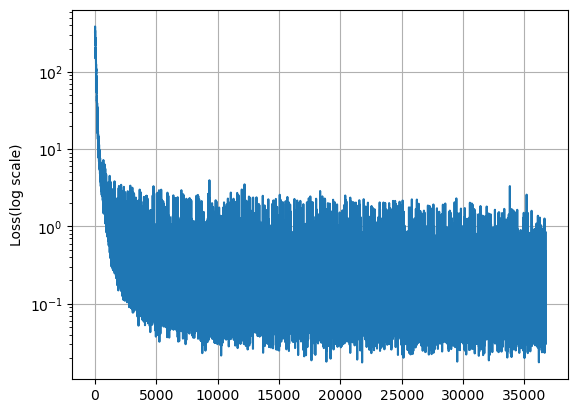

In [25]:
#plt.figure(1, figsize = [20,10])
plt.semilogy(epoch_loss)
plt.ylabel('Loss(log scale)')
plt.grid()

In [26]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_inputs = torch.tensor(inp_test_data, dtype=torch.float32).to(device)
    test_targets = torch.tensor(out_test_data, dtype=torch.float32).to(device)
    test_outputs = model(test_inputs)
    test_loss = criterion(test_outputs, test_targets)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.1343


C:\Users\sriniva3\AppData\Local\Temp\ipykernel_6440\1681708791.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(inp_test_data, dtype=torch.float32).to(device)
C:\Users\sriniva3\AppData\Local\Temp\ipykernel_6440\1681708791.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_targets = torch.tensor(out_test_data, dtype=torch.float32).to(device)


In [27]:
#torch.save(model, 'LSTM.pth')
#torch.save(model.state_dict(), 'LSTM_state_dict.pth')


In [28]:
########## CDF plots ###########
pred = test_outputs.detach().numpy()
tgt = test_targets.detach().numpy()
error = tgt - pred
#pred = pred.flatten()
#tgt = tgt.flatten()
sortd_pred, a_pred = return_cdf(pred[:,0])
sortd_tgt, a_tgt = return_cdf(tgt[:,0])


In [29]:
#plt.plot(sortd_pred, a_pred)
#plt.plot(sortd_tgt, a_tgt, alpha = 0.3)

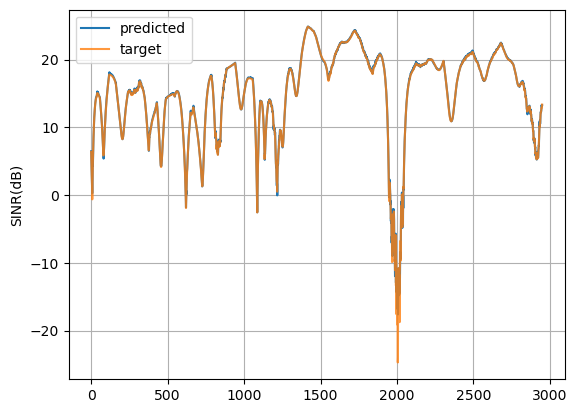

In [44]:
plt.plot(pred[:,0], alpha = 1, label = 'predicted')
plt.plot(tgt[:,0], label = 'target', alpha = 0.8)
plt.legend()
plt.ylabel('SINR(dB)')
plt.grid()
plt.show()

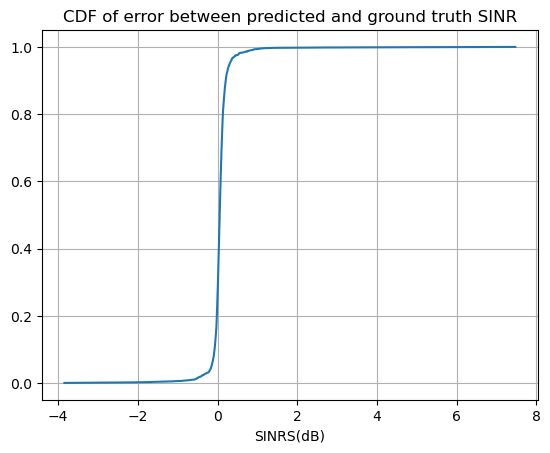

In [36]:
error = pred[:,0].flatten() - tgt[:,0].flatten()
sortd_error, a_error = return_cdf(error.flatten())
plt.plot(sortd_error, a_error)
plt.title('CDF of error between predicted and ground truth SINR')
plt.xlabel('SINRS(dB)')
plt.grid()
plt.show()

In [37]:
np.where(error >=4)

(array([1996, 2004, 2005, 2006, 2017], dtype=int64),)

In [41]:
pred[1996,0]

-13.34621

In [42]:
tgt[1996,0]

-17.573128